In [1]:
%matplotlib inline

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.functional as F
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
from torchdiffeq import odeint
from torchcontrol.arch_cpugpu import HDNN, HDNN_Observer
from torchcontrol.utils import genpoints
import scipy
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from torch.nn import LSTM

In [3]:
device = torch.device('cpu')
if torch.cuda.is_available(): device = torch.device('cuda')
print(device)

cuda


# Duffin Oscillator

$$\begin{bmatrix}\dot{u}\\\dot{v}\end{bmatrix}= \begin{bmatrix}v\\-\alpha u - k v -\beta u^3\end{bmatrix}$$
$$\Leftrightarrow\dot{x}= \Psi(x)$$

In [4]:
a = 1.0
b = 1
c = 1.0
d = 1
# Dissipation rate
k = 0.1

In [5]:
# define the ODE
def LV(x,t):
    u = x[0]
    v = x[1]
    dudt = v#a*u - b*u*v #
    dvdt = -a*u - k*v -b*pow(u,3) #-c*v +d*u*v + k*(a-b*v)*v#
    return [dudt,dvdt]

In [6]:
# Simulate the systems
N = 100
Tf = 30
Ts = Tf/N
print('The sampling time is ',Ts,'s')
t = np.linspace(0,Tf,N).tolist()
# standard form
x0 = [1.5,1]
x = odeint(LV,x0,t)

The sampling time is  0.3 s


In [7]:
# save traj
orig_traj = x

(-2.254238161771069, 2.0297714065099197)

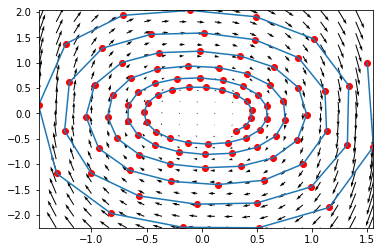

In [8]:
Np = 20
xlim = np.hstack((orig_traj.min(0)[0],orig_traj.max(0)[0]))
ylim = np.hstack((orig_traj.min(0)[1],orig_traj.max(0)[1]))

x1 = np.linspace(xlim[0],xlim[1],Np)
x2 = np.linspace(ylim[0],ylim[1],Np)
X1,X2 = np.meshgrid(x1,x2)

U = np.zeros((Np,Np))
V = np.zeros((Np,Np))

for i in range(Np):
    for j in range(Np):
        U[i,j], V[i,j] = LV([X1[i,j],X2[i,j]],0)

fig, ax = plt.subplots()
q = ax.quiver(X1, X2, U, V,scale = 80)
ax.plot(x[:,0],x[:,1])
ax.scatter(x[:,0],x[:,1], color = 'r')
plt.xlim([xlim[0],xlim[1]])
plt.ylim([ylim[0],ylim[1]])

## HDNN

Two methods attempted: 1st - approximation of derivative with $$\hat{y}_i = \frac{(\hat{u}_{i+1} - \hat{u}_{i})}{Ts}$$
2nd - use as labels $$LV(x_{i}, t)$$

In [9]:
x = torch.Tensor(x).to(device)
x[1:]
x0 = x[0].view(1,2)

In [10]:
# with approx
#grad = ([(x[i+1] - x[i])/0.01 for i in range(len(x)-1)])
#grad = torch.Tensor([g.cpu().numpy() for g in grad])
# with real LV
grad = ([LV(x[i], t) for i in range(len(x)-1)])
grad = torch.Tensor([g for g in grad])

In [11]:
train = data_utils.TensorDataset(x[:-1], grad)
trainloader = data_utils.DataLoader(train, batch_size=N-1)

In [12]:
# Define Neural Network
obs = HDNN('MLP', [[2, 4, 4, 4, 2], False], [1,1,0], 0.5, odeint='cpu')

Text(0.5, 1.0, 'Pre training approximated vector field')

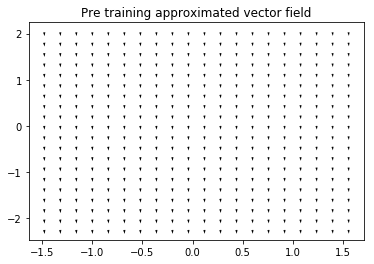

In [13]:
X1t = torch.Tensor(X1).to(device)
X2t = torch.Tensor(X2).to(device)
Up = np.zeros((Np,Np))
Vp = np.zeros((Np,Np))

for i in range(Np):
    for j in range(Np):
        point = torch.Tensor([X1[i,j],X2[i,j]]).to(device)
        Up[i,j], Vp[i,j] = obs.predictor(point.view(1,2))[0][0],obs.predictor(point.view(1,2))[0][1]

Uo, Vo = Up, Vp

fig, ax = plt.subplots()
q = ax.quiver(X1, X2, Up, Vp,scale = 80)
plt.title("Pre training approximated vector field")

In [26]:
obs.fit(trainloader, epoch=100000, time_delta=100, iter_accuracy=float('inf'), ode_t=0.001, ode_step=2, criterion='mse')

odeint iter: 33010 
odeint iter: 33020 
odeint iter: 33030 
odeint iter: 33040 
odeint iter: 33050 
odeint iter: 33060 
odeint iter: 33070 
odeint iter: 33080 
odeint iter: 33090 
odeint iter: 33100 
odeint iter: 33110 
odeint iter: 33120 
odeint iter: 33130 
odeint iter: 33140 
odeint iter: 33150 
odeint iter: 33160 
odeint iter: 33170 
odeint iter: 33180 
odeint iter: 33190 
odeint iter: 33200 
odeint iter: 33210 
odeint iter: 33220 
odeint iter: 33230 
odeint iter: 33240 
odeint iter: 33250 
odeint iter: 33260 
odeint iter: 33270 
odeint iter: 33280 
odeint iter: 33290 
odeint iter: 33300 
odeint iter: 33310 
odeint iter: 33320 
odeint iter: 33330 
odeint iter: 33340 
odeint iter: 33350 
odeint iter: 33360 
odeint iter: 33370 
odeint iter: 33380 
odeint iter: 33390 
odeint iter: 33400 
odeint iter: 33410 
odeint iter: 33420 
odeint iter: 33430 
odeint iter: 33440 
odeint iter: 33450 
odeint iter: 33460 
odeint iter: 33470 
odeint iter: 33480 
odeint iter: 33490 
odeint iter: 33500 


odeint iter: 37180 
odeint iter: 37190 
odeint iter: 37200 
odeint iter: 37210 
odeint iter: 37220 
odeint iter: 37230 
odeint iter: 37240 
odeint iter: 37250 
odeint iter: 37260 
odeint iter: 37270 
odeint iter: 37280 
odeint iter: 37290 
odeint iter: 37300 
odeint iter: 37310 
odeint iter: 37320 
odeint iter: 37330 
odeint iter: 37340 
odeint iter: 37350 
odeint iter: 37360 
odeint iter: 37370 
odeint iter: 37380 
odeint iter: 37390 
odeint iter: 37400 
odeint iter: 37410 
odeint iter: 37420 
odeint iter: 37430 
odeint iter: 37440 
odeint iter: 37450 
odeint iter: 37460 
odeint iter: 37470 
odeint iter: 37480 
odeint iter: 37490 
odeint iter: 37500 
odeint iter: 37510 
odeint iter: 37520 
odeint iter: 37530 
odeint iter: 37540 
odeint iter: 37550 
odeint iter: 37560 
odeint iter: 37570 
odeint iter: 37580 
odeint iter: 37590 
odeint iter: 37600 
odeint iter: 37610 
odeint iter: 37620 
odeint iter: 37630 
odeint iter: 37640 
odeint iter: 37650 
odeint iter: 37660 
odeint iter: 37670 


odeint iter: 41290 
odeint iter: 41300 
odeint iter: 41310 
odeint iter: 41320 
odeint iter: 41330 
odeint iter: 41340 
odeint iter: 41350 
odeint iter: 41360 
odeint iter: 41370 
odeint iter: 41380 
odeint iter: 41390 
odeint iter: 41400 
odeint iter: 41410 
odeint iter: 41420 
odeint iter: 41430 
odeint iter: 41440 
odeint iter: 41450 
odeint iter: 41460 
odeint iter: 41470 
odeint iter: 41480 
odeint iter: 41490 
odeint iter: 41500 
odeint iter: 41510 
odeint iter: 41520 
odeint iter: 41530 
odeint iter: 41540 
odeint iter: 41550 
odeint iter: 41560 
odeint iter: 41570 
odeint iter: 41580 
odeint iter: 41590 
odeint iter: 41600 
odeint iter: 41610 
odeint iter: 41620 
odeint iter: 41630 
odeint iter: 41640 
odeint iter: 41650 
odeint iter: 41660 
odeint iter: 41670 
odeint iter: 41680 
odeint iter: 41690 
odeint iter: 41700 
odeint iter: 41710 
odeint iter: 41720 
odeint iter: 41730 
odeint iter: 41740 
odeint iter: 41750 
odeint iter: 41760 
odeint iter: 41770 
odeint iter: 41780 


odeint iter: 45440 
odeint iter: 45450 
odeint iter: 45460 
odeint iter: 45470 
odeint iter: 45480 
odeint iter: 45490 
odeint iter: 45500 
odeint iter: 45510 
odeint iter: 45520 
odeint iter: 45530 
odeint iter: 45540 
odeint iter: 45550 
odeint iter: 45560 
odeint iter: 45570 
odeint iter: 45580 
odeint iter: 45590 
odeint iter: 45600 
odeint iter: 45610 
odeint iter: 45620 
odeint iter: 45630 
odeint iter: 45640 
odeint iter: 45650 
odeint iter: 45660 
odeint iter: 45670 
odeint iter: 45680 
odeint iter: 45690 
odeint iter: 45700 
odeint iter: 45710 
odeint iter: 45720 
odeint iter: 45730 
odeint iter: 45740 
odeint iter: 45750 
odeint iter: 45760 
odeint iter: 45770 
odeint iter: 45780 
odeint iter: 45790 
odeint iter: 45800 
odeint iter: 45810 
odeint iter: 45820 
odeint iter: 45830 
odeint iter: 45840 
odeint iter: 45850 
odeint iter: 45860 
odeint iter: 45870 
odeint iter: 45880 
odeint iter: 45890 
odeint iter: 45900 
odeint iter: 45910 
odeint iter: 45920 
odeint iter: 45930 


odeint iter: 49600 
odeint iter: 49610 
odeint iter: 49620 
odeint iter: 49630 
odeint iter: 49640 
odeint iter: 49650 
odeint iter: 49660 
odeint iter: 49670 
odeint iter: 49680 
odeint iter: 49690 
odeint iter: 49700 
odeint iter: 49710 
odeint iter: 49720 
odeint iter: 49730 
odeint iter: 49740 
odeint iter: 49750 
odeint iter: 49760 
odeint iter: 49770 
odeint iter: 49780 
odeint iter: 49790 
odeint iter: 49800 
odeint iter: 49810 
odeint iter: 49820 
odeint iter: 49830 
odeint iter: 49840 
odeint iter: 49850 
odeint iter: 49860 
odeint iter: 49870 
odeint iter: 49880 
odeint iter: 49890 
odeint iter: 49900 
odeint iter: 49910 
odeint iter: 49920 
odeint iter: 49930 
odeint iter: 49940 
odeint iter: 49950 
odeint iter: 49960 
odeint iter: 49970 
odeint iter: 49980 
odeint iter: 49990 
odeint iter: 50000 
odeint iter: 50010 
odeint iter: 50020 
odeint iter: 50030 
odeint iter: 50040 
odeint iter: 50050 
odeint iter: 50060 
odeint iter: 50070 
odeint iter: 50080 
odeint iter: 50090 


odeint iter: 53770 
odeint iter: 53780 
odeint iter: 53790 
odeint iter: 53800 
odeint iter: 53810 
odeint iter: 53820 
odeint iter: 53830 
odeint iter: 53840 
odeint iter: 53850 
odeint iter: 53860 
odeint iter: 53870 
odeint iter: 53880 
odeint iter: 53890 
odeint iter: 53900 
odeint iter: 53910 
odeint iter: 53920 
odeint iter: 53930 
odeint iter: 53940 
odeint iter: 53950 
odeint iter: 53960 
odeint iter: 53970 
odeint iter: 53980 
odeint iter: 53990 
odeint iter: 54000 
odeint iter: 54010 
odeint iter: 54020 
odeint iter: 54030 
odeint iter: 54040 
odeint iter: 54050 
odeint iter: 54060 
odeint iter: 54070 
odeint iter: 54080 
odeint iter: 54090 
odeint iter: 54100 
odeint iter: 54110 
odeint iter: 54120 
odeint iter: 54130 
odeint iter: 54140 
odeint iter: 54150 
odeint iter: 54160 
odeint iter: 54170 
odeint iter: 54180 
odeint iter: 54190 
odeint iter: 54200 
odeint iter: 54210 
odeint iter: 54220 
odeint iter: 54230 
odeint iter: 54240 
odeint iter: 54250 
odeint iter: 54260 


odeint iter: 57930 
odeint iter: 57940 
odeint iter: 57950 
odeint iter: 57960 
odeint iter: 57970 
odeint iter: 57980 
odeint iter: 57990 
odeint iter: 58000 
odeint iter: 58010 
odeint iter: 58020 
odeint iter: 58030 
odeint iter: 58040 
odeint iter: 58050 
odeint iter: 58060 
odeint iter: 58070 
odeint iter: 58080 
odeint iter: 58090 
odeint iter: 58100 
odeint iter: 58110 
odeint iter: 58120 
odeint iter: 58130 
odeint iter: 58140 
odeint iter: 58150 
odeint iter: 58160 
odeint iter: 58170 
odeint iter: 58180 
odeint iter: 58190 
odeint iter: 58200 
odeint iter: 58210 
odeint iter: 58220 
odeint iter: 58230 
odeint iter: 58240 
odeint iter: 58250 
odeint iter: 58260 
odeint iter: 58270 
odeint iter: 58280 
odeint iter: 58290 
odeint iter: 58300 
odeint iter: 58310 
odeint iter: 58320 
odeint iter: 58330 
odeint iter: 58340 
odeint iter: 58350 
odeint iter: 58360 
odeint iter: 58370 
odeint iter: 58380 
odeint iter: 58390 
odeint iter: 58400 
odeint iter: 58410 
odeint iter: 58420 


odeint iter: 62050 
odeint iter: 62060 
odeint iter: 62070 
odeint iter: 62080 
odeint iter: 62090 
odeint iter: 62100 
odeint iter: 62110 
odeint iter: 62120 
odeint iter: 62130 
odeint iter: 62140 
odeint iter: 62150 
odeint iter: 62160 
odeint iter: 62170 
odeint iter: 62180 
odeint iter: 62190 
odeint iter: 62200 
odeint iter: 62210 
odeint iter: 62220 
odeint iter: 62230 
odeint iter: 62240 
odeint iter: 62250 
odeint iter: 62260 
odeint iter: 62270 
odeint iter: 62280 
odeint iter: 62290 
odeint iter: 62300 
odeint iter: 62310 
odeint iter: 62320 
odeint iter: 62330 
odeint iter: 62340 
odeint iter: 62350 
odeint iter: 62360 
odeint iter: 62370 
odeint iter: 62380 
odeint iter: 62390 
odeint iter: 62400 
odeint iter: 62410 
odeint iter: 62420 
odeint iter: 62430 
odeint iter: 62440 
odeint iter: 62450 
odeint iter: 62460 
odeint iter: 62470 
odeint iter: 62480 
odeint iter: 62490 
odeint iter: 62500 
odeint iter: 62510 
odeint iter: 62520 
odeint iter: 62530 
odeint iter: 62540 


odeint iter: 66160 
odeint iter: 66170 
odeint iter: 66180 
odeint iter: 66190 
odeint iter: 66200 
odeint iter: 66210 
odeint iter: 66220 
odeint iter: 66230 
odeint iter: 66240 
odeint iter: 66250 
odeint iter: 66260 
odeint iter: 66270 
odeint iter: 66280 
odeint iter: 66290 
odeint iter: 66300 
odeint iter: 66310 
odeint iter: 66320 
odeint iter: 66330 
odeint iter: 66340 
odeint iter: 66350 
odeint iter: 66360 
odeint iter: 66370 
odeint iter: 66380 
odeint iter: 66390 
odeint iter: 66400 
odeint iter: 66410 
odeint iter: 66420 
odeint iter: 66430 
odeint iter: 66440 
odeint iter: 66450 
odeint iter: 66460 
odeint iter: 66470 
odeint iter: 66480 
odeint iter: 66490 
odeint iter: 66500 
odeint iter: 66510 
odeint iter: 66520 
odeint iter: 66530 
odeint iter: 66540 
odeint iter: 66550 
odeint iter: 66560 
odeint iter: 66570 
odeint iter: 66580 
odeint iter: 66590 
odeint iter: 66600 
odeint iter: 66610 
odeint iter: 66620 
odeint iter: 66630 
odeint iter: 66640 
odeint iter: 66650 


odeint iter: 70300 
odeint iter: 70310 
odeint iter: 70320 
odeint iter: 70330 
odeint iter: 70340 
odeint iter: 70350 
odeint iter: 70360 
odeint iter: 70370 
odeint iter: 70380 
odeint iter: 70390 
odeint iter: 70400 
odeint iter: 70410 
odeint iter: 70420 
odeint iter: 70430 
odeint iter: 70440 
odeint iter: 70450 
odeint iter: 70460 
odeint iter: 70470 
odeint iter: 70480 
odeint iter: 70490 
odeint iter: 70500 
odeint iter: 70510 
odeint iter: 70520 
odeint iter: 70530 
odeint iter: 70540 
odeint iter: 70550 
odeint iter: 70560 
odeint iter: 70570 
odeint iter: 70580 
odeint iter: 70590 
odeint iter: 70600 
odeint iter: 70610 
odeint iter: 70620 
odeint iter: 70630 
odeint iter: 70640 
odeint iter: 70650 
odeint iter: 70660 
odeint iter: 70670 
odeint iter: 70680 
odeint iter: 70690 
odeint iter: 70700 
odeint iter: 70710 
odeint iter: 70720 
odeint iter: 70730 
odeint iter: 70740 
odeint iter: 70750 
odeint iter: 70760 
odeint iter: 70770 
odeint iter: 70780 
odeint iter: 70790 


odeint iter: 74450 
odeint iter: 74460 
odeint iter: 74470 
odeint iter: 74480 
odeint iter: 74490 
odeint iter: 74500 
odeint iter: 74510 
odeint iter: 74520 
odeint iter: 74530 
odeint iter: 74540 
odeint iter: 74550 
odeint iter: 74560 
odeint iter: 74570 
odeint iter: 74580 
odeint iter: 74590 
odeint iter: 74600 
odeint iter: 74610 
odeint iter: 74620 
odeint iter: 74630 
odeint iter: 74640 
odeint iter: 74650 
odeint iter: 74660 
odeint iter: 74670 
odeint iter: 74680 
odeint iter: 74690 
odeint iter: 74700 
odeint iter: 74710 
odeint iter: 74720 
odeint iter: 74730 
odeint iter: 74740 
odeint iter: 74750 
odeint iter: 74760 
odeint iter: 74770 
odeint iter: 74780 
odeint iter: 74790 
odeint iter: 74800 
odeint iter: 74810 
odeint iter: 74820 
odeint iter: 74830 
odeint iter: 74840 
odeint iter: 74850 
odeint iter: 74860 
odeint iter: 74870 
odeint iter: 74880 
odeint iter: 74890 
odeint iter: 74900 
odeint iter: 74910 
odeint iter: 74920 
odeint iter: 74930 
odeint iter: 74940 


odeint iter: 78610 
odeint iter: 78620 
odeint iter: 78630 
odeint iter: 78640 
odeint iter: 78650 
odeint iter: 78660 
odeint iter: 78670 
odeint iter: 78680 
odeint iter: 78690 
odeint iter: 78700 
odeint iter: 78710 
odeint iter: 78720 
odeint iter: 78730 
odeint iter: 78740 
odeint iter: 78750 
odeint iter: 78760 
odeint iter: 78770 
odeint iter: 78780 
odeint iter: 78790 
odeint iter: 78800 
odeint iter: 78810 
odeint iter: 78820 
odeint iter: 78830 
odeint iter: 78840 
odeint iter: 78850 
odeint iter: 78860 
odeint iter: 78870 
odeint iter: 78880 
odeint iter: 78890 
odeint iter: 78900 
odeint iter: 78910 
odeint iter: 78920 
odeint iter: 78930 
odeint iter: 78940 
odeint iter: 78950 
odeint iter: 78960 
odeint iter: 78970 
odeint iter: 78980 
odeint iter: 78990 
odeint iter: 79000 
odeint iter: 79010 
odeint iter: 79020 
odeint iter: 79030 
odeint iter: 79040 
odeint iter: 79050 
odeint iter: 79060 
odeint iter: 79070 
odeint iter: 79080 
odeint iter: 79090 
odeint iter: 79100 


odeint iter: 82770 
odeint iter: 82780 
odeint iter: 82790 
odeint iter: 82800 
odeint iter: 82810 
odeint iter: 82820 
odeint iter: 82830 
odeint iter: 82840 
odeint iter: 82850 
odeint iter: 82860 
odeint iter: 82870 
odeint iter: 82880 
odeint iter: 82890 
odeint iter: 82900 
odeint iter: 82910 
odeint iter: 82920 
odeint iter: 82930 
odeint iter: 82940 
odeint iter: 82950 
odeint iter: 82960 
odeint iter: 82970 
odeint iter: 82980 
odeint iter: 82990 
odeint iter: 83000 
odeint iter: 83010 
odeint iter: 83020 
odeint iter: 83030 
odeint iter: 83040 
odeint iter: 83050 
odeint iter: 83060 
odeint iter: 83070 
odeint iter: 83080 
odeint iter: 83090 
odeint iter: 83100 
odeint iter: 83110 
odeint iter: 83120 
odeint iter: 83130 
odeint iter: 83140 
odeint iter: 83150 
odeint iter: 83160 
odeint iter: 83170 
odeint iter: 83180 
odeint iter: 83190 
odeint iter: 83200 
odeint iter: 83210 
odeint iter: 83220 
odeint iter: 83230 
odeint iter: 83240 
odeint iter: 83250 
odeint iter: 83260 


odeint iter: 86900 
odeint iter: 86910 
odeint iter: 86920 
odeint iter: 86930 
odeint iter: 86940 
odeint iter: 86950 
odeint iter: 86960 
odeint iter: 86970 
odeint iter: 86980 
odeint iter: 86990 
odeint iter: 87000 
odeint iter: 87010 
odeint iter: 87020 
odeint iter: 87030 
odeint iter: 87040 
odeint iter: 87050 
odeint iter: 87060 
odeint iter: 87070 
odeint iter: 87080 
odeint iter: 87090 
odeint iter: 87100 
odeint iter: 87110 
odeint iter: 87120 
odeint iter: 87130 
odeint iter: 87140 
odeint iter: 87150 
odeint iter: 87160 
odeint iter: 87170 
odeint iter: 87180 
odeint iter: 87190 
odeint iter: 87200 
odeint iter: 87210 
odeint iter: 87220 
odeint iter: 87230 
odeint iter: 87240 
odeint iter: 87250 
odeint iter: 87260 
odeint iter: 87270 
odeint iter: 87280 
odeint iter: 87290 
odeint iter: 87300 
odeint iter: 87310 
odeint iter: 87320 
odeint iter: 87330 
odeint iter: 87340 
odeint iter: 87350 
odeint iter: 87360 
odeint iter: 87370 
odeint iter: 87380 
odeint iter: 87390 


odeint iter: 91020 
odeint iter: 91030 
odeint iter: 91040 
odeint iter: 91050 
odeint iter: 91060 
odeint iter: 91070 
odeint iter: 91080 
odeint iter: 91090 
odeint iter: 91100 
odeint iter: 91110 
odeint iter: 91120 
odeint iter: 91130 
odeint iter: 91140 
odeint iter: 91150 
odeint iter: 91160 
odeint iter: 91170 
odeint iter: 91180 
odeint iter: 91190 
odeint iter: 91200 
odeint iter: 91210 
odeint iter: 91220 
odeint iter: 91230 
odeint iter: 91240 
odeint iter: 91250 
odeint iter: 91260 
odeint iter: 91270 
odeint iter: 91280 
odeint iter: 91290 
odeint iter: 91300 
odeint iter: 91310 
odeint iter: 91320 
odeint iter: 91330 
odeint iter: 91340 
odeint iter: 91350 
odeint iter: 91360 
odeint iter: 91370 
odeint iter: 91380 
odeint iter: 91390 
odeint iter: 91400 
odeint iter: 91410 
odeint iter: 91420 
odeint iter: 91430 
odeint iter: 91440 
odeint iter: 91450 
odeint iter: 91460 
odeint iter: 91470 
odeint iter: 91480 
odeint iter: 91490 
odeint iter: 91500 
odeint iter: 91510 


odeint iter: 95150 
odeint iter: 95160 
odeint iter: 95170 
odeint iter: 95180 
odeint iter: 95190 
odeint iter: 95200 
odeint iter: 95210 
odeint iter: 95220 
odeint iter: 95230 
odeint iter: 95240 
odeint iter: 95250 
odeint iter: 95260 
odeint iter: 95270 
odeint iter: 95280 
odeint iter: 95290 
odeint iter: 95300 
odeint iter: 95310 
odeint iter: 95320 
odeint iter: 95330 
odeint iter: 95340 
odeint iter: 95350 
odeint iter: 95360 
odeint iter: 95370 
odeint iter: 95380 
odeint iter: 95390 
odeint iter: 95400 
odeint iter: 95410 
odeint iter: 95420 
odeint iter: 95430 
odeint iter: 95440 
odeint iter: 95450 
odeint iter: 95460 
odeint iter: 95470 
odeint iter: 95480 
odeint iter: 95490 
odeint iter: 95500 
odeint iter: 95510 
odeint iter: 95520 
odeint iter: 95530 
odeint iter: 95540 
odeint iter: 95550 
odeint iter: 95560 
odeint iter: 95570 
odeint iter: 95580 
odeint iter: 95590 
odeint iter: 95600 
odeint iter: 95610 
odeint iter: 95620 
odeint iter: 95630 
odeint iter: 95640 


odeint iter: 99260 
odeint iter: 99270 
odeint iter: 99280 
odeint iter: 99290 
odeint iter: 99300 
odeint iter: 99310 
odeint iter: 99320 
odeint iter: 99330 
odeint iter: 99340 
odeint iter: 99350 
odeint iter: 99360 
odeint iter: 99370 
odeint iter: 99380 
odeint iter: 99390 
odeint iter: 99400 
odeint iter: 99410 
odeint iter: 99420 
odeint iter: 99430 
odeint iter: 99440 
odeint iter: 99450 
odeint iter: 99460 
odeint iter: 99470 
odeint iter: 99480 
odeint iter: 99490 
odeint iter: 99500 
odeint iter: 99510 
odeint iter: 99520 
odeint iter: 99530 
odeint iter: 99540 
odeint iter: 99550 
odeint iter: 99560 
odeint iter: 99570 
odeint iter: 99580 
odeint iter: 99590 
odeint iter: 99600 
odeint iter: 99610 
odeint iter: 99620 
odeint iter: 99630 
odeint iter: 99640 
odeint iter: 99650 
odeint iter: 99660 
odeint iter: 99670 
odeint iter: 99680 
odeint iter: 99690 
odeint iter: 99700 
odeint iter: 99710 
odeint iter: 99720 
odeint iter: 99730 
odeint iter: 99740 
odeint iter: 99750 


odeint iter: 103250 
odeint iter: 103260 
odeint iter: 103270 
odeint iter: 103280 
odeint iter: 103290 
odeint iter: 103300 
odeint iter: 103310 
odeint iter: 103320 
odeint iter: 103330 
odeint iter: 103340 
odeint iter: 103350 
odeint iter: 103360 
odeint iter: 103370 
odeint iter: 103380 
odeint iter: 103390 
odeint iter: 103400 
odeint iter: 103410 
odeint iter: 103420 
odeint iter: 103430 
odeint iter: 103440 
odeint iter: 103450 
odeint iter: 103460 
odeint iter: 103470 
odeint iter: 103480 
odeint iter: 103490 
odeint iter: 103500 
odeint iter: 103510 
odeint iter: 103520 
odeint iter: 103530 
odeint iter: 103540 
odeint iter: 103550 
odeint iter: 103560 
odeint iter: 103570 
odeint iter: 103580 
odeint iter: 103590 
odeint iter: 103600 
odeint iter: 103610 
odeint iter: 103620 
odeint iter: 103630 
odeint iter: 103640 
odeint iter: 103650 
odeint iter: 103660 
odeint iter: 103670 
odeint iter: 103680 
odeint iter: 103690 
odeint iter: 103700 
odeint iter: 103710 
odeint iter: 

odeint iter: 107220 
odeint iter: 107230 
odeint iter: 107240 
odeint iter: 107250 
odeint iter: 107260 
odeint iter: 107270 
odeint iter: 107280 
odeint iter: 107290 
odeint iter: 107300 
odeint iter: 107310 
odeint iter: 107320 
odeint iter: 107330 
odeint iter: 107340 
odeint iter: 107350 
odeint iter: 107360 
odeint iter: 107370 
odeint iter: 107380 
odeint iter: 107390 
odeint iter: 107400 
odeint iter: 107410 
odeint iter: 107420 
odeint iter: 107430 
odeint iter: 107440 
odeint iter: 107450 
odeint iter: 107460 
odeint iter: 107470 
odeint iter: 107480 
odeint iter: 107490 
odeint iter: 107500 
odeint iter: 107510 
odeint iter: 107520 
odeint iter: 107530 
odeint iter: 107540 
odeint iter: 107550 
odeint iter: 107560 
odeint iter: 107570 
odeint iter: 107580 
odeint iter: 107590 
odeint iter: 107600 
odeint iter: 107610 
odeint iter: 107620 
odeint iter: 107630 
odeint iter: 107640 
odeint iter: 107650 
odeint iter: 107660 
odeint iter: 107670 
odeint iter: 107680 
odeint iter: 

odeint iter: 111130 
odeint iter: 111140 
odeint iter: 111150 
odeint iter: 111160 
odeint iter: 111170 
odeint iter: 111180 
odeint iter: 111190 
odeint iter: 111200 
odeint iter: 111210 
odeint iter: 111220 
odeint iter: 111230 
odeint iter: 111240 
odeint iter: 111250 
odeint iter: 111260 
odeint iter: 111270 
odeint iter: 111280 
odeint iter: 111290 
odeint iter: 111300 
odeint iter: 111310 
odeint iter: 111320 
odeint iter: 111330 
odeint iter: 111340 
odeint iter: 111350 
odeint iter: 111360 
odeint iter: 111370 
odeint iter: 111380 
odeint iter: 111390 
odeint iter: 111400 
odeint iter: 111410 
odeint iter: 111420 
odeint iter: 111430 
odeint iter: 111440 
odeint iter: 111450 
odeint iter: 111460 
odeint iter: 111470 
odeint iter: 111480 
odeint iter: 111490 
odeint iter: 111500 
odeint iter: 111510 
odeint iter: 111520 
odeint iter: 111530 
odeint iter: 111540 
odeint iter: 111550 
odeint iter: 111560 
odeint iter: 111570 
odeint iter: 111580 
odeint iter: 111590 
odeint iter: 

odeint iter: 115040 
odeint iter: 115050 
odeint iter: 115060 
odeint iter: 115070 
odeint iter: 115080 
odeint iter: 115090 
odeint iter: 115100 
odeint iter: 115110 
odeint iter: 115120 
odeint iter: 115130 
odeint iter: 115140 
odeint iter: 115150 
odeint iter: 115160 
odeint iter: 115170 
odeint iter: 115180 
odeint iter: 115190 
odeint iter: 115200 
odeint iter: 115210 
odeint iter: 115220 
odeint iter: 115230 
odeint iter: 115240 
odeint iter: 115250 
odeint iter: 115260 
odeint iter: 115270 
odeint iter: 115280 
odeint iter: 115290 
odeint iter: 115300 
odeint iter: 115310 
odeint iter: 115320 
odeint iter: 115330 
odeint iter: 115340 
odeint iter: 115350 
odeint iter: 115360 
odeint iter: 115370 
odeint iter: 115380 
odeint iter: 115390 
odeint iter: 115400 
odeint iter: 115410 
odeint iter: 115420 
odeint iter: 115430 
odeint iter: 115440 
odeint iter: 115450 
odeint iter: 115460 
odeint iter: 115470 
odeint iter: 115480 
odeint iter: 115490 
odeint iter: 115500 
odeint iter: 

odeint iter: 118970 
odeint iter: 118980 
odeint iter: 118990 
odeint iter: 119000 
odeint iter: 119010 
odeint iter: 119020 
odeint iter: 119030 
odeint iter: 119040 
odeint iter: 119050 
odeint iter: 119060 
odeint iter: 119070 
odeint iter: 119080 
odeint iter: 119090 
odeint iter: 119100 
odeint iter: 119110 
odeint iter: 119120 
odeint iter: 119130 
odeint iter: 119140 
odeint iter: 119150 
odeint iter: 119160 
odeint iter: 119170 
odeint iter: 119180 
odeint iter: 119190 
odeint iter: 119200 
odeint iter: 119210 
odeint iter: 119220 
odeint iter: 119230 
odeint iter: 119240 
odeint iter: 119250 
odeint iter: 119260 
odeint iter: 119270 
odeint iter: 119280 
odeint iter: 119290 
odeint iter: 119300 
odeint iter: 119310 
odeint iter: 119320 
odeint iter: 119330 
odeint iter: 119340 
odeint iter: 119350 
odeint iter: 119360 
odeint iter: 119370 
odeint iter: 119380 
odeint iter: 119390 
odeint iter: 119400 
odeint iter: 119410 
odeint iter: 119420 
odeint iter: 119430 
odeint iter: 

odeint iter: 122930 
odeint iter: 122940 
odeint iter: 122950 
odeint iter: 122960 
odeint iter: 122970 
odeint iter: 122980 
odeint iter: 122990 
odeint iter: 123000 
odeint iter: 123010 
odeint iter: 123020 
odeint iter: 123030 
odeint iter: 123040 
odeint iter: 123050 
odeint iter: 123060 
odeint iter: 123070 
odeint iter: 123080 
odeint iter: 123090 
odeint iter: 123100 
odeint iter: 123110 
odeint iter: 123120 
odeint iter: 123130 
odeint iter: 123140 
odeint iter: 123150 
odeint iter: 123160 
odeint iter: 123170 
odeint iter: 123180 
odeint iter: 123190 
odeint iter: 123200 
odeint iter: 123210 
odeint iter: 123220 
odeint iter: 123230 
odeint iter: 123240 
odeint iter: 123250 
odeint iter: 123260 
odeint iter: 123270 
odeint iter: 123280 
odeint iter: 123290 
odeint iter: 123300 
odeint iter: 123310 
odeint iter: 123320 
odeint iter: 123330 
odeint iter: 123340 
odeint iter: 123350 
odeint iter: 123360 
odeint iter: 123370 
odeint iter: 123380 
odeint iter: 123390 
odeint iter: 

odeint iter: 126840 
odeint iter: 126850 
odeint iter: 126860 
odeint iter: 126870 
odeint iter: 126880 
odeint iter: 126890 
odeint iter: 126900 
odeint iter: 126910 
odeint iter: 126920 
odeint iter: 126930 
odeint iter: 126940 
odeint iter: 126950 
odeint iter: 126960 
odeint iter: 126970 
odeint iter: 126980 
odeint iter: 126990 
odeint iter: 127000 
odeint iter: 127010 
odeint iter: 127020 
odeint iter: 127030 
odeint iter: 127040 
odeint iter: 127050 
odeint iter: 127060 
odeint iter: 127070 
odeint iter: 127080 
odeint iter: 127090 
odeint iter: 127100 
odeint iter: 127110 
odeint iter: 127120 
odeint iter: 127130 
odeint iter: 127140 
odeint iter: 127150 
odeint iter: 127160 
odeint iter: 127170 
odeint iter: 127180 
odeint iter: 127190 
odeint iter: 127200 
odeint iter: 127210 
odeint iter: 127220 
odeint iter: 127230 
odeint iter: 127240 
odeint iter: 127250 
odeint iter: 127260 
odeint iter: 127270 
odeint iter: 127280 
odeint iter: 127290 
odeint iter: 127300 
odeint iter: 

odeint iter: 130760 
odeint iter: 130770 
odeint iter: 130780 
odeint iter: 130790 
odeint iter: 130800 
odeint iter: 130810 
odeint iter: 130820 
odeint iter: 130830 
odeint iter: 130840 
odeint iter: 130850 
odeint iter: 130860 
odeint iter: 130870 
odeint iter: 130880 
odeint iter: 130890 
odeint iter: 130900 
odeint iter: 130910 
odeint iter: 130920 
odeint iter: 130930 
odeint iter: 130940 
odeint iter: 130950 
odeint iter: 130960 
odeint iter: 130970 
odeint iter: 130980 
odeint iter: 130990 
odeint iter: 131000 
odeint iter: 131010 
odeint iter: 131020 
odeint iter: 131030 
odeint iter: 131040 
odeint iter: 131050 
odeint iter: 131060 
odeint iter: 131070 
odeint iter: 131080 
odeint iter: 131090 
odeint iter: 131100 
odeint iter: 131110 
odeint iter: 131120 
odeint iter: 131130 
odeint iter: 131140 
odeint iter: 131150 
odeint iter: 131160 
odeint iter: 131170 
odeint iter: 131180 
odeint iter: 131190 
odeint iter: 131200 
odeint iter: 131210 
odeint iter: 131220 
odeint iter: 

odeint iter: 134680 
odeint iter: 134690 
odeint iter: 134700 
odeint iter: 134710 
odeint iter: 134720 
odeint iter: 134730 
odeint iter: 134740 
odeint iter: 134750 
odeint iter: 134760 
odeint iter: 134770 
odeint iter: 134780 
odeint iter: 134790 
odeint iter: 134800 
odeint iter: 134810 
odeint iter: 134820 
odeint iter: 134830 
odeint iter: 134840 
odeint iter: 134850 
odeint iter: 134860 
odeint iter: 134870 
odeint iter: 134880 
odeint iter: 134890 
odeint iter: 134900 
odeint iter: 134910 
odeint iter: 134920 
odeint iter: 134930 
odeint iter: 134940 
odeint iter: 134950 
odeint iter: 134960 
odeint iter: 134970 
odeint iter: 134980 
odeint iter: 134990 
odeint iter: 135000 
odeint iter: 135010 
odeint iter: 135020 
odeint iter: 135030 
odeint iter: 135040 
odeint iter: 135050 
odeint iter: 135060 
odeint iter: 135070 
odeint iter: 135080 
odeint iter: 135090 
odeint iter: 135100 
odeint iter: 135110 
odeint iter: 135120 
odeint iter: 135130 
odeint iter: 135140 
odeint iter: 

odeint iter: 138620 
odeint iter: 138630 
odeint iter: 138640 
odeint iter: 138650 
odeint iter: 138660 
odeint iter: 138670 
odeint iter: 138680 
odeint iter: 138690 
odeint iter: 138700 
odeint iter: 138710 
odeint iter: 138720 
odeint iter: 138730 
odeint iter: 138740 
odeint iter: 138750 
odeint iter: 138760 
odeint iter: 138770 
odeint iter: 138780 
odeint iter: 138790 
odeint iter: 138800 
odeint iter: 138810 
odeint iter: 138820 
odeint iter: 138830 
odeint iter: 138840 
odeint iter: 138850 
odeint iter: 138860 
odeint iter: 138870 
odeint iter: 138880 
odeint iter: 138890 
odeint iter: 138900 
odeint iter: 138910 
odeint iter: 138920 
odeint iter: 138930 
odeint iter: 138940 
odeint iter: 138950 
odeint iter: 138960 
odeint iter: 138970 
odeint iter: 138980 
odeint iter: 138990 
odeint iter: 139000 
odeint iter: 139010 
odeint iter: 139020 
odeint iter: 139030 
odeint iter: 139040 
odeint iter: 139050 
odeint iter: 139060 
odeint iter: 139070 
odeint iter: 139080 
odeint iter: 

odeint iter: 142540 
odeint iter: 142550 
odeint iter: 142560 
odeint iter: 142570 
odeint iter: 142580 
odeint iter: 142590 
odeint iter: 142600 
odeint iter: 142610 
odeint iter: 142620 
odeint iter: 142630 
odeint iter: 142640 
odeint iter: 142650 
odeint iter: 142660 
odeint iter: 142670 
odeint iter: 142680 
odeint iter: 142690 
odeint iter: 142700 
odeint iter: 142710 
odeint iter: 142720 
odeint iter: 142730 
odeint iter: 142740 
odeint iter: 142750 
odeint iter: 142760 
odeint iter: 142770 
odeint iter: 142780 
odeint iter: 142790 
odeint iter: 142800 
odeint iter: 142810 
odeint iter: 142820 
odeint iter: 142830 
odeint iter: 142840 
odeint iter: 142850 
odeint iter: 142860 
odeint iter: 142870 
odeint iter: 142880 
odeint iter: 142890 
odeint iter: 142900 
odeint iter: 142910 
odeint iter: 142920 
odeint iter: 142930 
odeint iter: 142940 
odeint iter: 142950 
odeint iter: 142960 
odeint iter: 142970 
odeint iter: 142980 
odeint iter: 142990 
odeint iter: 143000 
odeint iter: 

odeint iter: 146490 
odeint iter: 146500 
odeint iter: 146510 
odeint iter: 146520 
odeint iter: 146530 
odeint iter: 146540 
odeint iter: 146550 
odeint iter: 146560 
odeint iter: 146570 
odeint iter: 146580 
odeint iter: 146590 
odeint iter: 146600 
odeint iter: 146610 
odeint iter: 146620 
odeint iter: 146630 
odeint iter: 146640 
odeint iter: 146650 
odeint iter: 146660 
odeint iter: 146670 
odeint iter: 146680 
odeint iter: 146690 
odeint iter: 146700 
odeint iter: 146710 
odeint iter: 146720 
odeint iter: 146730 
odeint iter: 146740 
odeint iter: 146750 
odeint iter: 146760 
odeint iter: 146770 
odeint iter: 146780 
odeint iter: 146790 
odeint iter: 146800 
odeint iter: 146810 
odeint iter: 146820 
odeint iter: 146830 
odeint iter: 146840 
odeint iter: 146850 
odeint iter: 146860 
odeint iter: 146870 
odeint iter: 146880 
odeint iter: 146890 
odeint iter: 146900 
odeint iter: 146910 
odeint iter: 146920 
odeint iter: 146930 
odeint iter: 146940 
odeint iter: 146950 
odeint iter: 

odeint iter: 150440 
odeint iter: 150450 
odeint iter: 150460 
odeint iter: 150470 
odeint iter: 150480 
odeint iter: 150490 
odeint iter: 150500 
odeint iter: 150510 
odeint iter: 150520 
odeint iter: 150530 
odeint iter: 150540 
odeint iter: 150550 
odeint iter: 150560 
odeint iter: 150570 
odeint iter: 150580 
odeint iter: 150590 
odeint iter: 150600 
odeint iter: 150610 
odeint iter: 150620 
odeint iter: 150630 
odeint iter: 150640 
odeint iter: 150650 
odeint iter: 150660 
odeint iter: 150670 
odeint iter: 150680 
odeint iter: 150690 
odeint iter: 150700 
odeint iter: 150710 
odeint iter: 150720 
odeint iter: 150730 
odeint iter: 150740 
odeint iter: 150750 
odeint iter: 150760 
odeint iter: 150770 
odeint iter: 150780 
odeint iter: 150790 
odeint iter: 150800 
odeint iter: 150810 
odeint iter: 150820 
odeint iter: 150830 
odeint iter: 150840 
odeint iter: 150850 
odeint iter: 150860 
odeint iter: 150870 
odeint iter: 150880 
odeint iter: 150890 
odeint iter: 150900 
odeint iter: 

odeint iter: 154400 
odeint iter: 154410 
odeint iter: 154420 
odeint iter: 154430 
odeint iter: 154440 
odeint iter: 154450 
odeint iter: 154460 
odeint iter: 154470 
odeint iter: 154480 
odeint iter: 154490 
odeint iter: 154500 
odeint iter: 154510 
odeint iter: 154520 
odeint iter: 154530 
odeint iter: 154540 
odeint iter: 154550 
odeint iter: 154560 
odeint iter: 154570 
odeint iter: 154580 
odeint iter: 154590 
odeint iter: 154600 
odeint iter: 154610 
odeint iter: 154620 
odeint iter: 154630 
odeint iter: 154640 
odeint iter: 154650 
odeint iter: 154660 
odeint iter: 154670 
odeint iter: 154680 
odeint iter: 154690 
odeint iter: 154700 
odeint iter: 154710 
odeint iter: 154720 
odeint iter: 154730 
odeint iter: 154740 
odeint iter: 154750 
odeint iter: 154760 
odeint iter: 154770 
odeint iter: 154780 
odeint iter: 154790 
odeint iter: 154800 
odeint iter: 154810 
odeint iter: 154820 
odeint iter: 154830 
odeint iter: 154840 
odeint iter: 154850 
odeint iter: 154860 
odeint iter: 

odeint iter: 158320 
odeint iter: 158330 
odeint iter: 158340 
odeint iter: 158350 
odeint iter: 158360 
odeint iter: 158370 
odeint iter: 158380 
odeint iter: 158390 
odeint iter: 158400 
odeint iter: 158410 
odeint iter: 158420 
odeint iter: 158430 
odeint iter: 158440 
odeint iter: 158450 
odeint iter: 158460 
odeint iter: 158470 
odeint iter: 158480 
odeint iter: 158490 
odeint iter: 158500 
odeint iter: 158510 
odeint iter: 158520 
odeint iter: 158530 
odeint iter: 158540 
odeint iter: 158550 
odeint iter: 158560 
odeint iter: 158570 
odeint iter: 158580 
odeint iter: 158590 
odeint iter: 158600 
odeint iter: 158610 
odeint iter: 158620 
odeint iter: 158630 
odeint iter: 158640 
odeint iter: 158650 
odeint iter: 158660 
odeint iter: 158670 
odeint iter: 158680 
odeint iter: 158690 
odeint iter: 158700 
odeint iter: 158710 
odeint iter: 158720 
odeint iter: 158730 
odeint iter: 158740 
odeint iter: 158750 
odeint iter: 158760 
odeint iter: 158770 
odeint iter: 158780 
odeint iter: 

odeint iter: 162300 
odeint iter: 162310 
odeint iter: 162320 
odeint iter: 162330 
odeint iter: 162340 
odeint iter: 162350 
odeint iter: 162360 
odeint iter: 162370 
odeint iter: 162380 
odeint iter: 162390 
odeint iter: 162400 
odeint iter: 162410 
odeint iter: 162420 
odeint iter: 162430 
odeint iter: 162440 
odeint iter: 162450 
odeint iter: 162460 
odeint iter: 162470 
odeint iter: 162480 
odeint iter: 162490 
odeint iter: 162500 
odeint iter: 162510 
odeint iter: 162520 
odeint iter: 162530 
odeint iter: 162540 
odeint iter: 162550 
odeint iter: 162560 
odeint iter: 162570 
odeint iter: 162580 
odeint iter: 162590 
odeint iter: 162600 
odeint iter: 162610 
odeint iter: 162620 
odeint iter: 162630 
odeint iter: 162640 
odeint iter: 162650 
odeint iter: 162660 
odeint iter: 162670 
odeint iter: 162680 
odeint iter: 162690 
odeint iter: 162700 
odeint iter: 162710 
odeint iter: 162720 
odeint iter: 162730 
odeint iter: 162740 
odeint iter: 162750 
odeint iter: 162760 
odeint iter: 

odeint iter: 166260 
odeint iter: 166270 
odeint iter: 166280 
odeint iter: 166290 
odeint iter: 166300 
odeint iter: 166310 
odeint iter: 166320 
odeint iter: 166330 
odeint iter: 166340 
odeint iter: 166350 
odeint iter: 166360 
odeint iter: 166370 
odeint iter: 166380 
odeint iter: 166390 
odeint iter: 166400 
odeint iter: 166410 
odeint iter: 166420 
odeint iter: 166430 
odeint iter: 166440 
odeint iter: 166450 
odeint iter: 166460 
odeint iter: 166470 
odeint iter: 166480 
odeint iter: 166490 
odeint iter: 166500 
odeint iter: 166510 
odeint iter: 166520 
odeint iter: 166530 
odeint iter: 166540 
odeint iter: 166550 
odeint iter: 166560 
odeint iter: 166570 
odeint iter: 166580 
odeint iter: 166590 
odeint iter: 166600 
odeint iter: 166610 
odeint iter: 166620 
odeint iter: 166630 
odeint iter: 166640 
odeint iter: 166650 
odeint iter: 166660 
odeint iter: 166670 
odeint iter: 166680 
odeint iter: 166690 
odeint iter: 166700 
odeint iter: 166710 
odeint iter: 166720 
odeint iter: 

odeint iter: 170220 
odeint iter: 170230 
odeint iter: 170240 
odeint iter: 170250 
odeint iter: 170260 
odeint iter: 170270 
odeint iter: 170280 
odeint iter: 170290 
odeint iter: 170300 
odeint iter: 170310 
odeint iter: 170320 
odeint iter: 170330 
odeint iter: 170340 
odeint iter: 170350 
odeint iter: 170360 
odeint iter: 170370 
odeint iter: 170380 
odeint iter: 170390 
odeint iter: 170400 
odeint iter: 170410 
odeint iter: 170420 
odeint iter: 170430 
odeint iter: 170440 
odeint iter: 170450 
odeint iter: 170460 
odeint iter: 170470 
odeint iter: 170480 
odeint iter: 170490 
odeint iter: 170500 
odeint iter: 170510 
odeint iter: 170520 
odeint iter: 170530 
odeint iter: 170540 
odeint iter: 170550 
odeint iter: 170560 
odeint iter: 170570 
odeint iter: 170580 
odeint iter: 170590 
odeint iter: 170600 
odeint iter: 170610 
odeint iter: 170620 
odeint iter: 170630 
odeint iter: 170640 
odeint iter: 170650 
odeint iter: 170660 
odeint iter: 170670 
odeint iter: 170680 
odeint iter: 

odeint iter: 174170 
odeint iter: 174180 
odeint iter: 174190 
odeint iter: 174200 
odeint iter: 174210 
odeint iter: 174220 
odeint iter: 174230 
odeint iter: 174240 
odeint iter: 174250 
odeint iter: 174260 
odeint iter: 174270 
odeint iter: 174280 
odeint iter: 174290 
odeint iter: 174300 
odeint iter: 174310 
odeint iter: 174320 
odeint iter: 174330 
odeint iter: 174340 
odeint iter: 174350 
odeint iter: 174360 
odeint iter: 174370 
odeint iter: 174380 
odeint iter: 174390 
odeint iter: 174400 
odeint iter: 174410 
odeint iter: 174420 
odeint iter: 174430 
odeint iter: 174440 
odeint iter: 174450 
odeint iter: 174460 
odeint iter: 174470 
odeint iter: 174480 
odeint iter: 174490 
odeint iter: 174500 
odeint iter: 174510 
odeint iter: 174520 
odeint iter: 174530 
odeint iter: 174540 
odeint iter: 174550 
odeint iter: 174560 
odeint iter: 174570 
odeint iter: 174580 
odeint iter: 174590 
odeint iter: 174600 
odeint iter: 174610 
odeint iter: 174620 
odeint iter: 174630 
odeint iter: 

odeint iter: 178110 
odeint iter: 178120 
odeint iter: 178130 
odeint iter: 178140 
odeint iter: 178150 
odeint iter: 178160 
odeint iter: 178170 
odeint iter: 178180 
odeint iter: 178190 
odeint iter: 178200 
odeint iter: 178210 
odeint iter: 178220 
odeint iter: 178230 
odeint iter: 178240 
odeint iter: 178250 
odeint iter: 178260 
odeint iter: 178270 
odeint iter: 178280 
odeint iter: 178290 
odeint iter: 178300 
odeint iter: 178310 
odeint iter: 178320 
odeint iter: 178330 
odeint iter: 178340 
odeint iter: 178350 
odeint iter: 178360 
odeint iter: 178370 
odeint iter: 178380 
odeint iter: 178390 
odeint iter: 178400 
odeint iter: 178410 
odeint iter: 178420 
odeint iter: 178430 
odeint iter: 178440 
odeint iter: 178450 
odeint iter: 178460 
odeint iter: 178470 
odeint iter: 178480 
odeint iter: 178490 
odeint iter: 178500 
odeint iter: 178510 
odeint iter: 178520 
odeint iter: 178530 
odeint iter: 178540 
odeint iter: 178550 
odeint iter: 178560 
odeint iter: 178570 
odeint iter: 

odeint iter: 182020 
odeint iter: 182030 
odeint iter: 182040 
odeint iter: 182050 
odeint iter: 182060 
odeint iter: 182070 
odeint iter: 182080 
odeint iter: 182090 
odeint iter: 182100 
odeint iter: 182110 
odeint iter: 182120 
odeint iter: 182130 
odeint iter: 182140 
odeint iter: 182150 
odeint iter: 182160 
odeint iter: 182170 
odeint iter: 182180 
odeint iter: 182190 
odeint iter: 182200 
odeint iter: 182210 
odeint iter: 182220 
odeint iter: 182230 
odeint iter: 182240 
odeint iter: 182250 
odeint iter: 182260 
odeint iter: 182270 
odeint iter: 182280 
odeint iter: 182290 
odeint iter: 182300 
odeint iter: 182310 
odeint iter: 182320 
odeint iter: 182330 
odeint iter: 182340 
odeint iter: 182350 
odeint iter: 182360 
odeint iter: 182370 
odeint iter: 182380 
odeint iter: 182390 
odeint iter: 182400 
odeint iter: 182410 
odeint iter: 182420 
odeint iter: 182430 
odeint iter: 182440 
odeint iter: 182450 
odeint iter: 182460 
odeint iter: 182470 
odeint iter: 182480 
odeint iter: 

odeint iter: 185930 
odeint iter: 185940 
odeint iter: 185950 
odeint iter: 185960 
odeint iter: 185970 
odeint iter: 185980 
odeint iter: 185990 
odeint iter: 186000 
odeint iter: 186010 
odeint iter: 186020 
odeint iter: 186030 
odeint iter: 186040 
odeint iter: 186050 
odeint iter: 186060 
odeint iter: 186070 
odeint iter: 186080 
odeint iter: 186090 
odeint iter: 186100 
odeint iter: 186110 
odeint iter: 186120 
odeint iter: 186130 
odeint iter: 186140 
odeint iter: 186150 
odeint iter: 186160 
odeint iter: 186170 
odeint iter: 186180 
odeint iter: 186190 
odeint iter: 186200 
odeint iter: 186210 
odeint iter: 186220 
odeint iter: 186230 
odeint iter: 186240 
odeint iter: 186250 
odeint iter: 186260 
odeint iter: 186270 
odeint iter: 186280 
odeint iter: 186290 
odeint iter: 186300 
odeint iter: 186310 
odeint iter: 186320 
odeint iter: 186330 
odeint iter: 186340 
odeint iter: 186350 
odeint iter: 186360 
odeint iter: 186370 
odeint iter: 186380 
odeint iter: 186390 
odeint iter: 

odeint iter: 189910 
odeint iter: 189920 
odeint iter: 189930 
odeint iter: 189940 
odeint iter: 189950 
odeint iter: 189960 
odeint iter: 189970 
odeint iter: 189980 
odeint iter: 189990 
odeint iter: 190000 
odeint iter: 190010 
odeint iter: 190020 
odeint iter: 190030 
odeint iter: 190040 
odeint iter: 190050 
odeint iter: 190060 
odeint iter: 190070 
odeint iter: 190080 
odeint iter: 190090 
odeint iter: 190100 
odeint iter: 190110 
odeint iter: 190120 
odeint iter: 190130 
odeint iter: 190140 
odeint iter: 190150 
odeint iter: 190160 
odeint iter: 190170 
odeint iter: 190180 
odeint iter: 190190 
odeint iter: 190200 
odeint iter: 190210 
odeint iter: 190220 
odeint iter: 190230 
odeint iter: 190240 
odeint iter: 190250 
odeint iter: 190260 
odeint iter: 190270 
odeint iter: 190280 
odeint iter: 190290 
odeint iter: 190300 
odeint iter: 190310 
odeint iter: 190320 
odeint iter: 190330 
odeint iter: 190340 
odeint iter: 190350 
odeint iter: 190360 
odeint iter: 190370 
odeint iter: 

odeint iter: 193870 
odeint iter: 193880 
odeint iter: 193890 
odeint iter: 193900 
odeint iter: 193910 
odeint iter: 193920 
odeint iter: 193930 
odeint iter: 193940 
odeint iter: 193950 
odeint iter: 193960 
odeint iter: 193970 
odeint iter: 193980 
odeint iter: 193990 
odeint iter: 194000 
odeint iter: 194010 
odeint iter: 194020 
odeint iter: 194030 
odeint iter: 194040 
odeint iter: 194050 
odeint iter: 194060 
odeint iter: 194070 
odeint iter: 194080 
odeint iter: 194090 
odeint iter: 194100 
odeint iter: 194110 
odeint iter: 194120 
odeint iter: 194130 
odeint iter: 194140 
odeint iter: 194150 
odeint iter: 194160 
odeint iter: 194170 
odeint iter: 194180 
odeint iter: 194190 
odeint iter: 194200 
odeint iter: 194210 
odeint iter: 194220 
odeint iter: 194230 
odeint iter: 194240 
odeint iter: 194250 
odeint iter: 194260 
odeint iter: 194270 
odeint iter: 194280 
odeint iter: 194290 
odeint iter: 194300 
odeint iter: 194310 
odeint iter: 194320 
odeint iter: 194330 
odeint iter: 

odeint iter: 197820 
odeint iter: 197830 
odeint iter: 197840 
odeint iter: 197850 
odeint iter: 197860 
odeint iter: 197870 
odeint iter: 197880 
odeint iter: 197890 
odeint iter: 197900 
odeint iter: 197910 
odeint iter: 197920 
odeint iter: 197930 
odeint iter: 197940 
odeint iter: 197950 
odeint iter: 197960 
odeint iter: 197970 
odeint iter: 197980 
odeint iter: 197990 
odeint iter: 198000 
odeint iter: 198010 
odeint iter: 198020 
odeint iter: 198030 
odeint iter: 198040 
odeint iter: 198050 
odeint iter: 198060 
odeint iter: 198070 
odeint iter: 198080 
odeint iter: 198090 
odeint iter: 198100 
odeint iter: 198110 
odeint iter: 198120 
odeint iter: 198130 
odeint iter: 198140 
odeint iter: 198150 
odeint iter: 198160 
odeint iter: 198170 
odeint iter: 198180 
odeint iter: 198190 
odeint iter: 198200 
odeint iter: 198210 
odeint iter: 198220 
odeint iter: 198230 
odeint iter: 198240 
odeint iter: 198250 
odeint iter: 198260 
odeint iter: 198270 
odeint iter: 198280 
odeint iter: 

odeint iter: 201780 
odeint iter: 201790 
odeint iter: 201800 
odeint iter: 201810 
odeint iter: 201820 
odeint iter: 201830 
odeint iter: 201840 
odeint iter: 201850 
odeint iter: 201860 
odeint iter: 201870 
odeint iter: 201880 
odeint iter: 201890 
odeint iter: 201900 
odeint iter: 201910 
odeint iter: 201920 
odeint iter: 201930 
odeint iter: 201940 
odeint iter: 201950 
odeint iter: 201960 
odeint iter: 201970 
odeint iter: 201980 
odeint iter: 201990 
odeint iter: 202000 
odeint iter: 202010 
odeint iter: 202020 
odeint iter: 202030 
odeint iter: 202040 
odeint iter: 202050 
odeint iter: 202060 
odeint iter: 202070 
odeint iter: 202080 
odeint iter: 202090 
odeint iter: 202100 
odeint iter: 202110 
odeint iter: 202120 
odeint iter: 202130 
odeint iter: 202140 
odeint iter: 202150 
odeint iter: 202160 
odeint iter: 202170 
odeint iter: 202180 
odeint iter: 202190 
odeint iter: 202200 
odeint iter: 202210 
odeint iter: 202220 
odeint iter: 202230 
odeint iter: 202240 
odeint iter: 

odeint iter: 205740 
odeint iter: 205750 
odeint iter: 205760 
odeint iter: 205770 
odeint iter: 205780 
odeint iter: 205790 
odeint iter: 205800 
odeint iter: 205810 
odeint iter: 205820 
odeint iter: 205830 
odeint iter: 205840 
odeint iter: 205850 
odeint iter: 205860 
odeint iter: 205870 
odeint iter: 205880 
odeint iter: 205890 
odeint iter: 205900 
odeint iter: 205910 
odeint iter: 205920 
odeint iter: 205930 
odeint iter: 205940 
odeint iter: 205950 
odeint iter: 205960 
odeint iter: 205970 
odeint iter: 205980 
odeint iter: 205990 
odeint iter: 206000 
odeint iter: 206010 
odeint iter: 206020 
odeint iter: 206030 
odeint iter: 206040 
odeint iter: 206050 
odeint iter: 206060 
odeint iter: 206070 
odeint iter: 206080 
odeint iter: 206090 
odeint iter: 206100 
odeint iter: 206110 
odeint iter: 206120 
odeint iter: 206130 
odeint iter: 206140 
odeint iter: 206150 
odeint iter: 206160 
odeint iter: 206170 
odeint iter: 206180 
odeint iter: 206190 
odeint iter: 206200 
odeint iter: 

odeint iter: 209650 
odeint iter: 209660 
odeint iter: 209670 
odeint iter: 209680 
odeint iter: 209690 
odeint iter: 209700 
odeint iter: 209710 
odeint iter: 209720 
odeint iter: 209730 
odeint iter: 209740 
odeint iter: 209750 
odeint iter: 209760 
odeint iter: 209770 
odeint iter: 209780 
odeint iter: 209790 
odeint iter: 209800 
odeint iter: 209810 
odeint iter: 209820 
odeint iter: 209830 
odeint iter: 209840 
odeint iter: 209850 
odeint iter: 209860 
odeint iter: 209870 
odeint iter: 209880 
odeint iter: 209890 
odeint iter: 209900 
odeint iter: 209910 
odeint iter: 209920 
odeint iter: 209930 
odeint iter: 209940 
odeint iter: 209950 
odeint iter: 209960 
odeint iter: 209970 
odeint iter: 209980 
odeint iter: 209990 
odeint iter: 210000 
odeint iter: 210010 
odeint iter: 210020 
odeint iter: 210030 
odeint iter: 210040 
odeint iter: 210050 
odeint iter: 210060 
odeint iter: 210070 
odeint iter: 210080 
odeint iter: 210090 
odeint iter: 210100 
odeint iter: 210110 
odeint iter: 

odeint iter: 213570 
odeint iter: 213580 
odeint iter: 213590 
odeint iter: 213600 
odeint iter: 213610 
odeint iter: 213620 
odeint iter: 213630 
odeint iter: 213640 
odeint iter: 213650 
odeint iter: 213660 
odeint iter: 213670 
odeint iter: 213680 
odeint iter: 213690 
odeint iter: 213700 
odeint iter: 213710 
odeint iter: 213720 
odeint iter: 213730 
odeint iter: 213740 
odeint iter: 213750 
odeint iter: 213760 
odeint iter: 213770 
odeint iter: 213780 
odeint iter: 213790 
odeint iter: 213800 
odeint iter: 213810 
odeint iter: 213820 
odeint iter: 213830 
odeint iter: 213840 
odeint iter: 213850 
odeint iter: 213860 
odeint iter: 213870 
odeint iter: 213880 
odeint iter: 213890 
odeint iter: 213900 
odeint iter: 213910 
odeint iter: 213920 
odeint iter: 213930 
odeint iter: 213940 
odeint iter: 213950 
odeint iter: 213960 
odeint iter: 213970 
odeint iter: 213980 
odeint iter: 213990 
odeint iter: 214000 
odeint iter: 214010 
odeint iter: 214020 
odeint iter: 214030 
odeint iter: 

odeint iter: 217530 
odeint iter: 217540 
odeint iter: 217550 
odeint iter: 217560 
odeint iter: 217570 
odeint iter: 217580 
odeint iter: 217590 
odeint iter: 217600 
odeint iter: 217610 
odeint iter: 217620 
odeint iter: 217630 
odeint iter: 217640 
odeint iter: 217650 
odeint iter: 217660 
odeint iter: 217670 
odeint iter: 217680 
odeint iter: 217690 
odeint iter: 217700 
odeint iter: 217710 
odeint iter: 217720 
odeint iter: 217730 
odeint iter: 217740 
odeint iter: 217750 
odeint iter: 217760 
odeint iter: 217770 
odeint iter: 217780 
odeint iter: 217790 
odeint iter: 217800 
odeint iter: 217810 
odeint iter: 217820 
odeint iter: 217830 
odeint iter: 217840 
odeint iter: 217850 
odeint iter: 217860 
odeint iter: 217870 
odeint iter: 217880 
odeint iter: 217890 
odeint iter: 217900 
odeint iter: 217910 
odeint iter: 217920 
odeint iter: 217930 
odeint iter: 217940 
odeint iter: 217950 
odeint iter: 217960 
odeint iter: 217970 
odeint iter: 217980 
odeint iter: 217990 
odeint iter: 

odeint iter: 221490 
odeint iter: 221500 
odeint iter: 221510 
odeint iter: 221520 
odeint iter: 221530 
odeint iter: 221540 
odeint iter: 221550 
odeint iter: 221560 
odeint iter: 221570 
odeint iter: 221580 
odeint iter: 221590 
odeint iter: 221600 
odeint iter: 221610 
odeint iter: 221620 
odeint iter: 221630 
odeint iter: 221640 
odeint iter: 221650 
odeint iter: 221660 
odeint iter: 221670 
odeint iter: 221680 
odeint iter: 221690 
odeint iter: 221700 
odeint iter: 221710 
odeint iter: 221720 
odeint iter: 221730 
odeint iter: 221740 
odeint iter: 221750 
odeint iter: 221760 
odeint iter: 221770 
odeint iter: 221780 
odeint iter: 221790 
odeint iter: 221800 
odeint iter: 221810 
odeint iter: 221820 
odeint iter: 221830 
odeint iter: 221840 
odeint iter: 221850 
odeint iter: 221860 
odeint iter: 221870 
odeint iter: 221880 
odeint iter: 221890 
odeint iter: 221900 
odeint iter: 221910 
odeint iter: 221920 
odeint iter: 221930 
odeint iter: 221940 
odeint iter: 221950 
odeint iter: 

odeint iter: 225450 
odeint iter: 225460 
odeint iter: 225470 
odeint iter: 225480 
odeint iter: 225490 
odeint iter: 225500 
odeint iter: 225510 
odeint iter: 225520 
odeint iter: 225530 
odeint iter: 225540 
odeint iter: 225550 
odeint iter: 225560 
odeint iter: 225570 
odeint iter: 225580 
odeint iter: 225590 
odeint iter: 225600 
odeint iter: 225610 
odeint iter: 225620 
odeint iter: 225630 
odeint iter: 225640 
odeint iter: 225650 
odeint iter: 225660 
odeint iter: 225670 
odeint iter: 225680 
odeint iter: 225690 
odeint iter: 225700 
odeint iter: 225710 
odeint iter: 225720 
odeint iter: 225730 
odeint iter: 225740 
odeint iter: 225750 
odeint iter: 225760 
odeint iter: 225770 
odeint iter: 225780 
odeint iter: 225790 
odeint iter: 225800 
odeint iter: 225810 
odeint iter: 225820 
odeint iter: 225830 
odeint iter: 225840 
odeint iter: 225850 
odeint iter: 225860 
odeint iter: 225870 
odeint iter: 225880 
odeint iter: 225890 
odeint iter: 225900 
odeint iter: 225910 
odeint iter: 

odeint iter: 229410 
odeint iter: 229420 
odeint iter: 229430 
odeint iter: 229440 
odeint iter: 229450 
odeint iter: 229460 
odeint iter: 229470 
odeint iter: 229480 
odeint iter: 229490 
odeint iter: 229500 
odeint iter: 229510 
odeint iter: 229520 
odeint iter: 229530 
odeint iter: 229540 
odeint iter: 229550 
odeint iter: 229560 
odeint iter: 229570 
odeint iter: 229580 
odeint iter: 229590 
odeint iter: 229600 
odeint iter: 229610 
odeint iter: 229620 
odeint iter: 229630 
odeint iter: 229640 
odeint iter: 229650 
odeint iter: 229660 
odeint iter: 229670 
odeint iter: 229680 
odeint iter: 229690 
odeint iter: 229700 
odeint iter: 229710 
odeint iter: 229720 
odeint iter: 229730 
odeint iter: 229740 
odeint iter: 229750 
odeint iter: 229760 
odeint iter: 229770 
odeint iter: 229780 
odeint iter: 229790 
odeint iter: 229800 
odeint iter: 229810 
odeint iter: 229820 
odeint iter: 229830 
odeint iter: 229840 
odeint iter: 229850 
odeint iter: 229860 
odeint iter: 229870 
odeint iter: 

odeint iter: 233370 
odeint iter: 233380 
odeint iter: 233390 
odeint iter: 233400 
odeint iter: 233410 
odeint iter: 233420 
odeint iter: 233430 
odeint iter: 233440 
odeint iter: 233450 
odeint iter: 233460 
odeint iter: 233470 
odeint iter: 233480 
odeint iter: 233490 
odeint iter: 233500 
odeint iter: 233510 
odeint iter: 233520 
odeint iter: 233530 
odeint iter: 233540 
odeint iter: 233550 
odeint iter: 233560 
odeint iter: 233570 
odeint iter: 233580 
odeint iter: 233590 
odeint iter: 233600 
odeint iter: 233610 
odeint iter: 233620 
odeint iter: 233630 
odeint iter: 233640 
odeint iter: 233650 
odeint iter: 233660 
odeint iter: 233670 
odeint iter: 233680 
odeint iter: 233690 
odeint iter: 233700 
odeint iter: 233710 
odeint iter: 233720 
odeint iter: 233730 
odeint iter: 233740 
odeint iter: 233750 
odeint iter: 233760 
odeint iter: 233770 
odeint iter: 233780 
odeint iter: 233790 
odeint iter: 233800 
odeint iter: 233810 
odeint iter: 233820 
odeint iter: 233830 
odeint iter: 

odeint iter: 237300 
odeint iter: 237310 
odeint iter: 237320 
odeint iter: 237330 
odeint iter: 237340 
odeint iter: 237350 
odeint iter: 237360 
odeint iter: 237370 
odeint iter: 237380 
odeint iter: 237390 
odeint iter: 237400 
odeint iter: 237410 
odeint iter: 237420 
odeint iter: 237430 
odeint iter: 237440 
odeint iter: 237450 
odeint iter: 237460 
odeint iter: 237470 
odeint iter: 237480 
odeint iter: 237490 
odeint iter: 237500 
odeint iter: 237510 
odeint iter: 237520 
odeint iter: 237530 
odeint iter: 237540 
odeint iter: 237550 
odeint iter: 237560 
odeint iter: 237570 
odeint iter: 237580 
odeint iter: 237590 
odeint iter: 237600 
odeint iter: 237610 
odeint iter: 237620 
odeint iter: 237630 
odeint iter: 237640 
odeint iter: 237650 
odeint iter: 237660 
odeint iter: 237670 
odeint iter: 237680 
odeint iter: 237690 
odeint iter: 237700 
odeint iter: 237710 
odeint iter: 237720 
odeint iter: 237730 
odeint iter: 237740 
odeint iter: 237750 
odeint iter: 237760 
odeint iter: 

odeint iter: 241230 
odeint iter: 241240 
odeint iter: 241250 
odeint iter: 241260 
odeint iter: 241270 
odeint iter: 241280 
odeint iter: 241290 
odeint iter: 241300 
odeint iter: 241310 
odeint iter: 241320 
odeint iter: 241330 
odeint iter: 241340 
odeint iter: 241350 
odeint iter: 241360 
odeint iter: 241370 
odeint iter: 241380 
odeint iter: 241390 
odeint iter: 241400 
odeint iter: 241410 
odeint iter: 241420 
odeint iter: 241430 
odeint iter: 241440 
odeint iter: 241450 
odeint iter: 241460 
odeint iter: 241470 
odeint iter: 241480 
odeint iter: 241490 
odeint iter: 241500 
odeint iter: 241510 
odeint iter: 241520 
odeint iter: 241530 
odeint iter: 241540 
odeint iter: 241550 
odeint iter: 241560 
odeint iter: 241570 
odeint iter: 241580 
odeint iter: 241590 
odeint iter: 241600 
odeint iter: 241610 
odeint iter: 241620 
odeint iter: 241630 
odeint iter: 241640 
odeint iter: 241650 
odeint iter: 241660 
odeint iter: 241670 
odeint iter: 241680 
odeint iter: 241690 
odeint iter: 

odeint iter: 245140 
odeint iter: 245150 
odeint iter: 245160 
odeint iter: 245170 
odeint iter: 245180 
odeint iter: 245190 
odeint iter: 245200 
odeint iter: 245210 
odeint iter: 245220 
odeint iter: 245230 
odeint iter: 245240 
odeint iter: 245250 
odeint iter: 245260 
odeint iter: 245270 
odeint iter: 245280 
odeint iter: 245290 
odeint iter: 245300 
odeint iter: 245310 
odeint iter: 245320 
odeint iter: 245330 
odeint iter: 245340 
odeint iter: 245350 
odeint iter: 245360 
odeint iter: 245370 
odeint iter: 245380 
odeint iter: 245390 
odeint iter: 245400 
odeint iter: 245410 
odeint iter: 245420 
odeint iter: 245430 
odeint iter: 245440 
odeint iter: 245450 
odeint iter: 245460 
odeint iter: 245470 
odeint iter: 245480 
odeint iter: 245490 
odeint iter: 245500 
odeint iter: 245510 
odeint iter: 245520 
odeint iter: 245530 
odeint iter: 245540 
odeint iter: 245550 
odeint iter: 245560 
odeint iter: 245570 
odeint iter: 245580 
odeint iter: 245590 
odeint iter: 245600 
odeint iter: 

odeint iter: 249060 
odeint iter: 249070 
odeint iter: 249080 
odeint iter: 249090 
odeint iter: 249100 
odeint iter: 249110 
odeint iter: 249120 
odeint iter: 249130 
odeint iter: 249140 
odeint iter: 249150 
odeint iter: 249160 
odeint iter: 249170 
odeint iter: 249180 
odeint iter: 249190 
odeint iter: 249200 
odeint iter: 249210 
odeint iter: 249220 
odeint iter: 249230 
odeint iter: 249240 
odeint iter: 249250 
odeint iter: 249260 
odeint iter: 249270 
odeint iter: 249280 
odeint iter: 249290 
odeint iter: 249300 
odeint iter: 249310 
odeint iter: 249320 
odeint iter: 249330 
odeint iter: 249340 
odeint iter: 249350 
odeint iter: 249360 
odeint iter: 249370 
odeint iter: 249380 
odeint iter: 249390 
odeint iter: 249400 
odeint iter: 249410 
odeint iter: 249420 
odeint iter: 249430 
odeint iter: 249440 
odeint iter: 249450 
odeint iter: 249460 
odeint iter: 249470 
odeint iter: 249480 
odeint iter: 249490 
odeint iter: 249500 
odeint iter: 249510 
odeint iter: 249520 
odeint iter: 

odeint iter: 252970 
odeint iter: 252980 
odeint iter: 252990 
odeint iter: 253000 
odeint iter: 253010 
odeint iter: 253020 
odeint iter: 253030 
odeint iter: 253040 
odeint iter: 253050 
odeint iter: 253060 
odeint iter: 253070 
odeint iter: 253080 
odeint iter: 253090 
odeint iter: 253100 
odeint iter: 253110 
odeint iter: 253120 
odeint iter: 253130 
odeint iter: 253140 
odeint iter: 253150 
odeint iter: 253160 
odeint iter: 253170 
odeint iter: 253180 
odeint iter: 253190 
odeint iter: 253200 
odeint iter: 253210 
odeint iter: 253220 
odeint iter: 253230 
odeint iter: 253240 
odeint iter: 253250 
odeint iter: 253260 
odeint iter: 253270 
odeint iter: 253280 
odeint iter: 253290 
odeint iter: 253300 
odeint iter: 253310 
odeint iter: 253320 
odeint iter: 253330 
odeint iter: 253340 
odeint iter: 253350 
odeint iter: 253360 
odeint iter: 253370 
odeint iter: 253380 
odeint iter: 253390 
odeint iter: 253400 
odeint iter: 253410 
odeint iter: 253420 
odeint iter: 253430 
odeint iter: 

odeint iter: 256910 
odeint iter: 256920 
odeint iter: 256930 
odeint iter: 256940 
odeint iter: 256950 
odeint iter: 256960 
odeint iter: 256970 
odeint iter: 256980 
odeint iter: 256990 
odeint iter: 257000 
odeint iter: 257010 
odeint iter: 257020 
odeint iter: 257030 
odeint iter: 257040 
odeint iter: 257050 
odeint iter: 257060 
odeint iter: 257070 
odeint iter: 257080 
odeint iter: 257090 
odeint iter: 257100 
odeint iter: 257110 
odeint iter: 257120 
odeint iter: 257130 
odeint iter: 257140 
odeint iter: 257150 
odeint iter: 257160 
odeint iter: 257170 
odeint iter: 257180 
odeint iter: 257190 
odeint iter: 257200 
odeint iter: 257210 
odeint iter: 257220 
odeint iter: 257230 
odeint iter: 257240 
odeint iter: 257250 
odeint iter: 257260 
odeint iter: 257270 
odeint iter: 257280 
odeint iter: 257290 
odeint iter: 257300 
odeint iter: 257310 
odeint iter: 257320 
odeint iter: 257330 
odeint iter: 257340 
odeint iter: 257350 
odeint iter: 257360 
odeint iter: 257370 
odeint iter: 

odeint iter: 260830 
odeint iter: 260840 
odeint iter: 260850 
odeint iter: 260860 
odeint iter: 260870 
odeint iter: 260880 
odeint iter: 260890 
odeint iter: 260900 
odeint iter: 260910 
odeint iter: 260920 
odeint iter: 260930 
odeint iter: 260940 
odeint iter: 260950 
odeint iter: 260960 
odeint iter: 260970 
odeint iter: 260980 
odeint iter: 260990 
odeint iter: 261000 
odeint iter: 261010 
odeint iter: 261020 
odeint iter: 261030 
odeint iter: 261040 
odeint iter: 261050 
odeint iter: 261060 
odeint iter: 261070 
odeint iter: 261080 
odeint iter: 261090 
odeint iter: 261100 
odeint iter: 261110 
odeint iter: 261120 
odeint iter: 261130 
odeint iter: 261140 
odeint iter: 261150 
odeint iter: 261160 
odeint iter: 261170 
odeint iter: 261180 
odeint iter: 261190 
odeint iter: 261200 
odeint iter: 261210 
odeint iter: 261220 
odeint iter: 261230 
odeint iter: 261240 
odeint iter: 261250 
odeint iter: 261260 
odeint iter: 261270 
odeint iter: 261280 
odeint iter: 261290 
odeint iter: 

odeint iter: 264770 
odeint iter: 264780 
odeint iter: 264790 
odeint iter: 264800 
odeint iter: 264810 
odeint iter: 264820 
odeint iter: 264830 
odeint iter: 264840 
odeint iter: 264850 
odeint iter: 264860 
odeint iter: 264870 
odeint iter: 264880 
odeint iter: 264890 
odeint iter: 264900 
odeint iter: 264910 
odeint iter: 264920 
odeint iter: 264930 
odeint iter: 264940 
odeint iter: 264950 
odeint iter: 264960 
odeint iter: 264970 
odeint iter: 264980 
odeint iter: 264990 
odeint iter: 265000 
odeint iter: 265010 
odeint iter: 265020 
odeint iter: 265030 
odeint iter: 265040 
odeint iter: 265050 
odeint iter: 265060 
odeint iter: 265070 
odeint iter: 265080 
odeint iter: 265090 
odeint iter: 265100 
odeint iter: 265110 
odeint iter: 265120 
odeint iter: 265130 
odeint iter: 265140 
odeint iter: 265150 
odeint iter: 265160 
odeint iter: 265170 
odeint iter: 265180 
odeint iter: 265190 
odeint iter: 265200 
odeint iter: 265210 
odeint iter: 265220 
odeint iter: 265230 
odeint iter: 

odeint iter: 268730 
odeint iter: 268740 
odeint iter: 268750 
odeint iter: 268760 
odeint iter: 268770 
odeint iter: 268780 
odeint iter: 268790 
odeint iter: 268800 
odeint iter: 268810 
odeint iter: 268820 
odeint iter: 268830 
odeint iter: 268840 
odeint iter: 268850 
odeint iter: 268860 
odeint iter: 268870 
odeint iter: 268880 
odeint iter: 268890 
odeint iter: 268900 
odeint iter: 268910 
odeint iter: 268920 
odeint iter: 268930 
odeint iter: 268940 
odeint iter: 268950 
odeint iter: 268960 
odeint iter: 268970 
odeint iter: 268980 
odeint iter: 268990 
odeint iter: 269000 
odeint iter: 269010 
odeint iter: 269020 
odeint iter: 269030 
odeint iter: 269040 
odeint iter: 269050 
odeint iter: 269060 
odeint iter: 269070 
odeint iter: 269080 
odeint iter: 269090 
odeint iter: 269100 
odeint iter: 269110 
odeint iter: 269120 
odeint iter: 269130 
odeint iter: 269140 
odeint iter: 269150 
odeint iter: 269160 
odeint iter: 269170 
odeint iter: 269180 
odeint iter: 269190 
odeint iter: 

odeint iter: 272710 
odeint iter: 272720 
odeint iter: 272730 
odeint iter: 272740 
odeint iter: 272750 
odeint iter: 272760 
odeint iter: 272770 
odeint iter: 272780 
odeint iter: 272790 
odeint iter: 272800 
odeint iter: 272810 
odeint iter: 272820 
odeint iter: 272830 
odeint iter: 272840 
odeint iter: 272850 
odeint iter: 272860 
odeint iter: 272870 
odeint iter: 272880 
odeint iter: 272890 
odeint iter: 272900 
odeint iter: 272910 
odeint iter: 272920 
odeint iter: 272930 
odeint iter: 272940 
odeint iter: 272950 
odeint iter: 272960 
odeint iter: 272970 
odeint iter: 272980 
odeint iter: 272990 
odeint iter: 273000 
odeint iter: 273010 
odeint iter: 273020 
odeint iter: 273030 
odeint iter: 273040 
odeint iter: 273050 
odeint iter: 273060 
odeint iter: 273070 
odeint iter: 273080 
odeint iter: 273090 
odeint iter: 273100 
odeint iter: 273110 
odeint iter: 273120 
odeint iter: 273130 
odeint iter: 273140 
odeint iter: 273150 
odeint iter: 273160 
odeint iter: 273170 
odeint iter: 

odeint iter: 276620 
odeint iter: 276630 
odeint iter: 276640 
odeint iter: 276650 
odeint iter: 276660 
odeint iter: 276670 
odeint iter: 276680 
odeint iter: 276690 
odeint iter: 276700 
odeint iter: 276710 
odeint iter: 276720 
odeint iter: 276730 
odeint iter: 276740 
odeint iter: 276750 
odeint iter: 276760 
odeint iter: 276770 
odeint iter: 276780 
odeint iter: 276790 
odeint iter: 276800 
odeint iter: 276810 
odeint iter: 276820 
odeint iter: 276830 
odeint iter: 276840 
odeint iter: 276850 
odeint iter: 276860 
odeint iter: 276870 
odeint iter: 276880 
odeint iter: 276890 
odeint iter: 276900 
odeint iter: 276910 
odeint iter: 276920 
odeint iter: 276930 
odeint iter: 276940 
odeint iter: 276950 
odeint iter: 276960 
odeint iter: 276970 
odeint iter: 276980 
odeint iter: 276990 
odeint iter: 277000 
odeint iter: 277010 
odeint iter: 277020 
odeint iter: 277030 
odeint iter: 277040 
odeint iter: 277050 
odeint iter: 277060 
odeint iter: 277070 
odeint iter: 277080 
odeint iter: 

odeint iter: 280560 
odeint iter: 280570 
odeint iter: 280580 
odeint iter: 280590 
odeint iter: 280600 
odeint iter: 280610 
odeint iter: 280620 
odeint iter: 280630 
odeint iter: 280640 
odeint iter: 280650 
odeint iter: 280660 
odeint iter: 280670 
odeint iter: 280680 
odeint iter: 280690 
odeint iter: 280700 
odeint iter: 280710 
odeint iter: 280720 
odeint iter: 280730 
odeint iter: 280740 
odeint iter: 280750 
odeint iter: 280760 
odeint iter: 280770 
odeint iter: 280780 
odeint iter: 280790 
odeint iter: 280800 
odeint iter: 280810 
odeint iter: 280820 
odeint iter: 280830 
odeint iter: 280840 
odeint iter: 280850 
odeint iter: 280860 
odeint iter: 280870 
odeint iter: 280880 
odeint iter: 280890 
odeint iter: 280900 
odeint iter: 280910 
odeint iter: 280920 
odeint iter: 280930 
odeint iter: 280940 
odeint iter: 280950 
odeint iter: 280960 
odeint iter: 280970 
odeint iter: 280980 
odeint iter: 280990 
odeint iter: 281000 
odeint iter: 281010 
odeint iter: 281020 
odeint iter: 

odeint iter: 284540 
odeint iter: 284550 
odeint iter: 284560 
odeint iter: 284570 
odeint iter: 284580 
odeint iter: 284590 
odeint iter: 284600 
odeint iter: 284610 
odeint iter: 284620 
odeint iter: 284630 
odeint iter: 284640 
odeint iter: 284650 
odeint iter: 284660 
odeint iter: 284670 
odeint iter: 284680 
odeint iter: 284690 
odeint iter: 284700 
odeint iter: 284710 
odeint iter: 284720 
odeint iter: 284730 
odeint iter: 284740 
odeint iter: 284750 
odeint iter: 284760 
odeint iter: 284770 
odeint iter: 284780 
odeint iter: 284790 
odeint iter: 284800 
odeint iter: 284810 
odeint iter: 284820 
odeint iter: 284830 
odeint iter: 284840 
odeint iter: 284850 
odeint iter: 284860 
odeint iter: 284870 
odeint iter: 284880 
odeint iter: 284890 
odeint iter: 284900 
odeint iter: 284910 
odeint iter: 284920 
odeint iter: 284930 
odeint iter: 284940 
odeint iter: 284950 
odeint iter: 284960 
odeint iter: 284970 
odeint iter: 284980 
odeint iter: 284990 
odeint iter: 285000 
odeint iter: 

odeint iter: 288450 
odeint iter: 288460 
odeint iter: 288470 
odeint iter: 288480 
odeint iter: 288490 
odeint iter: 288500 
odeint iter: 288510 
odeint iter: 288520 
odeint iter: 288530 
odeint iter: 288540 
odeint iter: 288550 
odeint iter: 288560 
odeint iter: 288570 
odeint iter: 288580 
odeint iter: 288590 
odeint iter: 288600 
odeint iter: 288610 
odeint iter: 288620 
odeint iter: 288630 
odeint iter: 288640 
odeint iter: 288650 
odeint iter: 288660 
odeint iter: 288670 
odeint iter: 288680 
odeint iter: 288690 
odeint iter: 288700 
odeint iter: 288710 
odeint iter: 288720 
odeint iter: 288730 
odeint iter: 288740 
odeint iter: 288750 
odeint iter: 288760 
odeint iter: 288770 
odeint iter: 288780 
odeint iter: 288790 
odeint iter: 288800 
odeint iter: 288810 
odeint iter: 288820 
odeint iter: 288830 
odeint iter: 288840 
odeint iter: 288850 
odeint iter: 288860 
odeint iter: 288870 
odeint iter: 288880 
odeint iter: 288890 
odeint iter: 288900 
odeint iter: 288910 
odeint iter: 

odeint iter: 292360 
odeint iter: 292370 
odeint iter: 292380 
odeint iter: 292390 
odeint iter: 292400 
odeint iter: 292410 
odeint iter: 292420 
odeint iter: 292430 
odeint iter: 292440 
odeint iter: 292450 
odeint iter: 292460 
odeint iter: 292470 
odeint iter: 292480 
odeint iter: 292490 
odeint iter: 292500 
odeint iter: 292510 
odeint iter: 292520 
odeint iter: 292530 
odeint iter: 292540 
odeint iter: 292550 
odeint iter: 292560 
odeint iter: 292570 
odeint iter: 292580 
odeint iter: 292590 
odeint iter: 292600 
odeint iter: 292610 
odeint iter: 292620 
odeint iter: 292630 
odeint iter: 292640 
odeint iter: 292650 
odeint iter: 292660 
odeint iter: 292670 
odeint iter: 292680 
odeint iter: 292690 
odeint iter: 292700 
odeint iter: 292710 
odeint iter: 292720 
odeint iter: 292730 
odeint iter: 292740 
odeint iter: 292750 
odeint iter: 292760 
odeint iter: 292770 
odeint iter: 292780 
odeint iter: 292790 
odeint iter: 292800 
odeint iter: 292810 
odeint iter: 292820 
odeint iter: 

odeint iter: 296300 
odeint iter: 296310 
odeint iter: 296320 
odeint iter: 296330 
odeint iter: 296340 
odeint iter: 296350 
odeint iter: 296360 
odeint iter: 296370 
odeint iter: 296380 
odeint iter: 296390 
odeint iter: 296400 
odeint iter: 296410 
odeint iter: 296420 
odeint iter: 296430 
odeint iter: 296440 
odeint iter: 296450 
odeint iter: 296460 
odeint iter: 296470 
odeint iter: 296480 
odeint iter: 296490 
odeint iter: 296500 
odeint iter: 296510 
odeint iter: 296520 
odeint iter: 296530 
odeint iter: 296540 
odeint iter: 296550 
odeint iter: 296560 
odeint iter: 296570 
odeint iter: 296580 
odeint iter: 296590 
odeint iter: 296600 
odeint iter: 296610 
odeint iter: 296620 
odeint iter: 296630 
odeint iter: 296640 
odeint iter: 296650 
odeint iter: 296660 
odeint iter: 296670 
odeint iter: 296680 
odeint iter: 296690 
odeint iter: 296700 
odeint iter: 296710 
odeint iter: 296720 
odeint iter: 296730 
odeint iter: 296740 
odeint iter: 296750 
odeint iter: 296760 
odeint iter: 

odeint iter: 300250 
odeint iter: 300260 
odeint iter: 300270 
odeint iter: 300280 
odeint iter: 300290 
odeint iter: 300300 
odeint iter: 300310 
odeint iter: 300320 
odeint iter: 300330 
odeint iter: 300340 
odeint iter: 300350 
odeint iter: 300360 
odeint iter: 300370 
odeint iter: 300380 
odeint iter: 300390 
odeint iter: 300400 
odeint iter: 300410 
odeint iter: 300420 
odeint iter: 300430 
odeint iter: 300440 
odeint iter: 300450 
odeint iter: 300460 
odeint iter: 300470 
odeint iter: 300480 
odeint iter: 300490 
odeint iter: 300500 
odeint iter: 300510 
odeint iter: 300520 
odeint iter: 300530 
odeint iter: 300540 
odeint iter: 300550 
odeint iter: 300560 
odeint iter: 300570 
odeint iter: 300580 
odeint iter: 300590 
odeint iter: 300600 
odeint iter: 300610 
odeint iter: 300620 
odeint iter: 300630 
odeint iter: 300640 
odeint iter: 300650 
odeint iter: 300660 
odeint iter: 300670 
odeint iter: 300680 
odeint iter: 300690 
odeint iter: 300700 
odeint iter: 300710 
odeint iter: 

odeint iter: 304170 
odeint iter: 304180 
odeint iter: 304190 
odeint iter: 304200 
odeint iter: 304210 
odeint iter: 304220 
odeint iter: 304230 
odeint iter: 304240 
odeint iter: 304250 
odeint iter: 304260 
odeint iter: 304270 
odeint iter: 304280 
odeint iter: 304290 
odeint iter: 304300 
odeint iter: 304310 
odeint iter: 304320 
odeint iter: 304330 
odeint iter: 304340 
odeint iter: 304350 
odeint iter: 304360 
odeint iter: 304370 
odeint iter: 304380 
odeint iter: 304390 
odeint iter: 304400 
odeint iter: 304410 
odeint iter: 304420 
odeint iter: 304430 
odeint iter: 304440 
odeint iter: 304450 
odeint iter: 304460 
odeint iter: 304470 
odeint iter: 304480 
odeint iter: 304490 
odeint iter: 304500 
odeint iter: 304510 
odeint iter: 304520 
odeint iter: 304530 
odeint iter: 304540 
odeint iter: 304550 
odeint iter: 304560 
odeint iter: 304570 
odeint iter: 304580 
odeint iter: 304590 
odeint iter: 304600 
odeint iter: 304610 
odeint iter: 304620 
odeint iter: 304630 
odeint iter: 

odeint iter: 308110 
odeint iter: 308120 
odeint iter: 308130 
odeint iter: 308140 
odeint iter: 308150 
odeint iter: 308160 
odeint iter: 308170 
odeint iter: 308180 
odeint iter: 308190 
odeint iter: 308200 
odeint iter: 308210 
odeint iter: 308220 
odeint iter: 308230 
odeint iter: 308240 
odeint iter: 308250 
odeint iter: 308260 
odeint iter: 308270 
odeint iter: 308280 
odeint iter: 308290 
odeint iter: 308300 
odeint iter: 308310 
odeint iter: 308320 
odeint iter: 308330 
odeint iter: 308340 
odeint iter: 308350 
odeint iter: 308360 
odeint iter: 308370 
odeint iter: 308380 
odeint iter: 308390 
odeint iter: 308400 
odeint iter: 308410 
odeint iter: 308420 
odeint iter: 308430 
odeint iter: 308440 
odeint iter: 308450 
odeint iter: 308460 
odeint iter: 308470 
odeint iter: 308480 
odeint iter: 308490 
odeint iter: 308500 
odeint iter: 308510 
odeint iter: 308520 
odeint iter: 308530 
odeint iter: 308540 
odeint iter: 308550 
odeint iter: 308560 
odeint iter: 308570 
odeint iter: 

odeint iter: 312050 
odeint iter: 312060 
odeint iter: 312070 
odeint iter: 312080 
odeint iter: 312090 
odeint iter: 312100 
odeint iter: 312110 
odeint iter: 312120 
odeint iter: 312130 
odeint iter: 312140 
odeint iter: 312150 
odeint iter: 312160 
odeint iter: 312170 
odeint iter: 312180 
odeint iter: 312190 
odeint iter: 312200 
odeint iter: 312210 
odeint iter: 312220 
odeint iter: 312230 
odeint iter: 312240 
odeint iter: 312250 
odeint iter: 312260 
odeint iter: 312270 
odeint iter: 312280 
odeint iter: 312290 
odeint iter: 312300 
odeint iter: 312310 
odeint iter: 312320 
odeint iter: 312330 
odeint iter: 312340 
odeint iter: 312350 
odeint iter: 312360 
odeint iter: 312370 
odeint iter: 312380 
odeint iter: 312390 
odeint iter: 312400 
odeint iter: 312410 
odeint iter: 312420 
odeint iter: 312430 
odeint iter: 312440 
odeint iter: 312450 
odeint iter: 312460 
odeint iter: 312470 
odeint iter: 312480 
odeint iter: 312490 
odeint iter: 312500 
odeint iter: 312510 
odeint iter: 

odeint iter: 315970 
odeint iter: 315980 
odeint iter: 315990 
odeint iter: 316000 
odeint iter: 316010 
odeint iter: 316020 
odeint iter: 316030 
odeint iter: 316040 
odeint iter: 316050 
odeint iter: 316060 
odeint iter: 316070 
odeint iter: 316080 
odeint iter: 316090 
odeint iter: 316100 
odeint iter: 316110 
odeint iter: 316120 
odeint iter: 316130 
odeint iter: 316140 
odeint iter: 316150 
odeint iter: 316160 
odeint iter: 316170 
odeint iter: 316180 
odeint iter: 316190 
odeint iter: 316200 
odeint iter: 316210 
odeint iter: 316220 
odeint iter: 316230 
odeint iter: 316240 
odeint iter: 316250 
odeint iter: 316260 
odeint iter: 316270 
odeint iter: 316280 
odeint iter: 316290 
odeint iter: 316300 
odeint iter: 316310 
odeint iter: 316320 
odeint iter: 316330 
odeint iter: 316340 
odeint iter: 316350 
odeint iter: 316360 
odeint iter: 316370 
odeint iter: 316380 
odeint iter: 316390 
odeint iter: 316400 
odeint iter: 316410 
odeint iter: 316420 
odeint iter: 316430 
odeint iter: 

odeint iter: 319910 
odeint iter: 319920 
odeint iter: 319930 
odeint iter: 319940 
odeint iter: 319950 
odeint iter: 319960 
odeint iter: 319970 
odeint iter: 319980 
odeint iter: 319990 
odeint iter: 320000 
odeint iter: 320010 
odeint iter: 320020 
odeint iter: 320030 
odeint iter: 320040 
odeint iter: 320050 
odeint iter: 320060 
odeint iter: 320070 
odeint iter: 320080 
odeint iter: 320090 
odeint iter: 320100 
odeint iter: 320110 
odeint iter: 320120 
odeint iter: 320130 
odeint iter: 320140 
odeint iter: 320150 
odeint iter: 320160 
odeint iter: 320170 
odeint iter: 320180 
odeint iter: 320190 
odeint iter: 320200 
odeint iter: 320210 
odeint iter: 320220 
odeint iter: 320230 
odeint iter: 320240 
odeint iter: 320250 
odeint iter: 320260 
odeint iter: 320270 
odeint iter: 320280 
odeint iter: 320290 
odeint iter: 320300 
odeint iter: 320310 
odeint iter: 320320 
odeint iter: 320330 
odeint iter: 320340 
odeint iter: 320350 
odeint iter: 320360 
odeint iter: 320370 
odeint iter: 

odeint iter: 323820 
odeint iter: 323830 
odeint iter: 323840 
odeint iter: 323850 
odeint iter: 323860 
odeint iter: 323870 
odeint iter: 323880 
odeint iter: 323890 
odeint iter: 323900 
odeint iter: 323910 
odeint iter: 323920 
odeint iter: 323930 
odeint iter: 323940 
odeint iter: 323950 
odeint iter: 323960 
odeint iter: 323970 
odeint iter: 323980 
odeint iter: 323990 
odeint iter: 324000 
odeint iter: 324010 
odeint iter: 324020 
odeint iter: 324030 
odeint iter: 324040 
odeint iter: 324050 
odeint iter: 324060 
odeint iter: 324070 
odeint iter: 324080 
odeint iter: 324090 
odeint iter: 324100 
odeint iter: 324110 
odeint iter: 324120 
odeint iter: 324130 
odeint iter: 324140 
odeint iter: 324150 
odeint iter: 324160 
odeint iter: 324170 
odeint iter: 324180 
odeint iter: 324190 
odeint iter: 324200 
odeint iter: 324210 
odeint iter: 324220 
odeint iter: 324230 
odeint iter: 324240 
odeint iter: 324250 
odeint iter: 324260 
odeint iter: 324270 
odeint iter: 324280 
odeint iter: 

odeint iter: 327780 
odeint iter: 327790 
odeint iter: 327800 
odeint iter: 327810 
odeint iter: 327820 
odeint iter: 327830 
odeint iter: 327840 
odeint iter: 327850 
odeint iter: 327860 
odeint iter: 327870 
odeint iter: 327880 
odeint iter: 327890 
odeint iter: 327900 
odeint iter: 327910 
odeint iter: 327920 
odeint iter: 327930 
odeint iter: 327940 
odeint iter: 327950 
odeint iter: 327960 
odeint iter: 327970 
odeint iter: 327980 
odeint iter: 327990 
odeint iter: 328000 
odeint iter: 328010 
odeint iter: 328020 
odeint iter: 328030 
odeint iter: 328040 
odeint iter: 328050 
odeint iter: 328060 
odeint iter: 328070 
odeint iter: 328080 
odeint iter: 328090 
odeint iter: 328100 
odeint iter: 328110 
odeint iter: 328120 
odeint iter: 328130 
odeint iter: 328140 
odeint iter: 328150 
odeint iter: 328160 
odeint iter: 328170 
odeint iter: 328180 
odeint iter: 328190 
odeint iter: 328200 
odeint iter: 328210 
odeint iter: 328220 
odeint iter: 328230 
odeint iter: 328240 
odeint iter: 

odeint iter: 331690 
odeint iter: 331700 
odeint iter: 331710 
odeint iter: 331720 
odeint iter: 331730 
odeint iter: 331740 
odeint iter: 331750 
odeint iter: 331760 
odeint iter: 331770 
odeint iter: 331780 
odeint iter: 331790 
odeint iter: 331800 
odeint iter: 331810 
odeint iter: 331820 
odeint iter: 331830 
odeint iter: 331840 
odeint iter: 331850 
odeint iter: 331860 
odeint iter: 331870 
odeint iter: 331880 
odeint iter: 331890 
odeint iter: 331900 
odeint iter: 331910 
odeint iter: 331920 
odeint iter: 331930 
odeint iter: 331940 
odeint iter: 331950 
odeint iter: 331960 
odeint iter: 331970 
odeint iter: 331980 
odeint iter: 331990 
odeint iter: 332000 
odeint iter: 332010 
odeint iter: 332020 
odeint iter: 332030 
odeint iter: 332040 
odeint iter: 332050 
odeint iter: 332060 
odeint iter: 332070 
odeint iter: 332080 
odeint iter: 332090 
odeint iter: 332100 
odeint iter: 332110 
odeint iter: 332120 
odeint iter: 332130 
odeint iter: 332140 
odeint iter: 332150 
odeint iter: 

odeint iter: 335620 
odeint iter: 335630 
odeint iter: 335640 
odeint iter: 335650 
odeint iter: 335660 
odeint iter: 335670 
odeint iter: 335680 
odeint iter: 335690 
odeint iter: 335700 
odeint iter: 335710 
odeint iter: 335720 
odeint iter: 335730 
odeint iter: 335740 
odeint iter: 335750 
odeint iter: 335760 
odeint iter: 335770 
odeint iter: 335780 
odeint iter: 335790 
odeint iter: 335800 
odeint iter: 335810 
odeint iter: 335820 
odeint iter: 335830 
odeint iter: 335840 
odeint iter: 335850 
odeint iter: 335860 
odeint iter: 335870 
odeint iter: 335880 
odeint iter: 335890 
odeint iter: 335900 
odeint iter: 335910 
odeint iter: 335920 
odeint iter: 335930 
odeint iter: 335940 
odeint iter: 335950 
odeint iter: 335960 
odeint iter: 335970 
odeint iter: 335980 
odeint iter: 335990 
odeint iter: 336000 
odeint iter: 336010 
odeint iter: 336020 
odeint iter: 336030 
odeint iter: 336040 
odeint iter: 336050 
odeint iter: 336060 
odeint iter: 336070 
odeint iter: 336080 
odeint iter: 

odeint iter: 339580 
odeint iter: 339590 
odeint iter: 339600 
odeint iter: 339610 
odeint iter: 339620 
odeint iter: 339630 
odeint iter: 339640 
odeint iter: 339650 
odeint iter: 339660 
odeint iter: 339670 
odeint iter: 339680 
odeint iter: 339690 
odeint iter: 339700 
odeint iter: 339710 
odeint iter: 339720 
odeint iter: 339730 
odeint iter: 339740 
odeint iter: 339750 
odeint iter: 339760 
odeint iter: 339770 
odeint iter: 339780 
odeint iter: 339790 
odeint iter: 339800 
odeint iter: 339810 
odeint iter: 339820 
odeint iter: 339830 
odeint iter: 339840 
odeint iter: 339850 
odeint iter: 339860 
odeint iter: 339870 
odeint iter: 339880 
odeint iter: 339890 
odeint iter: 339900 
odeint iter: 339910 
odeint iter: 339920 
odeint iter: 339930 
odeint iter: 339940 
odeint iter: 339950 
odeint iter: 339960 
odeint iter: 339970 
odeint iter: 339980 
odeint iter: 339990 
odeint iter: 340000 
odeint iter: 340010 
odeint iter: 340020 
odeint iter: 340030 
odeint iter: 340040 
odeint iter: 

odeint iter: 343540 
odeint iter: 343550 
odeint iter: 343560 
odeint iter: 343570 
odeint iter: 343580 
odeint iter: 343590 
odeint iter: 343600 
odeint iter: 343610 
odeint iter: 343620 
odeint iter: 343630 
odeint iter: 343640 
odeint iter: 343650 
odeint iter: 343660 
odeint iter: 343670 
odeint iter: 343680 
odeint iter: 343690 
odeint iter: 343700 
odeint iter: 343710 
odeint iter: 343720 
odeint iter: 343730 
odeint iter: 343740 
odeint iter: 343750 
odeint iter: 343760 
odeint iter: 343770 
odeint iter: 343780 
odeint iter: 343790 
odeint iter: 343800 
odeint iter: 343810 
odeint iter: 343820 
odeint iter: 343830 
odeint iter: 343840 
odeint iter: 343850 
odeint iter: 343860 
odeint iter: 343870 
odeint iter: 343880 
odeint iter: 343890 
odeint iter: 343900 
odeint iter: 343910 
odeint iter: 343920 
odeint iter: 343930 
odeint iter: 343940 
odeint iter: 343950 
odeint iter: 343960 
odeint iter: 343970 
odeint iter: 343980 
odeint iter: 343990 
odeint iter: 344000 
odeint iter: 

odeint iter: 347490 
odeint iter: 347500 
odeint iter: 347510 
odeint iter: 347520 
odeint iter: 347530 
odeint iter: 347540 
odeint iter: 347550 
odeint iter: 347560 
odeint iter: 347570 
odeint iter: 347580 
odeint iter: 347590 
odeint iter: 347600 
odeint iter: 347610 
odeint iter: 347620 
odeint iter: 347630 
odeint iter: 347640 
odeint iter: 347650 
odeint iter: 347660 
odeint iter: 347670 
odeint iter: 347680 
odeint iter: 347690 
odeint iter: 347700 
odeint iter: 347710 
odeint iter: 347720 
odeint iter: 347730 
odeint iter: 347740 
odeint iter: 347750 
odeint iter: 347760 
odeint iter: 347770 
odeint iter: 347780 
odeint iter: 347790 
odeint iter: 347800 
odeint iter: 347810 
odeint iter: 347820 
odeint iter: 347830 
odeint iter: 347840 
odeint iter: 347850 
odeint iter: 347860 
odeint iter: 347870 
odeint iter: 347880 
odeint iter: 347890 
odeint iter: 347900 
odeint iter: 347910 
odeint iter: 347920 
odeint iter: 347930 
odeint iter: 347940 
odeint iter: 347950 
odeint iter: 

odeint iter: 351470 
odeint iter: 351480 
odeint iter: 351490 
odeint iter: 351500 
odeint iter: 351510 
odeint iter: 351520 
odeint iter: 351530 
odeint iter: 351540 
odeint iter: 351550 
odeint iter: 351560 
odeint iter: 351570 
odeint iter: 351580 
odeint iter: 351590 
odeint iter: 351600 
odeint iter: 351610 
odeint iter: 351620 
odeint iter: 351630 
odeint iter: 351640 
odeint iter: 351650 
odeint iter: 351660 
odeint iter: 351670 
odeint iter: 351680 
odeint iter: 351690 
odeint iter: 351700 
odeint iter: 351710 
odeint iter: 351720 
odeint iter: 351730 
odeint iter: 351740 
odeint iter: 351750 
odeint iter: 351760 
odeint iter: 351770 
odeint iter: 351780 
odeint iter: 351790 
odeint iter: 351800 
odeint iter: 351810 
odeint iter: 351820 
odeint iter: 351830 
odeint iter: 351840 
odeint iter: 351850 
odeint iter: 351860 
odeint iter: 351870 
odeint iter: 351880 
odeint iter: 351890 
odeint iter: 351900 
odeint iter: 351910 
odeint iter: 351920 
odeint iter: 351930 
odeint iter: 

odeint iter: 355390 
odeint iter: 355400 
odeint iter: 355410 
odeint iter: 355420 
odeint iter: 355430 
odeint iter: 355440 
odeint iter: 355450 
odeint iter: 355460 
odeint iter: 355470 
odeint iter: 355480 
odeint iter: 355490 
odeint iter: 355500 
odeint iter: 355510 
odeint iter: 355520 
odeint iter: 355530 
odeint iter: 355540 
odeint iter: 355550 
odeint iter: 355560 
odeint iter: 355570 
odeint iter: 355580 
odeint iter: 355590 
odeint iter: 355600 
odeint iter: 355610 
odeint iter: 355620 
odeint iter: 355630 
odeint iter: 355640 
odeint iter: 355650 
odeint iter: 355660 
odeint iter: 355670 
odeint iter: 355680 
odeint iter: 355690 
odeint iter: 355700 
odeint iter: 355710 
odeint iter: 355720 
odeint iter: 355730 
odeint iter: 355740 
odeint iter: 355750 
odeint iter: 355760 
odeint iter: 355770 
odeint iter: 355780 
odeint iter: 355790 
odeint iter: 355800 
odeint iter: 355810 
odeint iter: 355820 
odeint iter: 355830 
odeint iter: 355840 
odeint iter: 355850 
odeint iter: 

odeint iter: 359330 
odeint iter: 359340 
odeint iter: 359350 
odeint iter: 359360 
odeint iter: 359370 
odeint iter: 359380 
odeint iter: 359390 
odeint iter: 359400 
odeint iter: 359410 
odeint iter: 359420 
odeint iter: 359430 
odeint iter: 359440 
odeint iter: 359450 
odeint iter: 359460 
odeint iter: 359470 
odeint iter: 359480 
odeint iter: 359490 
odeint iter: 359500 
odeint iter: 359510 
odeint iter: 359520 
odeint iter: 359530 
odeint iter: 359540 
odeint iter: 359550 
odeint iter: 359560 
odeint iter: 359570 
odeint iter: 359580 
odeint iter: 359590 
odeint iter: 359600 
odeint iter: 359610 
odeint iter: 359620 
odeint iter: 359630 
odeint iter: 359640 
odeint iter: 359650 
odeint iter: 359660 
odeint iter: 359670 
odeint iter: 359680 
odeint iter: 359690 
odeint iter: 359700 
odeint iter: 359710 
odeint iter: 359720 
odeint iter: 359730 
odeint iter: 359740 
odeint iter: 359750 
odeint iter: 359760 
odeint iter: 359770 
odeint iter: 359780 
odeint iter: 359790 
odeint iter: 

odeint iter: 363250 
odeint iter: 363260 
odeint iter: 363270 
odeint iter: 363280 
odeint iter: 363290 
odeint iter: 363300 
odeint iter: 363310 
odeint iter: 363320 
odeint iter: 363330 
odeint iter: 363340 
odeint iter: 363350 
odeint iter: 363360 
odeint iter: 363370 
odeint iter: 363380 
odeint iter: 363390 
odeint iter: 363400 
odeint iter: 363410 
odeint iter: 363420 
odeint iter: 363430 
odeint iter: 363440 
odeint iter: 363450 
odeint iter: 363460 
odeint iter: 363470 
odeint iter: 363480 
odeint iter: 363490 
odeint iter: 363500 
odeint iter: 363510 
odeint iter: 363520 
odeint iter: 363530 
odeint iter: 363540 
odeint iter: 363550 
odeint iter: 363560 
odeint iter: 363570 
odeint iter: 363580 
odeint iter: 363590 
odeint iter: 363600 
odeint iter: 363610 
odeint iter: 363620 
odeint iter: 363630 
odeint iter: 363640 
odeint iter: 363650 
odeint iter: 363660 
odeint iter: 363670 
odeint iter: 363680 
odeint iter: 363690 
odeint iter: 363700 
odeint iter: 363710 
odeint iter: 

odeint iter: 367170 
odeint iter: 367180 
odeint iter: 367190 
odeint iter: 367200 
odeint iter: 367210 
odeint iter: 367220 
odeint iter: 367230 
odeint iter: 367240 
odeint iter: 367250 
odeint iter: 367260 
odeint iter: 367270 
odeint iter: 367280 
odeint iter: 367290 
odeint iter: 367300 
odeint iter: 367310 
odeint iter: 367320 
odeint iter: 367330 
odeint iter: 367340 
odeint iter: 367350 
odeint iter: 367360 
odeint iter: 367370 
odeint iter: 367380 
odeint iter: 367390 
odeint iter: 367400 
odeint iter: 367410 
odeint iter: 367420 
odeint iter: 367430 
odeint iter: 367440 
odeint iter: 367450 
odeint iter: 367460 
odeint iter: 367470 
odeint iter: 367480 
odeint iter: 367490 
odeint iter: 367500 
odeint iter: 367510 
odeint iter: 367520 
odeint iter: 367530 
odeint iter: 367540 
odeint iter: 367550 
odeint iter: 367560 
odeint iter: 367570 
odeint iter: 367580 
odeint iter: 367590 
odeint iter: 367600 
odeint iter: 367610 
odeint iter: 367620 
odeint iter: 367630 
odeint iter: 

odeint iter: 371090 
odeint iter: 371100 
odeint iter: 371110 
odeint iter: 371120 
odeint iter: 371130 
odeint iter: 371140 
odeint iter: 371150 
odeint iter: 371160 
odeint iter: 371170 
odeint iter: 371180 
odeint iter: 371190 
odeint iter: 371200 
odeint iter: 371210 
odeint iter: 371220 
odeint iter: 371230 
odeint iter: 371240 
odeint iter: 371250 
odeint iter: 371260 
odeint iter: 371270 
odeint iter: 371280 
odeint iter: 371290 
odeint iter: 371300 
odeint iter: 371310 
odeint iter: 371320 
odeint iter: 371330 
odeint iter: 371340 
odeint iter: 371350 
odeint iter: 371360 
odeint iter: 371370 
odeint iter: 371380 
odeint iter: 371390 
odeint iter: 371400 
odeint iter: 371410 
odeint iter: 371420 
odeint iter: 371430 
odeint iter: 371440 
odeint iter: 371450 
odeint iter: 371460 
odeint iter: 371470 
odeint iter: 371480 
odeint iter: 371490 
odeint iter: 371500 
odeint iter: 371510 
odeint iter: 371520 
odeint iter: 371530 
odeint iter: 371540 
odeint iter: 371550 
odeint iter: 

odeint iter: 375020 
odeint iter: 375030 
odeint iter: 375040 
odeint iter: 375050 
odeint iter: 375060 
odeint iter: 375070 
odeint iter: 375080 
odeint iter: 375090 
odeint iter: 375100 
odeint iter: 375110 
odeint iter: 375120 
odeint iter: 375130 
odeint iter: 375140 
odeint iter: 375150 
odeint iter: 375160 
odeint iter: 375170 
odeint iter: 375180 
odeint iter: 375190 
odeint iter: 375200 
odeint iter: 375210 
odeint iter: 375220 
odeint iter: 375230 
odeint iter: 375240 
odeint iter: 375250 
odeint iter: 375260 
odeint iter: 375270 
odeint iter: 375280 
odeint iter: 375290 
odeint iter: 375300 
odeint iter: 375310 
odeint iter: 375320 
odeint iter: 375330 
odeint iter: 375340 
odeint iter: 375350 
odeint iter: 375360 
odeint iter: 375370 
odeint iter: 375380 
odeint iter: 375390 
odeint iter: 375400 
odeint iter: 375410 
odeint iter: 375420 
odeint iter: 375430 
odeint iter: 375440 
odeint iter: 375450 
odeint iter: 375460 
odeint iter: 375470 
odeint iter: 375480 
odeint iter: 

odeint iter: 379000 
odeint iter: 379010 
odeint iter: 379020 
odeint iter: 379030 
odeint iter: 379040 
odeint iter: 379050 
odeint iter: 379060 
odeint iter: 379070 
odeint iter: 379080 
odeint iter: 379090 
odeint iter: 379100 
odeint iter: 379110 
odeint iter: 379120 
odeint iter: 379130 
odeint iter: 379140 
odeint iter: 379150 
odeint iter: 379160 
odeint iter: 379170 
odeint iter: 379180 
odeint iter: 379190 
odeint iter: 379200 
odeint iter: 379210 
odeint iter: 379220 
odeint iter: 379230 
odeint iter: 379240 
odeint iter: 379250 
odeint iter: 379260 
odeint iter: 379270 
odeint iter: 379280 
odeint iter: 379290 
odeint iter: 379300 
odeint iter: 379310 
odeint iter: 379320 
odeint iter: 379330 
odeint iter: 379340 
odeint iter: 379350 
odeint iter: 379360 
odeint iter: 379370 
odeint iter: 379380 
odeint iter: 379390 
odeint iter: 379400 
odeint iter: 379410 
odeint iter: 379420 
odeint iter: 379430 
odeint iter: 379440 
odeint iter: 379450 
odeint iter: 379460 
odeint iter: 

odeint iter: 382970 
odeint iter: 382980 
odeint iter: 382990 
odeint iter: 383000 
odeint iter: 383010 
odeint iter: 383020 
odeint iter: 383030 
odeint iter: 383040 
odeint iter: 383050 
odeint iter: 383060 
odeint iter: 383070 
odeint iter: 383080 
odeint iter: 383090 
odeint iter: 383100 
odeint iter: 383110 
odeint iter: 383120 
odeint iter: 383130 
odeint iter: 383140 
odeint iter: 383150 
odeint iter: 383160 
odeint iter: 383170 
odeint iter: 383180 
odeint iter: 383190 
odeint iter: 383200 
odeint iter: 383210 
odeint iter: 383220 
odeint iter: 383230 
odeint iter: 383240 
odeint iter: 383250 
odeint iter: 383260 
odeint iter: 383270 
odeint iter: 383280 
odeint iter: 383290 
odeint iter: 383300 
odeint iter: 383310 
odeint iter: 383320 
odeint iter: 383330 
odeint iter: 383340 
odeint iter: 383350 
odeint iter: 383360 
odeint iter: 383370 
odeint iter: 383380 
odeint iter: 383390 
odeint iter: 383400 
odeint iter: 383410 
odeint iter: 383420 
odeint iter: 383430 
odeint iter: 

odeint iter: 386910 
odeint iter: 386920 
odeint iter: 386930 
odeint iter: 386940 
odeint iter: 386950 
odeint iter: 386960 
odeint iter: 386970 
odeint iter: 386980 
odeint iter: 386990 
odeint iter: 387000 
odeint iter: 387010 
odeint iter: 387020 
odeint iter: 387030 
odeint iter: 387040 
odeint iter: 387050 
odeint iter: 387060 
odeint iter: 387070 
odeint iter: 387080 
odeint iter: 387090 
odeint iter: 387100 
odeint iter: 387110 
odeint iter: 387120 
odeint iter: 387130 
odeint iter: 387140 
odeint iter: 387150 
odeint iter: 387160 
odeint iter: 387170 
odeint iter: 387180 
odeint iter: 387190 
odeint iter: 387200 
odeint iter: 387210 
odeint iter: 387220 
odeint iter: 387230 
odeint iter: 387240 
odeint iter: 387250 
odeint iter: 387260 
odeint iter: 387270 
odeint iter: 387280 
odeint iter: 387290 
odeint iter: 387300 
odeint iter: 387310 
odeint iter: 387320 
odeint iter: 387330 
odeint iter: 387340 
odeint iter: 387350 
odeint iter: 387360 
odeint iter: 387370 
odeint iter: 

odeint iter: 390870 
odeint iter: 390880 
odeint iter: 390890 
odeint iter: 390900 
odeint iter: 390910 
odeint iter: 390920 
odeint iter: 390930 
odeint iter: 390940 
odeint iter: 390950 
odeint iter: 390960 
odeint iter: 390970 
odeint iter: 390980 
odeint iter: 390990 
odeint iter: 391000 
odeint iter: 391010 
odeint iter: 391020 
odeint iter: 391030 
odeint iter: 391040 
odeint iter: 391050 
odeint iter: 391060 
odeint iter: 391070 
odeint iter: 391080 
odeint iter: 391090 
odeint iter: 391100 
odeint iter: 391110 
odeint iter: 391120 
odeint iter: 391130 
odeint iter: 391140 
odeint iter: 391150 
odeint iter: 391160 
odeint iter: 391170 
odeint iter: 391180 
odeint iter: 391190 
odeint iter: 391200 
odeint iter: 391210 
odeint iter: 391220 
odeint iter: 391230 
odeint iter: 391240 
odeint iter: 391250 
odeint iter: 391260 
odeint iter: 391270 
odeint iter: 391280 
odeint iter: 391290 
odeint iter: 391300 
odeint iter: 391310 
odeint iter: 391320 
odeint iter: 391330 
odeint iter: 

odeint iter: 394780 
odeint iter: 394790 
odeint iter: 394800 
odeint iter: 394810 
odeint iter: 394820 
odeint iter: 394830 
odeint iter: 394840 
odeint iter: 394850 
odeint iter: 394860 
odeint iter: 394870 
odeint iter: 394880 
odeint iter: 394890 
odeint iter: 394900 
odeint iter: 394910 
odeint iter: 394920 
odeint iter: 394930 
odeint iter: 394940 
odeint iter: 394950 
odeint iter: 394960 
odeint iter: 394970 
odeint iter: 394980 
odeint iter: 394990 
odeint iter: 395000 
odeint iter: 395010 
odeint iter: 395020 
odeint iter: 395030 
odeint iter: 395040 
odeint iter: 395050 
odeint iter: 395060 
odeint iter: 395070 
odeint iter: 395080 
odeint iter: 395090 
odeint iter: 395100 
odeint iter: 395110 
odeint iter: 395120 
odeint iter: 395130 
odeint iter: 395140 
odeint iter: 395150 
odeint iter: 395160 
odeint iter: 395170 
odeint iter: 395180 
odeint iter: 395190 
odeint iter: 395200 
odeint iter: 395210 
odeint iter: 395220 
odeint iter: 395230 
odeint iter: 395240 
odeint iter: 

odeint iter: 398730 
odeint iter: 398740 
odeint iter: 398750 
odeint iter: 398760 
odeint iter: 398770 
odeint iter: 398780 
odeint iter: 398790 
odeint iter: 398800 
odeint iter: 398810 
odeint iter: 398820 
odeint iter: 398830 
odeint iter: 398840 
odeint iter: 398850 
odeint iter: 398860 
odeint iter: 398870 
odeint iter: 398880 
odeint iter: 398890 
odeint iter: 398900 
odeint iter: 398910 
odeint iter: 398920 
odeint iter: 398930 
odeint iter: 398940 
odeint iter: 398950 
odeint iter: 398960 
odeint iter: 398970 
odeint iter: 398980 
odeint iter: 398990 
odeint iter: 399000 
odeint iter: 399010 
odeint iter: 399020 
odeint iter: 399030 
odeint iter: 399040 
odeint iter: 399050 
odeint iter: 399060 
odeint iter: 399070 
odeint iter: 399080 
odeint iter: 399090 
odeint iter: 399100 
odeint iter: 399110 
odeint iter: 399120 
odeint iter: 399130 
odeint iter: 399140 
odeint iter: 399150 
odeint iter: 399160 
odeint iter: 399170 
odeint iter: 399180 
odeint iter: 399190 
odeint iter: 

odeint iter: 402660 
odeint iter: 402670 
odeint iter: 402680 
odeint iter: 402690 
odeint iter: 402700 
odeint iter: 402710 
odeint iter: 402720 
odeint iter: 402730 
odeint iter: 402740 
odeint iter: 402750 
odeint iter: 402760 
odeint iter: 402770 
odeint iter: 402780 
odeint iter: 402790 
odeint iter: 402800 
odeint iter: 402810 
odeint iter: 402820 
odeint iter: 402830 
odeint iter: 402840 
odeint iter: 402850 
odeint iter: 402860 
odeint iter: 402870 
odeint iter: 402880 
odeint iter: 402890 
odeint iter: 402900 
odeint iter: 402910 
odeint iter: 402920 
odeint iter: 402930 
odeint iter: 402940 
odeint iter: 402950 
odeint iter: 402960 
odeint iter: 402970 
odeint iter: 402980 
odeint iter: 402990 
odeint iter: 403000 
odeint iter: 403010 
odeint iter: 403020 
odeint iter: 403030 
odeint iter: 403040 
odeint iter: 403050 
odeint iter: 403060 
odeint iter: 403070 
odeint iter: 403080 
odeint iter: 403090 
odeint iter: 403100 
odeint iter: 403110 
odeint iter: 403120 
odeint iter: 

odeint iter: 406630 
odeint iter: 406640 
odeint iter: 406650 
odeint iter: 406660 
odeint iter: 406670 
odeint iter: 406680 
odeint iter: 406690 
odeint iter: 406700 
odeint iter: 406710 
odeint iter: 406720 
odeint iter: 406730 
odeint iter: 406740 
odeint iter: 406750 
odeint iter: 406760 
odeint iter: 406770 
odeint iter: 406780 
odeint iter: 406790 
odeint iter: 406800 
odeint iter: 406810 
odeint iter: 406820 
odeint iter: 406830 
odeint iter: 406840 
odeint iter: 406850 
odeint iter: 406860 
odeint iter: 406870 
odeint iter: 406880 
odeint iter: 406890 
odeint iter: 406900 
odeint iter: 406910 
odeint iter: 406920 
odeint iter: 406930 
odeint iter: 406940 
odeint iter: 406950 
odeint iter: 406960 
odeint iter: 406970 
odeint iter: 406980 
odeint iter: 406990 
odeint iter: 407000 
odeint iter: 407010 
odeint iter: 407020 
odeint iter: 407030 
odeint iter: 407040 
odeint iter: 407050 
odeint iter: 407060 
odeint iter: 407070 
odeint iter: 407080 
odeint iter: 407090 
odeint iter: 

odeint iter: 410570 
odeint iter: 410580 
odeint iter: 410590 
odeint iter: 410600 
odeint iter: 410610 
odeint iter: 410620 
odeint iter: 410630 
odeint iter: 410640 
odeint iter: 410650 
odeint iter: 410660 
odeint iter: 410670 
odeint iter: 410680 
odeint iter: 410690 
odeint iter: 410700 
odeint iter: 410710 
odeint iter: 410720 
odeint iter: 410730 
odeint iter: 410740 
odeint iter: 410750 
odeint iter: 410760 
odeint iter: 410770 
odeint iter: 410780 
odeint iter: 410790 
odeint iter: 410800 
odeint iter: 410810 
odeint iter: 410820 
odeint iter: 410830 
odeint iter: 410840 
odeint iter: 410850 
odeint iter: 410860 
odeint iter: 410870 
odeint iter: 410880 
odeint iter: 410890 
odeint iter: 410900 
odeint iter: 410910 
odeint iter: 410920 
odeint iter: 410930 
odeint iter: 410940 
odeint iter: 410950 
odeint iter: 410960 
odeint iter: 410970 
odeint iter: 410980 
odeint iter: 410990 
odeint iter: 411000 
odeint iter: 411010 
odeint iter: 411020 
odeint iter: 411030 
odeint iter: 

odeint iter: 414490 
odeint iter: 414500 
odeint iter: 414510 
odeint iter: 414520 
odeint iter: 414530 
odeint iter: 414540 
odeint iter: 414550 
odeint iter: 414560 
odeint iter: 414570 
odeint iter: 414580 
odeint iter: 414590 
odeint iter: 414600 
odeint iter: 414610 
odeint iter: 414620 
odeint iter: 414630 
odeint iter: 414640 
odeint iter: 414650 
odeint iter: 414660 
odeint iter: 414670 
odeint iter: 414680 
odeint iter: 414690 
odeint iter: 414700 
odeint iter: 414710 
odeint iter: 414720 
odeint iter: 414730 
odeint iter: 414740 
odeint iter: 414750 
odeint iter: 414760 
odeint iter: 414770 
odeint iter: 414780 
odeint iter: 414790 
odeint iter: 414800 
odeint iter: 414810 
odeint iter: 414820 
odeint iter: 414830 
odeint iter: 414840 
odeint iter: 414850 
odeint iter: 414860 
odeint iter: 414870 
odeint iter: 414880 
odeint iter: 414890 
odeint iter: 414900 
odeint iter: 414910 
odeint iter: 414920 
odeint iter: 414930 
odeint iter: 414940 
odeint iter: 414950 
odeint iter: 

odeint iter: 418460 
odeint iter: 418470 
odeint iter: 418480 
odeint iter: 418490 
odeint iter: 418500 
odeint iter: 418510 
odeint iter: 418520 
odeint iter: 418530 
odeint iter: 418540 
odeint iter: 418550 
odeint iter: 418560 
odeint iter: 418570 
odeint iter: 418580 
odeint iter: 418590 
odeint iter: 418600 
odeint iter: 418610 
odeint iter: 418620 
odeint iter: 418630 
odeint iter: 418640 
odeint iter: 418650 
odeint iter: 418660 
odeint iter: 418670 
odeint iter: 418680 
odeint iter: 418690 
odeint iter: 418700 
odeint iter: 418710 
odeint iter: 418720 
odeint iter: 418730 
odeint iter: 418740 
odeint iter: 418750 
odeint iter: 418760 
odeint iter: 418770 
odeint iter: 418780 
odeint iter: 418790 
odeint iter: 418800 
odeint iter: 418810 
odeint iter: 418820 
odeint iter: 418830 
odeint iter: 418840 
odeint iter: 418850 
odeint iter: 418860 
odeint iter: 418870 
odeint iter: 418880 
odeint iter: 418890 
odeint iter: 418900 
odeint iter: 418910 
odeint iter: 418920 
odeint iter: 

odeint iter: 422390 
odeint iter: 422400 
odeint iter: 422410 
odeint iter: 422420 
odeint iter: 422430 
odeint iter: 422440 
odeint iter: 422450 
odeint iter: 422460 
odeint iter: 422470 
odeint iter: 422480 
odeint iter: 422490 
odeint iter: 422500 
odeint iter: 422510 
odeint iter: 422520 
odeint iter: 422530 
odeint iter: 422540 
odeint iter: 422550 
odeint iter: 422560 
odeint iter: 422570 
odeint iter: 422580 
odeint iter: 422590 
odeint iter: 422600 
odeint iter: 422610 
odeint iter: 422620 
odeint iter: 422630 
odeint iter: 422640 
odeint iter: 422650 
odeint iter: 422660 
odeint iter: 422670 
odeint iter: 422680 
odeint iter: 422690 
odeint iter: 422700 
odeint iter: 422710 
odeint iter: 422720 
odeint iter: 422730 
odeint iter: 422740 
odeint iter: 422750 
odeint iter: 422760 
odeint iter: 422770 
odeint iter: 422780 
odeint iter: 422790 
odeint iter: 422800 
odeint iter: 422810 
odeint iter: 422820 
odeint iter: 422830 
odeint iter: 422840 
odeint iter: 422850 
odeint iter: 

odeint iter: 426310 
odeint iter: 426320 
odeint iter: 426330 
odeint iter: 426340 
odeint iter: 426350 
odeint iter: 426360 
odeint iter: 426370 
odeint iter: 426380 
odeint iter: 426390 
odeint iter: 426400 
odeint iter: 426410 
odeint iter: 426420 
odeint iter: 426430 
odeint iter: 426440 
odeint iter: 426450 
odeint iter: 426460 
odeint iter: 426470 
odeint iter: 426480 
odeint iter: 426490 
odeint iter: 426500 
odeint iter: 426510 
odeint iter: 426520 
odeint iter: 426530 
odeint iter: 426540 
odeint iter: 426550 
odeint iter: 426560 
odeint iter: 426570 
odeint iter: 426580 
odeint iter: 426590 
odeint iter: 426600 
odeint iter: 426610 
odeint iter: 426620 
odeint iter: 426630 
odeint iter: 426640 
odeint iter: 426650 
odeint iter: 426660 
odeint iter: 426670 
odeint iter: 426680 
odeint iter: 426690 
odeint iter: 426700 
odeint iter: 426710 
odeint iter: 426720 
odeint iter: 426730 
odeint iter: 426740 
odeint iter: 426750 
odeint iter: 426760 
odeint iter: 426770 
odeint iter: 

odeint iter: 430280 
odeint iter: 430290 
odeint iter: 430300 
odeint iter: 430310 
odeint iter: 430320 
odeint iter: 430330 
odeint iter: 430340 
odeint iter: 430350 
odeint iter: 430360 
odeint iter: 430370 
odeint iter: 430380 
odeint iter: 430390 
odeint iter: 430400 
odeint iter: 430410 
odeint iter: 430420 
odeint iter: 430430 
odeint iter: 430440 
odeint iter: 430450 
odeint iter: 430460 
odeint iter: 430470 
odeint iter: 430480 
odeint iter: 430490 
odeint iter: 430500 
odeint iter: 430510 
odeint iter: 430520 
odeint iter: 430530 
odeint iter: 430540 
odeint iter: 430550 
odeint iter: 430560 
odeint iter: 430570 
odeint iter: 430580 
odeint iter: 430590 
odeint iter: 430600 
odeint iter: 430610 
odeint iter: 430620 
odeint iter: 430630 
odeint iter: 430640 
odeint iter: 430650 
odeint iter: 430660 
odeint iter: 430670 
odeint iter: 430680 
odeint iter: 430690 
odeint iter: 430700 
odeint iter: 430710 
odeint iter: 430720 
odeint iter: 430730 
odeint iter: 430740 
odeint iter: 

odeint iter: 434200 
odeint iter: 434210 
odeint iter: 434220 
odeint iter: 434230 
odeint iter: 434240 
odeint iter: 434250 
odeint iter: 434260 
odeint iter: 434270 
odeint iter: 434280 
odeint iter: 434290 
odeint iter: 434300 
odeint iter: 434310 
odeint iter: 434320 
odeint iter: 434330 
odeint iter: 434340 
odeint iter: 434350 
odeint iter: 434360 
odeint iter: 434370 
odeint iter: 434380 
odeint iter: 434390 
odeint iter: 434400 
odeint iter: 434410 
odeint iter: 434420 
odeint iter: 434430 
odeint iter: 434440 
odeint iter: 434450 
odeint iter: 434460 
odeint iter: 434470 
odeint iter: 434480 
odeint iter: 434490 
odeint iter: 434500 
odeint iter: 434510 
odeint iter: 434520 
odeint iter: 434530 
odeint iter: 434540 
odeint iter: 434550 
odeint iter: 434560 
odeint iter: 434570 
odeint iter: 434580 
odeint iter: 434590 
odeint iter: 434600 
odeint iter: 434610 
odeint iter: 434620 
odeint iter: 434630 
odeint iter: 434640 
odeint iter: 434650 
odeint iter: 434660 
odeint iter: 

odeint iter: 438150 
odeint iter: 438160 
odeint iter: 438170 
odeint iter: 438180 
odeint iter: 438190 
odeint iter: 438200 
odeint iter: 438210 
odeint iter: 438220 
odeint iter: 438230 
odeint iter: 438240 
odeint iter: 438250 
odeint iter: 438260 
odeint iter: 438270 
odeint iter: 438280 
odeint iter: 438290 
odeint iter: 438300 
odeint iter: 438310 
odeint iter: 438320 
odeint iter: 438330 
odeint iter: 438340 
odeint iter: 438350 
odeint iter: 438360 
odeint iter: 438370 
odeint iter: 438380 
odeint iter: 438390 
odeint iter: 438400 
odeint iter: 438410 
odeint iter: 438420 
odeint iter: 438430 
odeint iter: 438440 
odeint iter: 438450 
odeint iter: 438460 
odeint iter: 438470 
odeint iter: 438480 
odeint iter: 438490 
odeint iter: 438500 
odeint iter: 438510 
odeint iter: 438520 
odeint iter: 438530 
odeint iter: 438540 
odeint iter: 438550 
odeint iter: 438560 
odeint iter: 438570 
odeint iter: 438580 
odeint iter: 438590 
odeint iter: 438600 
odeint iter: 438610 
odeint iter: 

odeint iter: 442080 
odeint iter: 442090 
odeint iter: 442100 
odeint iter: 442110 
odeint iter: 442120 
odeint iter: 442130 
odeint iter: 442140 
odeint iter: 442150 
odeint iter: 442160 
odeint iter: 442170 
odeint iter: 442180 
odeint iter: 442190 
odeint iter: 442200 
odeint iter: 442210 
odeint iter: 442220 
odeint iter: 442230 
odeint iter: 442240 
odeint iter: 442250 
odeint iter: 442260 
odeint iter: 442270 
odeint iter: 442280 
odeint iter: 442290 
odeint iter: 442300 
odeint iter: 442310 
odeint iter: 442320 
odeint iter: 442330 
odeint iter: 442340 
odeint iter: 442350 
odeint iter: 442360 
odeint iter: 442370 
odeint iter: 442380 
odeint iter: 442390 
odeint iter: 442400 
odeint iter: 442410 
odeint iter: 442420 
odeint iter: 442430 
odeint iter: 442440 
odeint iter: 442450 
odeint iter: 442460 
odeint iter: 442470 
odeint iter: 442480 
odeint iter: 442490 
odeint iter: 442500 
odeint iter: 442510 
odeint iter: 442520 
odeint iter: 442530 
odeint iter: 442540 
odeint iter: 

odeint iter: 446010 
odeint iter: 446020 
odeint iter: 446030 
odeint iter: 446040 
odeint iter: 446050 
odeint iter: 446060 
odeint iter: 446070 
odeint iter: 446080 
odeint iter: 446090 
odeint iter: 446100 
odeint iter: 446110 
odeint iter: 446120 
odeint iter: 446130 
odeint iter: 446140 
odeint iter: 446150 
odeint iter: 446160 
odeint iter: 446170 
odeint iter: 446180 
odeint iter: 446190 
odeint iter: 446200 
odeint iter: 446210 
odeint iter: 446220 
odeint iter: 446230 
odeint iter: 446240 
odeint iter: 446250 
odeint iter: 446260 
odeint iter: 446270 
odeint iter: 446280 
odeint iter: 446290 
odeint iter: 446300 
odeint iter: 446310 
odeint iter: 446320 
odeint iter: 446330 
odeint iter: 446340 
odeint iter: 446350 
odeint iter: 446360 
odeint iter: 446370 
odeint iter: 446380 
odeint iter: 446390 
odeint iter: 446400 
odeint iter: 446410 
odeint iter: 446420 
odeint iter: 446430 
odeint iter: 446440 
odeint iter: 446450 
odeint iter: 446460 
odeint iter: 446470 
odeint iter: 

odeint iter: 449960 
odeint iter: 449970 
odeint iter: 449980 
odeint iter: 449990 
odeint iter: 450000 
odeint iter: 450010 
odeint iter: 450020 
odeint iter: 450030 
odeint iter: 450040 
odeint iter: 450050 
odeint iter: 450060 
odeint iter: 450070 
odeint iter: 450080 
odeint iter: 450090 
odeint iter: 450100 
odeint iter: 450110 
odeint iter: 450120 
odeint iter: 450130 
odeint iter: 450140 
odeint iter: 450150 
odeint iter: 450160 
odeint iter: 450170 
odeint iter: 450180 
odeint iter: 450190 
odeint iter: 450200 
odeint iter: 450210 
odeint iter: 450220 
odeint iter: 450230 
odeint iter: 450240 
odeint iter: 450250 
odeint iter: 450260 
odeint iter: 450270 
odeint iter: 450280 
odeint iter: 450290 
odeint iter: 450300 
odeint iter: 450310 
odeint iter: 450320 
odeint iter: 450330 
odeint iter: 450340 
odeint iter: 450350 
odeint iter: 450360 
odeint iter: 450370 
odeint iter: 450380 
odeint iter: 450390 
odeint iter: 450400 
odeint iter: 450410 
odeint iter: 450420 
odeint iter: 

odeint iter: 453890 
odeint iter: 453900 
odeint iter: 453910 
odeint iter: 453920 
odeint iter: 453930 
odeint iter: 453940 
odeint iter: 453950 
odeint iter: 453960 
odeint iter: 453970 
odeint iter: 453980 
odeint iter: 453990 
odeint iter: 454000 
odeint iter: 454010 
odeint iter: 454020 
odeint iter: 454030 
odeint iter: 454040 
odeint iter: 454050 
odeint iter: 454060 
odeint iter: 454070 
odeint iter: 454080 
odeint iter: 454090 
odeint iter: 454100 
odeint iter: 454110 
odeint iter: 454120 
odeint iter: 454130 
odeint iter: 454140 
odeint iter: 454150 
odeint iter: 454160 
odeint iter: 454170 
odeint iter: 454180 
odeint iter: 454190 
odeint iter: 454200 
odeint iter: 454210 
odeint iter: 454220 
odeint iter: 454230 
odeint iter: 454240 
odeint iter: 454250 
odeint iter: 454260 
odeint iter: 454270 
odeint iter: 454280 
odeint iter: 454290 
odeint iter: 454300 
odeint iter: 454310 
odeint iter: 454320 
odeint iter: 454330 
odeint iter: 454340 
odeint iter: 454350 
odeint iter: 

odeint iter: 457800 
odeint iter: 457810 
odeint iter: 457820 
odeint iter: 457830 
odeint iter: 457840 
odeint iter: 457850 
odeint iter: 457860 
odeint iter: 457870 
odeint iter: 457880 
odeint iter: 457890 
odeint iter: 457900 
odeint iter: 457910 
odeint iter: 457920 
odeint iter: 457930 
odeint iter: 457940 
odeint iter: 457950 
odeint iter: 457960 
odeint iter: 457970 
odeint iter: 457980 
odeint iter: 457990 
odeint iter: 458000 
odeint iter: 458010 
odeint iter: 458020 
odeint iter: 458030 
odeint iter: 458040 
odeint iter: 458050 
odeint iter: 458060 
odeint iter: 458070 
odeint iter: 458080 
odeint iter: 458090 
odeint iter: 458100 
odeint iter: 458110 
odeint iter: 458120 
odeint iter: 458130 
odeint iter: 458140 
odeint iter: 458150 
odeint iter: 458160 
odeint iter: 458170 
odeint iter: 458180 
odeint iter: 458190 
odeint iter: 458200 
odeint iter: 458210 
odeint iter: 458220 
odeint iter: 458230 
odeint iter: 458240 
odeint iter: 458250 
odeint iter: 458260 
odeint iter: 

odeint iter: 461740 
odeint iter: 461750 
odeint iter: 461760 
odeint iter: 461770 
odeint iter: 461780 
odeint iter: 461790 
odeint iter: 461800 
odeint iter: 461810 
odeint iter: 461820 
odeint iter: 461830 
odeint iter: 461840 
odeint iter: 461850 
odeint iter: 461860 
odeint iter: 461870 
odeint iter: 461880 
odeint iter: 461890 
odeint iter: 461900 
odeint iter: 461910 
odeint iter: 461920 
odeint iter: 461930 
odeint iter: 461940 
odeint iter: 461950 
odeint iter: 461960 
odeint iter: 461970 
odeint iter: 461980 
odeint iter: 461990 
odeint iter: 462000 
odeint iter: 462010 
odeint iter: 462020 
odeint iter: 462030 
odeint iter: 462040 
odeint iter: 462050 
odeint iter: 462060 
odeint iter: 462070 
odeint iter: 462080 
odeint iter: 462090 
odeint iter: 462100 
odeint iter: 462110 
odeint iter: 462120 
odeint iter: 462130 
odeint iter: 462140 
odeint iter: 462150 
odeint iter: 462160 
odeint iter: 462170 
odeint iter: 462180 
odeint iter: 462190 
odeint iter: 462200 
odeint iter: 

odeint iter: 465710 
odeint iter: 465720 
odeint iter: 465730 
odeint iter: 465740 
odeint iter: 465750 
odeint iter: 465760 
odeint iter: 465770 
odeint iter: 465780 
odeint iter: 465790 
odeint iter: 465800 
odeint iter: 465810 
odeint iter: 465820 
odeint iter: 465830 
odeint iter: 465840 
odeint iter: 465850 
odeint iter: 465860 
odeint iter: 465870 
odeint iter: 465880 
odeint iter: 465890 
odeint iter: 465900 
odeint iter: 465910 
odeint iter: 465920 
odeint iter: 465930 
odeint iter: 465940 
odeint iter: 465950 
odeint iter: 465960 
odeint iter: 465970 
odeint iter: 465980 
odeint iter: 465990 
odeint iter: 466000 
odeint iter: 466010 
odeint iter: 466020 
odeint iter: 466030 
odeint iter: 466040 
odeint iter: 466050 
odeint iter: 466060 
odeint iter: 466070 
odeint iter: 466080 
odeint iter: 466090 
odeint iter: 466100 
odeint iter: 466110 
odeint iter: 466120 
odeint iter: 466130 
odeint iter: 466140 
odeint iter: 466150 
odeint iter: 466160 
odeint iter: 466170 
odeint iter: 

odeint iter: 469670 
odeint iter: 469680 
odeint iter: 469690 
odeint iter: 469700 
odeint iter: 469710 
odeint iter: 469720 
odeint iter: 469730 
odeint iter: 469740 
odeint iter: 469750 
odeint iter: 469760 
odeint iter: 469770 
odeint iter: 469780 
odeint iter: 469790 
odeint iter: 469800 
odeint iter: 469810 
odeint iter: 469820 
odeint iter: 469830 
odeint iter: 469840 
odeint iter: 469850 
odeint iter: 469860 
odeint iter: 469870 
odeint iter: 469880 
odeint iter: 469890 
odeint iter: 469900 
odeint iter: 469910 
odeint iter: 469920 
odeint iter: 469930 
odeint iter: 469940 
odeint iter: 469950 
odeint iter: 469960 
odeint iter: 469970 
odeint iter: 469980 
odeint iter: 469990 
odeint iter: 470000 
odeint iter: 470010 
odeint iter: 470020 
odeint iter: 470030 
odeint iter: 470040 
odeint iter: 470050 
odeint iter: 470060 
odeint iter: 470070 
odeint iter: 470080 
odeint iter: 470090 
odeint iter: 470100 
odeint iter: 470110 
odeint iter: 470120 
odeint iter: 470130 
odeint iter: 

odeint iter: 473650 
odeint iter: 473660 
odeint iter: 473670 
odeint iter: 473680 
odeint iter: 473690 
odeint iter: 473700 
odeint iter: 473710 
odeint iter: 473720 
odeint iter: 473730 
odeint iter: 473740 
odeint iter: 473750 
odeint iter: 473760 
odeint iter: 473770 
odeint iter: 473780 
odeint iter: 473790 
odeint iter: 473800 
odeint iter: 473810 
odeint iter: 473820 
odeint iter: 473830 
odeint iter: 473840 
odeint iter: 473850 
odeint iter: 473860 
odeint iter: 473870 
odeint iter: 473880 
odeint iter: 473890 
odeint iter: 473900 
odeint iter: 473910 
odeint iter: 473920 
odeint iter: 473930 
odeint iter: 473940 
odeint iter: 473950 
odeint iter: 473960 
odeint iter: 473970 
odeint iter: 473980 
odeint iter: 473990 
odeint iter: 474000 
odeint iter: 474010 
odeint iter: 474020 
odeint iter: 474030 
odeint iter: 474040 
odeint iter: 474050 
odeint iter: 474060 
odeint iter: 474070 
odeint iter: 474080 
odeint iter: 474090 
odeint iter: 474100 
odeint iter: 474110 
odeint iter: 

odeint iter: 477610 
odeint iter: 477620 
odeint iter: 477630 
odeint iter: 477640 
odeint iter: 477650 
odeint iter: 477660 
odeint iter: 477670 
odeint iter: 477680 
odeint iter: 477690 
odeint iter: 477700 
odeint iter: 477710 
odeint iter: 477720 
odeint iter: 477730 
odeint iter: 477740 
odeint iter: 477750 
odeint iter: 477760 
odeint iter: 477770 
odeint iter: 477780 
odeint iter: 477790 
odeint iter: 477800 
odeint iter: 477810 
odeint iter: 477820 
odeint iter: 477830 
odeint iter: 477840 
odeint iter: 477850 
odeint iter: 477860 
odeint iter: 477870 
odeint iter: 477880 
odeint iter: 477890 
odeint iter: 477900 
odeint iter: 477910 
odeint iter: 477920 
odeint iter: 477930 
odeint iter: 477940 
odeint iter: 477950 
odeint iter: 477960 
odeint iter: 477970 
odeint iter: 477980 
odeint iter: 477990 
odeint iter: 478000 
odeint iter: 478010 
odeint iter: 478020 
odeint iter: 478030 
odeint iter: 478040 
odeint iter: 478050 
odeint iter: 478060 
odeint iter: 478070 
odeint iter: 

odeint iter: 481560 
odeint iter: 481570 
odeint iter: 481580 
odeint iter: 481590 
odeint iter: 481600 
odeint iter: 481610 
odeint iter: 481620 
odeint iter: 481630 
odeint iter: 481640 
odeint iter: 481650 
odeint iter: 481660 
odeint iter: 481670 
odeint iter: 481680 
odeint iter: 481690 
odeint iter: 481700 
odeint iter: 481710 
odeint iter: 481720 
odeint iter: 481730 
odeint iter: 481740 
odeint iter: 481750 
odeint iter: 481760 
odeint iter: 481770 
odeint iter: 481780 
odeint iter: 481790 
odeint iter: 481800 
odeint iter: 481810 
odeint iter: 481820 
odeint iter: 481830 
odeint iter: 481840 
odeint iter: 481850 
odeint iter: 481860 
odeint iter: 481870 
odeint iter: 481880 
odeint iter: 481890 
odeint iter: 481900 
odeint iter: 481910 
odeint iter: 481920 
odeint iter: 481930 
odeint iter: 481940 
odeint iter: 481950 
odeint iter: 481960 
odeint iter: 481970 
odeint iter: 481980 
odeint iter: 481990 
odeint iter: 482000 
odeint iter: 482010 
odeint iter: 482020 
odeint iter: 

odeint iter: 485540 
odeint iter: 485550 
odeint iter: 485560 
odeint iter: 485570 
odeint iter: 485580 
odeint iter: 485590 
odeint iter: 485600 
odeint iter: 485610 
odeint iter: 485620 
odeint iter: 485630 
odeint iter: 485640 
odeint iter: 485650 
odeint iter: 485660 
odeint iter: 485670 
odeint iter: 485680 
odeint iter: 485690 
odeint iter: 485700 
odeint iter: 485710 
odeint iter: 485720 
odeint iter: 485730 
odeint iter: 485740 
odeint iter: 485750 
odeint iter: 485760 
odeint iter: 485770 
odeint iter: 485780 
odeint iter: 485790 
odeint iter: 485800 
odeint iter: 485810 
odeint iter: 485820 
odeint iter: 485830 
odeint iter: 485840 
odeint iter: 485850 
odeint iter: 485860 
odeint iter: 485870 
odeint iter: 485880 
odeint iter: 485890 
odeint iter: 485900 
odeint iter: 485910 
odeint iter: 485920 
odeint iter: 485930 
odeint iter: 485940 
odeint iter: 485950 
odeint iter: 485960 
odeint iter: 485970 
odeint iter: 485980 
odeint iter: 485990 
odeint iter: 486000 
odeint iter: 

odeint iter: 489450 
odeint iter: 489460 
odeint iter: 489470 
odeint iter: 489480 
odeint iter: 489490 
odeint iter: 489500 
odeint iter: 489510 
odeint iter: 489520 
odeint iter: 489530 
odeint iter: 489540 
odeint iter: 489550 
odeint iter: 489560 
odeint iter: 489570 
odeint iter: 489580 
odeint iter: 489590 
odeint iter: 489600 
odeint iter: 489610 
odeint iter: 489620 
odeint iter: 489630 
odeint iter: 489640 
odeint iter: 489650 
odeint iter: 489660 
odeint iter: 489670 
odeint iter: 489680 
odeint iter: 489690 
odeint iter: 489700 
odeint iter: 489710 
odeint iter: 489720 
odeint iter: 489730 
odeint iter: 489740 
odeint iter: 489750 
odeint iter: 489760 
odeint iter: 489770 
odeint iter: 489780 
odeint iter: 489790 
odeint iter: 489800 
odeint iter: 489810 
odeint iter: 489820 
odeint iter: 489830 
odeint iter: 489840 
odeint iter: 489850 
odeint iter: 489860 
odeint iter: 489870 
odeint iter: 489880 
odeint iter: 489890 
odeint iter: 489900 
odeint iter: 489910 
odeint iter: 

odeint iter: 493370 
odeint iter: 493380 
odeint iter: 493390 
odeint iter: 493400 
odeint iter: 493410 
odeint iter: 493420 
odeint iter: 493430 
odeint iter: 493440 
odeint iter: 493450 
odeint iter: 493460 
odeint iter: 493470 
odeint iter: 493480 
odeint iter: 493490 
odeint iter: 493500 
odeint iter: 493510 
odeint iter: 493520 
odeint iter: 493530 
odeint iter: 493540 
odeint iter: 493550 
odeint iter: 493560 
odeint iter: 493570 
odeint iter: 493580 
odeint iter: 493590 
odeint iter: 493600 
odeint iter: 493610 
odeint iter: 493620 
odeint iter: 493630 
odeint iter: 493640 
odeint iter: 493650 
odeint iter: 493660 
odeint iter: 493670 
odeint iter: 493680 
odeint iter: 493690 
odeint iter: 493700 
odeint iter: 493710 
odeint iter: 493720 
odeint iter: 493730 
odeint iter: 493740 
odeint iter: 493750 
odeint iter: 493760 
odeint iter: 493770 
odeint iter: 493780 
odeint iter: 493790 
odeint iter: 493800 
odeint iter: 493810 
odeint iter: 493820 
odeint iter: 493830 
odeint iter: 

odeint iter: 497340 
odeint iter: 497350 
odeint iter: 497360 
odeint iter: 497370 
odeint iter: 497380 
odeint iter: 497390 
odeint iter: 497400 
odeint iter: 497410 
odeint iter: 497420 
odeint iter: 497430 
odeint iter: 497440 
odeint iter: 497450 
odeint iter: 497460 
odeint iter: 497470 
odeint iter: 497480 
odeint iter: 497490 
odeint iter: 497500 
odeint iter: 497510 
odeint iter: 497520 
odeint iter: 497530 
odeint iter: 497540 
odeint iter: 497550 
odeint iter: 497560 
odeint iter: 497570 
odeint iter: 497580 
odeint iter: 497590 
odeint iter: 497600 
odeint iter: 497610 
odeint iter: 497620 
odeint iter: 497630 
odeint iter: 497640 
odeint iter: 497650 
odeint iter: 497660 
odeint iter: 497670 
odeint iter: 497680 
odeint iter: 497690 
odeint iter: 497700 
odeint iter: 497710 
odeint iter: 497720 
odeint iter: 497730 
odeint iter: 497740 
odeint iter: 497750 
odeint iter: 497760 
odeint iter: 497770 
odeint iter: 497780 
odeint iter: 497790 
odeint iter: 497800 
odeint iter: 

odeint iter: 501250 
odeint iter: 501260 
odeint iter: 501270 
odeint iter: 501280 
odeint iter: 501290 
odeint iter: 501300 
odeint iter: 501310 
odeint iter: 501320 
odeint iter: 501330 
odeint iter: 501340 
odeint iter: 501350 
odeint iter: 501360 
odeint iter: 501370 
odeint iter: 501380 
odeint iter: 501390 
odeint iter: 501400 
odeint iter: 501410 
odeint iter: 501420 
odeint iter: 501430 
odeint iter: 501440 
odeint iter: 501450 
odeint iter: 501460 
odeint iter: 501470 
odeint iter: 501480 
odeint iter: 501490 
odeint iter: 501500 
odeint iter: 501510 
odeint iter: 501520 
odeint iter: 501530 
odeint iter: 501540 
odeint iter: 501550 
odeint iter: 501560 
odeint iter: 501570 
odeint iter: 501580 
odeint iter: 501590 
odeint iter: 501600 
odeint iter: 501610 
odeint iter: 501620 
odeint iter: 501630 
odeint iter: 501640 
odeint iter: 501650 
odeint iter: 501660 
odeint iter: 501670 
odeint iter: 501680 
odeint iter: 501690 
odeint iter: 501700 
odeint iter: 501710 
odeint iter: 

odeint iter: 505170 
odeint iter: 505180 
odeint iter: 505190 
odeint iter: 505200 
odeint iter: 505210 
odeint iter: 505220 
odeint iter: 505230 
odeint iter: 505240 
odeint iter: 505250 
odeint iter: 505260 
odeint iter: 505270 
odeint iter: 505280 
odeint iter: 505290 
odeint iter: 505300 
odeint iter: 505310 
odeint iter: 505320 
odeint iter: 505330 
odeint iter: 505340 
odeint iter: 505350 
odeint iter: 505360 
odeint iter: 505370 
odeint iter: 505380 
odeint iter: 505390 
odeint iter: 505400 
odeint iter: 505410 
odeint iter: 505420 
odeint iter: 505430 
odeint iter: 505440 
odeint iter: 505450 
odeint iter: 505460 
odeint iter: 505470 
odeint iter: 505480 
odeint iter: 505490 
odeint iter: 505500 
odeint iter: 505510 
odeint iter: 505520 
odeint iter: 505530 
odeint iter: 505540 
odeint iter: 505550 
odeint iter: 505560 
odeint iter: 505570 
odeint iter: 505580 
odeint iter: 505590 
odeint iter: 505600 
odeint iter: 505610 
odeint iter: 505620 
odeint iter: 505630 
odeint iter: 

odeint iter: 509130 
odeint iter: 509140 
odeint iter: 509150 
odeint iter: 509160 
odeint iter: 509170 
odeint iter: 509180 
odeint iter: 509190 
odeint iter: 509200 
odeint iter: 509210 
odeint iter: 509220 
odeint iter: 509230 
odeint iter: 509240 
odeint iter: 509250 
odeint iter: 509260 
odeint iter: 509270 
odeint iter: 509280 
odeint iter: 509290 
odeint iter: 509300 
odeint iter: 509310 
odeint iter: 509320 
odeint iter: 509330 
odeint iter: 509340 
odeint iter: 509350 
odeint iter: 509360 
odeint iter: 509370 
odeint iter: 509380 
odeint iter: 509390 
odeint iter: 509400 
odeint iter: 509410 
odeint iter: 509420 
odeint iter: 509430 
odeint iter: 509440 
odeint iter: 509450 
odeint iter: 509460 
odeint iter: 509470 
odeint iter: 509480 
odeint iter: 509490 
odeint iter: 509500 
odeint iter: 509510 
odeint iter: 509520 
odeint iter: 509530 
odeint iter: 509540 
odeint iter: 509550 
odeint iter: 509560 
odeint iter: 509570 
odeint iter: 509580 
odeint iter: 509590 
odeint iter: 

odeint iter: 513110 
odeint iter: 513120 
odeint iter: 513130 
odeint iter: 513140 
odeint iter: 513150 
odeint iter: 513160 
odeint iter: 513170 
odeint iter: 513180 
odeint iter: 513190 
odeint iter: 513200 
odeint iter: 513210 
odeint iter: 513220 
odeint iter: 513230 
odeint iter: 513240 
odeint iter: 513250 
odeint iter: 513260 
odeint iter: 513270 
odeint iter: 513280 
odeint iter: 513290 
odeint iter: 513300 
odeint iter: 513310 
odeint iter: 513320 
odeint iter: 513330 
odeint iter: 513340 
odeint iter: 513350 
odeint iter: 513360 
odeint iter: 513370 
odeint iter: 513380 
odeint iter: 513390 
odeint iter: 513400 
odeint iter: 513410 
odeint iter: 513420 
odeint iter: 513430 
odeint iter: 513440 
odeint iter: 513450 
odeint iter: 513460 
odeint iter: 513470 
odeint iter: 513480 
odeint iter: 513490 
odeint iter: 513500 
odeint iter: 513510 
odeint iter: 513520 
odeint iter: 513530 
odeint iter: 513540 
odeint iter: 513550 
odeint iter: 513560 
odeint iter: 513570 
odeint iter: 

odeint iter: 517090 
odeint iter: 517100 
odeint iter: 517110 
odeint iter: 517120 
odeint iter: 517130 
odeint iter: 517140 
odeint iter: 517150 
odeint iter: 517160 
odeint iter: 517170 
odeint iter: 517180 
odeint iter: 517190 
odeint iter: 517200 
odeint iter: 517210 
odeint iter: 517220 
odeint iter: 517230 
odeint iter: 517240 
odeint iter: 517250 
odeint iter: 517260 
odeint iter: 517270 
odeint iter: 517280 
odeint iter: 517290 
odeint iter: 517300 
odeint iter: 517310 
odeint iter: 517320 
odeint iter: 517330 
odeint iter: 517340 
odeint iter: 517350 
odeint iter: 517360 
odeint iter: 517370 
odeint iter: 517380 
odeint iter: 517390 
odeint iter: 517400 
odeint iter: 517410 
odeint iter: 517420 
odeint iter: 517430 
odeint iter: 517440 
odeint iter: 517450 
odeint iter: 517460 
odeint iter: 517470 
odeint iter: 517480 
odeint iter: 517490 
odeint iter: 517500 
odeint iter: 517510 
odeint iter: 517520 
odeint iter: 517530 
odeint iter: 517540 
odeint iter: 517550 
odeint iter: 

odeint iter: 521070 
odeint iter: 521080 
odeint iter: 521090 
odeint iter: 521100 
odeint iter: 521110 
odeint iter: 521120 
odeint iter: 521130 
odeint iter: 521140 
odeint iter: 521150 
odeint iter: 521160 
odeint iter: 521170 
odeint iter: 521180 
odeint iter: 521190 
odeint iter: 521200 
odeint iter: 521210 
odeint iter: 521220 
odeint iter: 521230 
odeint iter: 521240 
odeint iter: 521250 
odeint iter: 521260 
odeint iter: 521270 
odeint iter: 521280 
odeint iter: 521290 
odeint iter: 521300 
odeint iter: 521310 
odeint iter: 521320 
odeint iter: 521330 
odeint iter: 521340 
odeint iter: 521350 
odeint iter: 521360 
odeint iter: 521370 
odeint iter: 521380 
odeint iter: 521390 
odeint iter: 521400 
odeint iter: 521410 
odeint iter: 521420 
odeint iter: 521430 
odeint iter: 521440 
odeint iter: 521450 
odeint iter: 521460 
odeint iter: 521470 
odeint iter: 521480 
odeint iter: 521490 
odeint iter: 521500 
odeint iter: 521510 
odeint iter: 521520 
odeint iter: 521530 
odeint iter: 

odeint iter: 525030 
odeint iter: 525040 
odeint iter: 525050 
odeint iter: 525060 
odeint iter: 525070 
odeint iter: 525080 
odeint iter: 525090 
odeint iter: 525100 
odeint iter: 525110 
odeint iter: 525120 
odeint iter: 525130 
odeint iter: 525140 
odeint iter: 525150 
odeint iter: 525160 
odeint iter: 525170 
odeint iter: 525180 
odeint iter: 525190 
odeint iter: 525200 
odeint iter: 525210 
odeint iter: 525220 
odeint iter: 525230 
odeint iter: 525240 
odeint iter: 525250 
odeint iter: 525260 
odeint iter: 525270 
odeint iter: 525280 
odeint iter: 525290 
odeint iter: 525300 
odeint iter: 525310 
odeint iter: 525320 
odeint iter: 525330 
odeint iter: 525340 
odeint iter: 525350 
odeint iter: 525360 
odeint iter: 525370 
odeint iter: 525380 
odeint iter: 525390 
odeint iter: 525400 
odeint iter: 525410 
odeint iter: 525420 
odeint iter: 525430 
odeint iter: 525440 
odeint iter: 525450 
odeint iter: 525460 
odeint iter: 525470 
odeint iter: 525480 
odeint iter: 525490 
odeint iter: 

odeint iter: 529000 
odeint iter: 529010 
odeint iter: 529020 
odeint iter: 529030 
odeint iter: 529040 
odeint iter: 529050 
odeint iter: 529060 
odeint iter: 529070 
odeint iter: 529080 
odeint iter: 529090 
odeint iter: 529100 
odeint iter: 529110 
odeint iter: 529120 
odeint iter: 529130 
odeint iter: 529140 
odeint iter: 529150 
odeint iter: 529160 
odeint iter: 529170 
odeint iter: 529180 
odeint iter: 529190 
odeint iter: 529200 
odeint iter: 529210 
odeint iter: 529220 
odeint iter: 529230 
odeint iter: 529240 
odeint iter: 529250 
odeint iter: 529260 
odeint iter: 529270 
odeint iter: 529280 
odeint iter: 529290 
odeint iter: 529300 
odeint iter: 529310 
odeint iter: 529320 
odeint iter: 529330 
odeint iter: 529340 
odeint iter: 529350 
odeint iter: 529360 
odeint iter: 529370 
odeint iter: 529380 
odeint iter: 529390 
odeint iter: 529400 
odeint iter: 529410 
odeint iter: 529420 
odeint iter: 529430 
odeint iter: 529440 
odeint iter: 529450 
odeint iter: 529460 
odeint iter: 

odeint iter: 532910 
odeint iter: 532920 
odeint iter: 532930 
odeint iter: 532940 
odeint iter: 532950 
odeint iter: 532960 
odeint iter: 532970 
odeint iter: 532980 
odeint iter: 532990 
odeint iter: 533000 
odeint iter: 533010 
odeint iter: 533020 
odeint iter: 533030 
odeint iter: 533040 
odeint iter: 533050 
odeint iter: 533060 
odeint iter: 533070 
odeint iter: 533080 
odeint iter: 533090 
odeint iter: 533100 
odeint iter: 533110 
odeint iter: 533120 
odeint iter: 533130 
odeint iter: 533140 
odeint iter: 533150 
odeint iter: 533160 
odeint iter: 533170 
odeint iter: 533180 
odeint iter: 533190 
odeint iter: 533200 
odeint iter: 533210 
odeint iter: 533220 
odeint iter: 533230 
odeint iter: 533240 
odeint iter: 533250 
odeint iter: 533260 
odeint iter: 533270 
odeint iter: 533280 
odeint iter: 533290 
odeint iter: 533300 
odeint iter: 533310 
odeint iter: 533320 
odeint iter: 533330 
odeint iter: 533340 
odeint iter: 533350 
odeint iter: 533360 
odeint iter: 533370 
odeint iter: 

odeint iter: 536880 
odeint iter: 536890 
odeint iter: 536900 
odeint iter: 536910 
odeint iter: 536920 
odeint iter: 536930 
odeint iter: 536940 
odeint iter: 536950 
odeint iter: 536960 
odeint iter: 536970 
odeint iter: 536980 
odeint iter: 536990 
odeint iter: 537000 
odeint iter: 537010 
odeint iter: 537020 
odeint iter: 537030 
odeint iter: 537040 
odeint iter: 537050 
odeint iter: 537060 
odeint iter: 537070 
odeint iter: 537080 
odeint iter: 537090 
odeint iter: 537100 
odeint iter: 537110 
odeint iter: 537120 
odeint iter: 537130 
odeint iter: 537140 
odeint iter: 537150 
odeint iter: 537160 
odeint iter: 537170 
odeint iter: 537180 
odeint iter: 537190 
odeint iter: 537200 
odeint iter: 537210 
odeint iter: 537220 
odeint iter: 537230 
odeint iter: 537240 
odeint iter: 537250 
odeint iter: 537260 
odeint iter: 537270 
odeint iter: 537280 
odeint iter: 537290 
odeint iter: 537300 
odeint iter: 537310 
odeint iter: 537320 
odeint iter: 537330 
odeint iter: 537340 
odeint iter: 

odeint iter: 540830 
odeint iter: 540840 
odeint iter: 540850 
odeint iter: 540860 
odeint iter: 540870 
odeint iter: 540880 
odeint iter: 540890 
odeint iter: 540900 
odeint iter: 540910 
odeint iter: 540920 
odeint iter: 540930 
odeint iter: 540940 
odeint iter: 540950 
odeint iter: 540960 
odeint iter: 540970 
odeint iter: 540980 
odeint iter: 540990 
odeint iter: 541000 
odeint iter: 541010 
odeint iter: 541020 
odeint iter: 541030 
odeint iter: 541040 
odeint iter: 541050 
odeint iter: 541060 
odeint iter: 541070 
odeint iter: 541080 
odeint iter: 541090 
odeint iter: 541100 
odeint iter: 541110 
odeint iter: 541120 
odeint iter: 541130 
odeint iter: 541140 
odeint iter: 541150 
odeint iter: 541160 
odeint iter: 541170 
odeint iter: 541180 
odeint iter: 541190 
odeint iter: 541200 
odeint iter: 541210 
odeint iter: 541220 
odeint iter: 541230 
odeint iter: 541240 
odeint iter: 541250 
odeint iter: 541260 
odeint iter: 541270 
odeint iter: 541280 
odeint iter: 541290 
odeint iter: 

odeint iter: 544800 
odeint iter: 544810 
odeint iter: 544820 
odeint iter: 544830 
odeint iter: 544840 
odeint iter: 544850 
odeint iter: 544860 
odeint iter: 544870 
odeint iter: 544880 
odeint iter: 544890 
odeint iter: 544900 
odeint iter: 544910 
odeint iter: 544920 
odeint iter: 544930 
odeint iter: 544940 
odeint iter: 544950 
odeint iter: 544960 
odeint iter: 544970 
odeint iter: 544980 
odeint iter: 544990 
odeint iter: 545000 
odeint iter: 545010 
odeint iter: 545020 
odeint iter: 545030 
odeint iter: 545040 
odeint iter: 545050 
odeint iter: 545060 
odeint iter: 545070 
odeint iter: 545080 
odeint iter: 545090 
odeint iter: 545100 
odeint iter: 545110 
odeint iter: 545120 
odeint iter: 545130 
odeint iter: 545140 
odeint iter: 545150 
odeint iter: 545160 
odeint iter: 545170 
odeint iter: 545180 
odeint iter: 545190 
odeint iter: 545200 
odeint iter: 545210 
odeint iter: 545220 
odeint iter: 545230 
odeint iter: 545240 
odeint iter: 545250 
odeint iter: 545260 
odeint iter: 

odeint iter: 548750 
odeint iter: 548760 
odeint iter: 548770 
odeint iter: 548780 
odeint iter: 548790 
odeint iter: 548800 
odeint iter: 548810 
odeint iter: 548820 
odeint iter: 548830 
odeint iter: 548840 
odeint iter: 548850 
odeint iter: 548860 
odeint iter: 548870 
odeint iter: 548880 
odeint iter: 548890 
odeint iter: 548900 
odeint iter: 548910 
odeint iter: 548920 
odeint iter: 548930 
odeint iter: 548940 
odeint iter: 548950 
odeint iter: 548960 
odeint iter: 548970 
odeint iter: 548980 
odeint iter: 548990 
odeint iter: 549000 
odeint iter: 549010 
odeint iter: 549020 
odeint iter: 549030 
odeint iter: 549040 
odeint iter: 549050 
odeint iter: 549060 
odeint iter: 549070 
odeint iter: 549080 
odeint iter: 549090 
odeint iter: 549100 
odeint iter: 549110 
odeint iter: 549120 
odeint iter: 549130 
odeint iter: 549140 
odeint iter: 549150 
odeint iter: 549160 
odeint iter: 549170 
odeint iter: 549180 
odeint iter: 549190 
odeint iter: 549200 
odeint iter: 549210 
odeint iter: 

odeint iter: 552660 
odeint iter: 552670 
odeint iter: 552680 
odeint iter: 552690 
odeint iter: 552700 
odeint iter: 552710 
odeint iter: 552720 
odeint iter: 552730 
odeint iter: 552740 
odeint iter: 552750 
odeint iter: 552760 
odeint iter: 552770 
odeint iter: 552780 
odeint iter: 552790 
odeint iter: 552800 
odeint iter: 552810 
odeint iter: 552820 
odeint iter: 552830 
odeint iter: 552840 
odeint iter: 552850 
odeint iter: 552860 
odeint iter: 552870 
odeint iter: 552880 
odeint iter: 552890 
odeint iter: 552900 
odeint iter: 552910 
odeint iter: 552920 
odeint iter: 552930 
odeint iter: 552940 
odeint iter: 552950 
odeint iter: 552960 
odeint iter: 552970 
odeint iter: 552980 
odeint iter: 552990 
odeint iter: 553000 
odeint iter: 553010 
odeint iter: 553020 
odeint iter: 553030 
odeint iter: 553040 
odeint iter: 553050 
odeint iter: 553060 
odeint iter: 553070 
odeint iter: 553080 
odeint iter: 553090 
odeint iter: 553100 
odeint iter: 553110 
odeint iter: 553120 
odeint iter: 

odeint iter: 556630 
odeint iter: 556640 
odeint iter: 556650 
odeint iter: 556660 
odeint iter: 556670 
odeint iter: 556680 
odeint iter: 556690 
odeint iter: 556700 
odeint iter: 556710 
odeint iter: 556720 
odeint iter: 556730 
odeint iter: 556740 
odeint iter: 556750 
odeint iter: 556760 
odeint iter: 556770 
odeint iter: 556780 
odeint iter: 556790 
odeint iter: 556800 
odeint iter: 556810 
odeint iter: 556820 
odeint iter: 556830 
odeint iter: 556840 
odeint iter: 556850 
odeint iter: 556860 
odeint iter: 556870 
odeint iter: 556880 
odeint iter: 556890 
odeint iter: 556900 
odeint iter: 556910 
odeint iter: 556920 
odeint iter: 556930 
odeint iter: 556940 
odeint iter: 556950 
odeint iter: 556960 
odeint iter: 556970 
odeint iter: 556980 
odeint iter: 556990 
odeint iter: 557000 
odeint iter: 557010 
odeint iter: 557020 
odeint iter: 557030 
odeint iter: 557040 
odeint iter: 557050 
odeint iter: 557060 
odeint iter: 557070 
odeint iter: 557080 
odeint iter: 557090 
odeint iter: 

odeint iter: 560590 
odeint iter: 560600 
odeint iter: 560610 
odeint iter: 560620 
odeint iter: 560630 
odeint iter: 560640 
odeint iter: 560650 
odeint iter: 560660 
odeint iter: 560670 
odeint iter: 560680 
odeint iter: 560690 
odeint iter: 560700 
odeint iter: 560710 
odeint iter: 560720 
odeint iter: 560730 
odeint iter: 560740 
odeint iter: 560750 
odeint iter: 560760 
odeint iter: 560770 
odeint iter: 560780 
odeint iter: 560790 
odeint iter: 560800 
odeint iter: 560810 
odeint iter: 560820 
odeint iter: 560830 
odeint iter: 560840 
odeint iter: 560850 
odeint iter: 560860 
odeint iter: 560870 
odeint iter: 560880 
odeint iter: 560890 
odeint iter: 560900 
odeint iter: 560910 
odeint iter: 560920 
odeint iter: 560930 
odeint iter: 560940 
odeint iter: 560950 
odeint iter: 560960 
odeint iter: 560970 
odeint iter: 560980 
odeint iter: 560990 
odeint iter: 561000 
odeint iter: 561010 
odeint iter: 561020 
odeint iter: 561030 
odeint iter: 561040 
odeint iter: 561050 
odeint iter: 

odeint iter: 564570 
odeint iter: 564580 
odeint iter: 564590 
odeint iter: 564600 
odeint iter: 564610 
odeint iter: 564620 
odeint iter: 564630 
odeint iter: 564640 
odeint iter: 564650 
odeint iter: 564660 
odeint iter: 564670 
odeint iter: 564680 
odeint iter: 564690 
odeint iter: 564700 
odeint iter: 564710 
odeint iter: 564720 
odeint iter: 564730 
odeint iter: 564740 
odeint iter: 564750 
odeint iter: 564760 
odeint iter: 564770 
odeint iter: 564780 
odeint iter: 564790 
odeint iter: 564800 
odeint iter: 564810 
odeint iter: 564820 
odeint iter: 564830 
odeint iter: 564840 
odeint iter: 564850 
odeint iter: 564860 
odeint iter: 564870 
odeint iter: 564880 
odeint iter: 564890 
odeint iter: 564900 
odeint iter: 564910 
odeint iter: 564920 
odeint iter: 564930 
odeint iter: 564940 
odeint iter: 564950 
odeint iter: 564960 
odeint iter: 564970 
odeint iter: 564980 
odeint iter: 564990 
odeint iter: 565000 
odeint iter: 565010 
odeint iter: 565020 
odeint iter: 565030 
odeint iter: 

odeint iter: 568550 
odeint iter: 568560 
odeint iter: 568570 
odeint iter: 568580 
odeint iter: 568590 
odeint iter: 568600 
odeint iter: 568610 
odeint iter: 568620 
odeint iter: 568630 
odeint iter: 568640 
odeint iter: 568650 
odeint iter: 568660 
odeint iter: 568670 
odeint iter: 568680 
odeint iter: 568690 
odeint iter: 568700 
odeint iter: 568710 
odeint iter: 568720 
odeint iter: 568730 
odeint iter: 568740 
odeint iter: 568750 
odeint iter: 568760 
odeint iter: 568770 
odeint iter: 568780 
odeint iter: 568790 
odeint iter: 568800 
odeint iter: 568810 
odeint iter: 568820 
odeint iter: 568830 
odeint iter: 568840 
odeint iter: 568850 
odeint iter: 568860 
odeint iter: 568870 
odeint iter: 568880 
odeint iter: 568890 
odeint iter: 568900 
odeint iter: 568910 
odeint iter: 568920 
odeint iter: 568930 
odeint iter: 568940 
odeint iter: 568950 
odeint iter: 568960 
odeint iter: 568970 
odeint iter: 568980 
odeint iter: 568990 
odeint iter: 569000 
odeint iter: 569010 
odeint iter: 

odeint iter: 572530 
odeint iter: 572540 
odeint iter: 572550 
odeint iter: 572560 
odeint iter: 572570 
odeint iter: 572580 
odeint iter: 572590 
odeint iter: 572600 
odeint iter: 572610 
odeint iter: 572620 
odeint iter: 572630 
odeint iter: 572640 
odeint iter: 572650 
odeint iter: 572660 
odeint iter: 572670 
odeint iter: 572680 
odeint iter: 572690 
odeint iter: 572700 
odeint iter: 572710 
odeint iter: 572720 
odeint iter: 572730 
odeint iter: 572740 
odeint iter: 572750 
odeint iter: 572760 
odeint iter: 572770 
odeint iter: 572780 
odeint iter: 572790 
odeint iter: 572800 
odeint iter: 572810 
odeint iter: 572820 
odeint iter: 572830 
odeint iter: 572840 
odeint iter: 572850 
odeint iter: 572860 
odeint iter: 572870 
odeint iter: 572880 
odeint iter: 572890 
odeint iter: 572900 
odeint iter: 572910 
odeint iter: 572920 
odeint iter: 572930 
odeint iter: 572940 
odeint iter: 572950 
odeint iter: 572960 
odeint iter: 572970 
odeint iter: 572980 
odeint iter: 572990 
odeint iter: 

odeint iter: 576460 
odeint iter: 576470 
odeint iter: 576480 
odeint iter: 576490 
odeint iter: 576500 
odeint iter: 576510 
odeint iter: 576520 
odeint iter: 576530 
odeint iter: 576540 
odeint iter: 576550 
odeint iter: 576560 
odeint iter: 576570 
odeint iter: 576580 
odeint iter: 576590 
odeint iter: 576600 
odeint iter: 576610 
odeint iter: 576620 
odeint iter: 576630 
odeint iter: 576640 
odeint iter: 576650 
odeint iter: 576660 
odeint iter: 576670 
odeint iter: 576680 
odeint iter: 576690 
odeint iter: 576700 
odeint iter: 576710 
odeint iter: 576720 
odeint iter: 576730 
odeint iter: 576740 
odeint iter: 576750 
odeint iter: 576760 
odeint iter: 576770 
odeint iter: 576780 
odeint iter: 576790 
odeint iter: 576800 
odeint iter: 576810 
odeint iter: 576820 
odeint iter: 576830 
odeint iter: 576840 
odeint iter: 576850 
odeint iter: 576860 
odeint iter: 576870 
odeint iter: 576880 
odeint iter: 576890 
odeint iter: 576900 
odeint iter: 576910 
odeint iter: 576920 
odeint iter: 

odeint iter: 580370 
odeint iter: 580380 
odeint iter: 580390 
odeint iter: 580400 
odeint iter: 580410 
odeint iter: 580420 
odeint iter: 580430 
odeint iter: 580440 
odeint iter: 580450 
odeint iter: 580460 
odeint iter: 580470 
odeint iter: 580480 
odeint iter: 580490 
odeint iter: 580500 
odeint iter: 580510 
odeint iter: 580520 
odeint iter: 580530 
odeint iter: 580540 
odeint iter: 580550 
odeint iter: 580560 
odeint iter: 580570 
odeint iter: 580580 
odeint iter: 580590 
odeint iter: 580600 
odeint iter: 580610 
odeint iter: 580620 
odeint iter: 580630 
odeint iter: 580640 
odeint iter: 580650 
odeint iter: 580660 
odeint iter: 580670 
odeint iter: 580680 
odeint iter: 580690 
odeint iter: 580700 
odeint iter: 580710 
odeint iter: 580720 
odeint iter: 580730 
odeint iter: 580740 
odeint iter: 580750 
odeint iter: 580760 
odeint iter: 580770 
odeint iter: 580780 
odeint iter: 580790 
odeint iter: 580800 
odeint iter: 580810 
odeint iter: 580820 
odeint iter: 580830 
odeint iter: 

odeint iter: 584350 
odeint iter: 584360 
odeint iter: 584370 
odeint iter: 584380 
odeint iter: 584390 
odeint iter: 584400 
odeint iter: 584410 
odeint iter: 584420 
odeint iter: 584430 
odeint iter: 584440 
odeint iter: 584450 
odeint iter: 584460 
odeint iter: 584470 
odeint iter: 584480 
odeint iter: 584490 
odeint iter: 584500 
odeint iter: 584510 
odeint iter: 584520 
odeint iter: 584530 
odeint iter: 584540 
odeint iter: 584550 
odeint iter: 584560 
odeint iter: 584570 
odeint iter: 584580 
odeint iter: 584590 
odeint iter: 584600 
odeint iter: 584610 
odeint iter: 584620 
odeint iter: 584630 
odeint iter: 584640 
odeint iter: 584650 
odeint iter: 584660 
odeint iter: 584670 
odeint iter: 584680 
odeint iter: 584690 
odeint iter: 584700 
odeint iter: 584710 
odeint iter: 584720 
odeint iter: 584730 
odeint iter: 584740 
odeint iter: 584750 
odeint iter: 584760 
odeint iter: 584770 
odeint iter: 584780 
odeint iter: 584790 
odeint iter: 584800 
odeint iter: 584810 
odeint iter: 

odeint iter: 588300 
odeint iter: 588310 
odeint iter: 588320 
odeint iter: 588330 
odeint iter: 588340 
odeint iter: 588350 
odeint iter: 588360 
odeint iter: 588370 
odeint iter: 588380 
odeint iter: 588390 
odeint iter: 588400 
odeint iter: 588410 
odeint iter: 588420 
odeint iter: 588430 
odeint iter: 588440 
odeint iter: 588450 
odeint iter: 588460 
odeint iter: 588470 
odeint iter: 588480 
odeint iter: 588490 
odeint iter: 588500 
odeint iter: 588510 
odeint iter: 588520 
odeint iter: 588530 
odeint iter: 588540 
odeint iter: 588550 
odeint iter: 588560 
odeint iter: 588570 
odeint iter: 588580 
odeint iter: 588590 
odeint iter: 588600 
odeint iter: 588610 
odeint iter: 588620 
odeint iter: 588630 
odeint iter: 588640 
odeint iter: 588650 
odeint iter: 588660 
odeint iter: 588670 
odeint iter: 588680 
odeint iter: 588690 
odeint iter: 588700 
odeint iter: 588710 
odeint iter: 588720 
odeint iter: 588730 
odeint iter: 588740 
odeint iter: 588750 
odeint iter: 588760 
odeint iter: 

odeint iter: 592240 
odeint iter: 592250 
odeint iter: 592260 
odeint iter: 592270 
odeint iter: 592280 
odeint iter: 592290 
odeint iter: 592300 
odeint iter: 592310 
odeint iter: 592320 
odeint iter: 592330 
odeint iter: 592340 
odeint iter: 592350 
odeint iter: 592360 
odeint iter: 592370 
odeint iter: 592380 
odeint iter: 592390 
odeint iter: 592400 
odeint iter: 592410 
odeint iter: 592420 
odeint iter: 592430 
odeint iter: 592440 
odeint iter: 592450 
odeint iter: 592460 
odeint iter: 592470 
odeint iter: 592480 
odeint iter: 592490 
odeint iter: 592500 
odeint iter: 592510 
odeint iter: 592520 
odeint iter: 592530 
odeint iter: 592540 
odeint iter: 592550 
odeint iter: 592560 
odeint iter: 592570 
odeint iter: 592580 
odeint iter: 592590 
odeint iter: 592600 
odeint iter: 592610 
odeint iter: 592620 
odeint iter: 592630 
odeint iter: 592640 
odeint iter: 592650 
odeint iter: 592660 
odeint iter: 592670 
odeint iter: 592680 
odeint iter: 592690 
odeint iter: 592700 
odeint iter: 

odeint iter: 596170 
odeint iter: 596180 
odeint iter: 596190 
odeint iter: 596200 
odeint iter: 596210 
odeint iter: 596220 
odeint iter: 596230 
odeint iter: 596240 
odeint iter: 596250 
odeint iter: 596260 
odeint iter: 596270 
odeint iter: 596280 
odeint iter: 596290 
odeint iter: 596300 
odeint iter: 596310 
odeint iter: 596320 
odeint iter: 596330 
odeint iter: 596340 
odeint iter: 596350 
odeint iter: 596360 
odeint iter: 596370 
odeint iter: 596380 
odeint iter: 596390 
odeint iter: 596400 
odeint iter: 596410 
odeint iter: 596420 
odeint iter: 596430 
odeint iter: 596440 
odeint iter: 596450 
odeint iter: 596460 
odeint iter: 596470 
odeint iter: 596480 
odeint iter: 596490 
odeint iter: 596500 
odeint iter: 596510 
odeint iter: 596520 
odeint iter: 596530 
odeint iter: 596540 
odeint iter: 596550 
odeint iter: 596560 
odeint iter: 596570 
odeint iter: 596580 
odeint iter: 596590 
odeint iter: 596600 
odeint iter: 596610 
odeint iter: 596620 
odeint iter: 596630 
odeint iter: 

odeint iter: 600130 
odeint iter: 600140 
odeint iter: 600150 
odeint iter: 600160 
odeint iter: 600170 
odeint iter: 600180 
odeint iter: 600190 
odeint iter: 600200 
odeint iter: 600210 
odeint iter: 600220 
odeint iter: 600230 
odeint iter: 600240 
odeint iter: 600250 
odeint iter: 600260 
odeint iter: 600270 
odeint iter: 600280 
odeint iter: 600290 
odeint iter: 600300 
odeint iter: 600310 
odeint iter: 600320 
odeint iter: 600330 
odeint iter: 600340 
odeint iter: 600350 
odeint iter: 600360 
odeint iter: 600370 
odeint iter: 600380 
odeint iter: 600390 
odeint iter: 600400 
odeint iter: 600410 
odeint iter: 600420 
odeint iter: 600430 
odeint iter: 600440 
odeint iter: 600450 
odeint iter: 600460 
odeint iter: 600470 
odeint iter: 600480 
odeint iter: 600490 
odeint iter: 600500 
odeint iter: 600510 
odeint iter: 600520 
odeint iter: 600530 
odeint iter: 600540 
odeint iter: 600550 
odeint iter: 600560 
odeint iter: 600570 
odeint iter: 600580 
odeint iter: 600590 
odeint iter: 

odeint iter: 604050 
odeint iter: 604060 
odeint iter: 604070 
odeint iter: 604080 
odeint iter: 604090 
odeint iter: 604100 
odeint iter: 604110 
odeint iter: 604120 
odeint iter: 604130 
odeint iter: 604140 
odeint iter: 604150 
odeint iter: 604160 
odeint iter: 604170 
odeint iter: 604180 
odeint iter: 604190 
odeint iter: 604200 
odeint iter: 604210 
odeint iter: 604220 
odeint iter: 604230 
odeint iter: 604240 
odeint iter: 604250 
odeint iter: 604260 
odeint iter: 604270 
odeint iter: 604280 
odeint iter: 604290 
odeint iter: 604300 
odeint iter: 604310 
odeint iter: 604320 
odeint iter: 604330 
odeint iter: 604340 
odeint iter: 604350 
odeint iter: 604360 
odeint iter: 604370 
odeint iter: 604380 
odeint iter: 604390 
odeint iter: 604400 
odeint iter: 604410 
odeint iter: 604420 
odeint iter: 604430 
odeint iter: 604440 
odeint iter: 604450 
odeint iter: 604460 
odeint iter: 604470 
odeint iter: 604480 
odeint iter: 604490 
odeint iter: 604500 
odeint iter: 604510 
odeint iter: 

odeint iter: 608020 
odeint iter: 608030 
odeint iter: 608040 
odeint iter: 608050 
odeint iter: 608060 
odeint iter: 608070 
odeint iter: 608080 
odeint iter: 608090 
odeint iter: 608100 
odeint iter: 608110 
odeint iter: 608120 
odeint iter: 608130 
odeint iter: 608140 
odeint iter: 608150 
odeint iter: 608160 
odeint iter: 608170 
odeint iter: 608180 
odeint iter: 608190 
odeint iter: 608200 
odeint iter: 608210 
odeint iter: 608220 
odeint iter: 608230 
odeint iter: 608240 
odeint iter: 608250 
odeint iter: 608260 
odeint iter: 608270 
odeint iter: 608280 
odeint iter: 608290 
odeint iter: 608300 
odeint iter: 608310 
odeint iter: 608320 
odeint iter: 608330 
odeint iter: 608340 
odeint iter: 608350 
odeint iter: 608360 
odeint iter: 608370 
odeint iter: 608380 
odeint iter: 608390 
odeint iter: 608400 
odeint iter: 608410 
odeint iter: 608420 
odeint iter: 608430 
odeint iter: 608440 
odeint iter: 608450 
odeint iter: 608460 
odeint iter: 608470 
odeint iter: 608480 
odeint iter: 

odeint iter: 611980 
odeint iter: 611990 
odeint iter: 612000 
odeint iter: 612010 
odeint iter: 612020 
odeint iter: 612030 
odeint iter: 612040 
odeint iter: 612050 
odeint iter: 612060 
odeint iter: 612070 
odeint iter: 612080 
odeint iter: 612090 
odeint iter: 612100 
odeint iter: 612110 
odeint iter: 612120 
odeint iter: 612130 
odeint iter: 612140 
odeint iter: 612150 
odeint iter: 612160 
odeint iter: 612170 
odeint iter: 612180 
odeint iter: 612190 
odeint iter: 612200 
odeint iter: 612210 
odeint iter: 612220 
odeint iter: 612230 
odeint iter: 612240 
odeint iter: 612250 
odeint iter: 612260 
odeint iter: 612270 
odeint iter: 612280 
odeint iter: 612290 
odeint iter: 612300 
odeint iter: 612310 
odeint iter: 612320 
odeint iter: 612330 
odeint iter: 612340 
odeint iter: 612350 
odeint iter: 612360 
odeint iter: 612370 
odeint iter: 612380 
odeint iter: 612390 
odeint iter: 612400 
odeint iter: 612410 
odeint iter: 612420 
odeint iter: 612430 
odeint iter: 612440 
odeint iter: 

odeint iter: 615940 
odeint iter: 615950 
odeint iter: 615960 
odeint iter: 615970 
odeint iter: 615980 
odeint iter: 615990 
odeint iter: 616000 
odeint iter: 616010 
odeint iter: 616020 
odeint iter: 616030 
odeint iter: 616040 
odeint iter: 616050 
odeint iter: 616060 
odeint iter: 616070 
odeint iter: 616080 
odeint iter: 616090 
odeint iter: 616100 
odeint iter: 616110 
odeint iter: 616120 
odeint iter: 616130 
odeint iter: 616140 
odeint iter: 616150 
odeint iter: 616160 
odeint iter: 616170 
odeint iter: 616180 
odeint iter: 616190 
odeint iter: 616200 
odeint iter: 616210 
odeint iter: 616220 
odeint iter: 616230 
odeint iter: 616240 
odeint iter: 616250 
odeint iter: 616260 
odeint iter: 616270 
odeint iter: 616280 
odeint iter: 616290 
odeint iter: 616300 
odeint iter: 616310 
odeint iter: 616320 
odeint iter: 616330 
odeint iter: 616340 
odeint iter: 616350 
odeint iter: 616360 
odeint iter: 616370 
odeint iter: 616380 
odeint iter: 616390 
odeint iter: 616400 
odeint iter: 

odeint iter: 619900 
odeint iter: 619910 
odeint iter: 619920 
odeint iter: 619930 
odeint iter: 619940 
odeint iter: 619950 
odeint iter: 619960 
odeint iter: 619970 
odeint iter: 619980 
odeint iter: 619990 
odeint iter: 620000 
odeint iter: 620010 
odeint iter: 620020 
odeint iter: 620030 
odeint iter: 620040 
odeint iter: 620050 
odeint iter: 620060 
odeint iter: 620070 
odeint iter: 620080 
odeint iter: 620090 
odeint iter: 620100 
odeint iter: 620110 
odeint iter: 620120 
odeint iter: 620130 
odeint iter: 620140 
odeint iter: 620150 
odeint iter: 620160 
odeint iter: 620170 
odeint iter: 620180 
odeint iter: 620190 
odeint iter: 620200 
odeint iter: 620210 
odeint iter: 620220 
odeint iter: 620230 
odeint iter: 620240 
odeint iter: 620250 
odeint iter: 620260 
odeint iter: 620270 
odeint iter: 620280 
odeint iter: 620290 
odeint iter: 620300 
odeint iter: 620310 
odeint iter: 620320 
odeint iter: 620330 
odeint iter: 620340 
odeint iter: 620350 
odeint iter: 620360 
odeint iter: 

odeint iter: 623870 
odeint iter: 623880 
odeint iter: 623890 
odeint iter: 623900 
odeint iter: 623910 
odeint iter: 623920 
odeint iter: 623930 
odeint iter: 623940 
odeint iter: 623950 
odeint iter: 623960 
odeint iter: 623970 
odeint iter: 623980 
odeint iter: 623990 
odeint iter: 624000 
odeint iter: 624010 
odeint iter: 624020 
odeint iter: 624030 
odeint iter: 624040 
odeint iter: 624050 
odeint iter: 624060 
odeint iter: 624070 
odeint iter: 624080 
odeint iter: 624090 
odeint iter: 624100 
odeint iter: 624110 
odeint iter: 624120 
odeint iter: 624130 
odeint iter: 624140 
odeint iter: 624150 
odeint iter: 624160 
odeint iter: 624170 
odeint iter: 624180 
odeint iter: 624190 
odeint iter: 624200 
odeint iter: 624210 
odeint iter: 624220 
odeint iter: 624230 
odeint iter: 624240 
odeint iter: 624250 
odeint iter: 624260 
odeint iter: 624270 
odeint iter: 624280 
odeint iter: 624290 
odeint iter: 624300 
odeint iter: 624310 
odeint iter: 624320 
odeint iter: 624330 
odeint iter: 

odeint iter: 627850 
odeint iter: 627860 
odeint iter: 627870 
odeint iter: 627880 
odeint iter: 627890 
odeint iter: 627900 
odeint iter: 627910 
odeint iter: 627920 
odeint iter: 627930 
odeint iter: 627940 
odeint iter: 627950 
odeint iter: 627960 
odeint iter: 627970 
odeint iter: 627980 
odeint iter: 627990 
odeint iter: 628000 
odeint iter: 628010 
odeint iter: 628020 
odeint iter: 628030 
odeint iter: 628040 
odeint iter: 628050 
odeint iter: 628060 
odeint iter: 628070 
odeint iter: 628080 
odeint iter: 628090 
odeint iter: 628100 
odeint iter: 628110 
odeint iter: 628120 
odeint iter: 628130 
odeint iter: 628140 
odeint iter: 628150 
odeint iter: 628160 
odeint iter: 628170 
odeint iter: 628180 
odeint iter: 628190 
odeint iter: 628200 
odeint iter: 628210 
odeint iter: 628220 
odeint iter: 628230 
odeint iter: 628240 
odeint iter: 628250 
odeint iter: 628260 
odeint iter: 628270 
odeint iter: 628280 
odeint iter: 628290 
odeint iter: 628300 
odeint iter: 628310 
odeint iter: 

odeint iter: 631760 
odeint iter: 631770 
odeint iter: 631780 
odeint iter: 631790 
odeint iter: 631800 
odeint iter: 631810 
odeint iter: 631820 
odeint iter: 631830 
odeint iter: 631840 
odeint iter: 631850 
odeint iter: 631860 
odeint iter: 631870 
odeint iter: 631880 
odeint iter: 631890 
odeint iter: 631900 
odeint iter: 631910 
odeint iter: 631920 
odeint iter: 631930 
odeint iter: 631940 
odeint iter: 631950 
odeint iter: 631960 
odeint iter: 631970 
odeint iter: 631980 
odeint iter: 631990 
odeint iter: 632000 
odeint iter: 632010 
odeint iter: 632020 
odeint iter: 632030 
odeint iter: 632040 
odeint iter: 632050 
odeint iter: 632060 
odeint iter: 632070 
odeint iter: 632080 
odeint iter: 632090 
odeint iter: 632100 
odeint iter: 632110 
odeint iter: 632120 
odeint iter: 632130 
odeint iter: 632140 
odeint iter: 632150 
odeint iter: 632160 
odeint iter: 632170 
odeint iter: 632180 
odeint iter: 632190 
odeint iter: 632200 
odeint iter: 632210 
odeint iter: 632220 
odeint iter: 

odeint iter: 635720 
odeint iter: 635730 
odeint iter: 635740 
odeint iter: 635750 
odeint iter: 635760 
odeint iter: 635770 
odeint iter: 635780 
odeint iter: 635790 
odeint iter: 635800 
odeint iter: 635810 
odeint iter: 635820 
odeint iter: 635830 
odeint iter: 635840 
odeint iter: 635850 
odeint iter: 635860 
odeint iter: 635870 
odeint iter: 635880 
odeint iter: 635890 
odeint iter: 635900 
odeint iter: 635910 
odeint iter: 635920 
odeint iter: 635930 
odeint iter: 635940 
odeint iter: 635950 
odeint iter: 635960 
odeint iter: 635970 
odeint iter: 635980 
odeint iter: 635990 
odeint iter: 636000 
odeint iter: 636010 
odeint iter: 636020 
odeint iter: 636030 
odeint iter: 636040 
odeint iter: 636050 
odeint iter: 636060 
odeint iter: 636070 
odeint iter: 636080 
odeint iter: 636090 
odeint iter: 636100 
odeint iter: 636110 
odeint iter: 636120 
odeint iter: 636130 
odeint iter: 636140 
odeint iter: 636150 
odeint iter: 636160 
odeint iter: 636170 
odeint iter: 636180 
odeint iter: 

odeint iter: 639660 
odeint iter: 639670 
odeint iter: 639680 
odeint iter: 639690 
odeint iter: 639700 
odeint iter: 639710 
odeint iter: 639720 
odeint iter: 639730 
odeint iter: 639740 
odeint iter: 639750 
odeint iter: 639760 
odeint iter: 639770 
odeint iter: 639780 
odeint iter: 639790 
odeint iter: 639800 
odeint iter: 639810 
odeint iter: 639820 
odeint iter: 639830 
odeint iter: 639840 
odeint iter: 639850 
odeint iter: 639860 
odeint iter: 639870 
odeint iter: 639880 
odeint iter: 639890 
odeint iter: 639900 
odeint iter: 639910 
odeint iter: 639920 
odeint iter: 639930 
odeint iter: 639940 
odeint iter: 639950 
odeint iter: 639960 
odeint iter: 639970 
odeint iter: 639980 
odeint iter: 639990 
odeint iter: 640000 
odeint iter: 640010 
odeint iter: 640020 
odeint iter: 640030 
odeint iter: 640040 
odeint iter: 640050 
odeint iter: 640060 
odeint iter: 640070 
odeint iter: 640080 
odeint iter: 640090 
odeint iter: 640100 
odeint iter: 640110 
odeint iter: 640120 
odeint iter: 

odeint iter: 643580 
odeint iter: 643590 
odeint iter: 643600 
odeint iter: 643610 
odeint iter: 643620 
odeint iter: 643630 
odeint iter: 643640 
odeint iter: 643650 
odeint iter: 643660 
odeint iter: 643670 
odeint iter: 643680 
odeint iter: 643690 
odeint iter: 643700 
odeint iter: 643710 
odeint iter: 643720 
odeint iter: 643730 
odeint iter: 643740 
odeint iter: 643750 
odeint iter: 643760 
odeint iter: 643770 
odeint iter: 643780 
odeint iter: 643790 
odeint iter: 643800 
odeint iter: 643810 
odeint iter: 643820 
odeint iter: 643830 
odeint iter: 643840 
odeint iter: 643850 
odeint iter: 643860 
odeint iter: 643870 
odeint iter: 643880 
odeint iter: 643890 
odeint iter: 643900 
odeint iter: 643910 
odeint iter: 643920 
odeint iter: 643930 
odeint iter: 643940 
odeint iter: 643950 
odeint iter: 643960 
odeint iter: 643970 
odeint iter: 643980 
odeint iter: 643990 
odeint iter: 644000 
odeint iter: 644010 
odeint iter: 644020 
odeint iter: 644030 
odeint iter: 644040 
odeint iter: 

odeint iter: 647560 
odeint iter: 647570 
odeint iter: 647580 
odeint iter: 647590 
odeint iter: 647600 
odeint iter: 647610 
odeint iter: 647620 
odeint iter: 647630 
odeint iter: 647640 
odeint iter: 647650 
odeint iter: 647660 
odeint iter: 647670 
odeint iter: 647680 
odeint iter: 647690 
odeint iter: 647700 
odeint iter: 647710 
odeint iter: 647720 
odeint iter: 647730 
odeint iter: 647740 
odeint iter: 647750 
odeint iter: 647760 
odeint iter: 647770 
odeint iter: 647780 
odeint iter: 647790 
odeint iter: 647800 
odeint iter: 647810 
odeint iter: 647820 
odeint iter: 647830 
odeint iter: 647840 
odeint iter: 647850 
odeint iter: 647860 
odeint iter: 647870 
odeint iter: 647880 
odeint iter: 647890 
odeint iter: 647900 
odeint iter: 647910 
odeint iter: 647920 
odeint iter: 647930 
odeint iter: 647940 
odeint iter: 647950 
odeint iter: 647960 
odeint iter: 647970 
odeint iter: 647980 
odeint iter: 647990 
odeint iter: 648000 
odeint iter: 648010 
odeint iter: 648020 
odeint iter: 

odeint iter: 651500 
odeint iter: 651510 
odeint iter: 651520 
odeint iter: 651530 
odeint iter: 651540 
odeint iter: 651550 
odeint iter: 651560 
odeint iter: 651570 
odeint iter: 651580 
odeint iter: 651590 
odeint iter: 651600 
odeint iter: 651610 
odeint iter: 651620 
odeint iter: 651630 
odeint iter: 651640 
odeint iter: 651650 
odeint iter: 651660 
odeint iter: 651670 
odeint iter: 651680 
odeint iter: 651690 
odeint iter: 651700 
odeint iter: 651710 
odeint iter: 651720 
odeint iter: 651730 
odeint iter: 651740 
odeint iter: 651750 
odeint iter: 651760 
odeint iter: 651770 
odeint iter: 651780 
odeint iter: 651790 
odeint iter: 651800 
odeint iter: 651810 
odeint iter: 651820 
odeint iter: 651830 
odeint iter: 651840 
odeint iter: 651850 
odeint iter: 651860 
odeint iter: 651870 
odeint iter: 651880 
odeint iter: 651890 
odeint iter: 651900 
odeint iter: 651910 
odeint iter: 651920 
odeint iter: 651930 
odeint iter: 651940 
odeint iter: 651950 
odeint iter: 651960 
odeint iter: 

odeint iter: 655470 
odeint iter: 655480 
odeint iter: 655490 
odeint iter: 655500 
odeint iter: 655510 
odeint iter: 655520 
odeint iter: 655530 
odeint iter: 655540 
odeint iter: 655550 
odeint iter: 655560 
odeint iter: 655570 
odeint iter: 655580 
odeint iter: 655590 
odeint iter: 655600 
odeint iter: 655610 
odeint iter: 655620 
odeint iter: 655630 
odeint iter: 655640 
odeint iter: 655650 
odeint iter: 655660 
odeint iter: 655670 
odeint iter: 655680 
odeint iter: 655690 
odeint iter: 655700 
odeint iter: 655710 
odeint iter: 655720 
odeint iter: 655730 
odeint iter: 655740 
odeint iter: 655750 
odeint iter: 655760 
odeint iter: 655770 
odeint iter: 655780 
odeint iter: 655790 
odeint iter: 655800 
odeint iter: 655810 
odeint iter: 655820 
odeint iter: 655830 
odeint iter: 655840 
odeint iter: 655850 
odeint iter: 655860 
odeint iter: 655870 
odeint iter: 655880 
odeint iter: 655890 
odeint iter: 655900 
odeint iter: 655910 
odeint iter: 655920 
odeint iter: 655930 
odeint iter: 

odeint iter: 659420 
odeint iter: 659430 
odeint iter: 659440 
odeint iter: 659450 
odeint iter: 659460 
odeint iter: 659470 
odeint iter: 659480 
odeint iter: 659490 
odeint iter: 659500 
odeint iter: 659510 
odeint iter: 659520 
odeint iter: 659530 
odeint iter: 659540 
odeint iter: 659550 
odeint iter: 659560 
odeint iter: 659570 
odeint iter: 659580 
odeint iter: 659590 
odeint iter: 659600 
odeint iter: 659610 
odeint iter: 659620 
odeint iter: 659630 
odeint iter: 659640 
odeint iter: 659650 
odeint iter: 659660 
odeint iter: 659670 
odeint iter: 659680 
odeint iter: 659690 
odeint iter: 659700 
odeint iter: 659710 
odeint iter: 659720 
odeint iter: 659730 
odeint iter: 659740 
odeint iter: 659750 
odeint iter: 659760 
odeint iter: 659770 
odeint iter: 659780 
odeint iter: 659790 
odeint iter: 659800 
odeint iter: 659810 
odeint iter: 659820 
odeint iter: 659830 
odeint iter: 659840 
odeint iter: 659850 
odeint iter: 659860 
odeint iter: 659870 
odeint iter: 659880 
odeint iter: 

odeint iter: 663370 
odeint iter: 663380 
odeint iter: 663390 
odeint iter: 663400 
odeint iter: 663410 
odeint iter: 663420 
odeint iter: 663430 
odeint iter: 663440 
odeint iter: 663450 
odeint iter: 663460 
odeint iter: 663470 
odeint iter: 663480 
odeint iter: 663490 
odeint iter: 663500 
odeint iter: 663510 
odeint iter: 663520 
odeint iter: 663530 
odeint iter: 663540 
odeint iter: 663550 
odeint iter: 663560 
odeint iter: 663570 
odeint iter: 663580 
odeint iter: 663590 
odeint iter: 663600 
odeint iter: 663610 
odeint iter: 663620 
odeint iter: 663630 
odeint iter: 663640 
odeint iter: 663650 
odeint iter: 663660 
odeint iter: 663670 
odeint iter: 663680 
odeint iter: 663690 
odeint iter: 663700 
odeint iter: 663710 
odeint iter: 663720 
odeint iter: 663730 
odeint iter: 663740 
odeint iter: 663750 
odeint iter: 663760 
odeint iter: 663770 
odeint iter: 663780 
odeint iter: 663790 
odeint iter: 663800 
odeint iter: 663810 
odeint iter: 663820 
odeint iter: 663830 
odeint iter: 

odeint iter: 667330 
odeint iter: 667340 
odeint iter: 667350 
odeint iter: 667360 
odeint iter: 667370 
odeint iter: 667380 
odeint iter: 667390 
odeint iter: 667400 
odeint iter: 667410 
odeint iter: 667420 
odeint iter: 667430 
odeint iter: 667440 
odeint iter: 667450 
odeint iter: 667460 
odeint iter: 667470 
odeint iter: 667480 
odeint iter: 667490 
odeint iter: 667500 
odeint iter: 667510 
odeint iter: 667520 
odeint iter: 667530 
odeint iter: 667540 
odeint iter: 667550 
odeint iter: 667560 
odeint iter: 667570 
odeint iter: 667580 
odeint iter: 667590 
odeint iter: 667600 
odeint iter: 667610 
odeint iter: 667620 
odeint iter: 667630 
odeint iter: 667640 
odeint iter: 667650 
odeint iter: 667660 
odeint iter: 667670 
odeint iter: 667680 
odeint iter: 667690 
odeint iter: 667700 
odeint iter: 667710 
odeint iter: 667720 
odeint iter: 667730 
odeint iter: 667740 
odeint iter: 667750 
odeint iter: 667760 
odeint iter: 667770 
odeint iter: 667780 
odeint iter: 667790 
odeint iter: 

odeint iter: 671290 
odeint iter: 671300 
odeint iter: 671310 
odeint iter: 671320 
odeint iter: 671330 
odeint iter: 671340 
odeint iter: 671350 
odeint iter: 671360 
odeint iter: 671370 
odeint iter: 671380 
odeint iter: 671390 
odeint iter: 671400 
odeint iter: 671410 
odeint iter: 671420 
odeint iter: 671430 
odeint iter: 671440 
odeint iter: 671450 
odeint iter: 671460 
odeint iter: 671470 
odeint iter: 671480 
odeint iter: 671490 
odeint iter: 671500 
odeint iter: 671510 
odeint iter: 671520 
odeint iter: 671530 
odeint iter: 671540 
odeint iter: 671550 
odeint iter: 671560 
odeint iter: 671570 
odeint iter: 671580 
odeint iter: 671590 
odeint iter: 671600 
odeint iter: 671610 
odeint iter: 671620 
odeint iter: 671630 
odeint iter: 671640 
odeint iter: 671650 
odeint iter: 671660 
odeint iter: 671670 
odeint iter: 671680 
odeint iter: 671690 
odeint iter: 671700 
odeint iter: 671710 
odeint iter: 671720 
odeint iter: 671730 
odeint iter: 671740 
odeint iter: 671750 
odeint iter: 

odeint iter: 675220 
odeint iter: 675230 
odeint iter: 675240 
odeint iter: 675250 
odeint iter: 675260 
odeint iter: 675270 
odeint iter: 675280 
odeint iter: 675290 
odeint iter: 675300 
odeint iter: 675310 
odeint iter: 675320 
odeint iter: 675330 
odeint iter: 675340 
odeint iter: 675350 
odeint iter: 675360 
odeint iter: 675370 
odeint iter: 675380 
odeint iter: 675390 
odeint iter: 675400 
odeint iter: 675410 
odeint iter: 675420 
odeint iter: 675430 
odeint iter: 675440 
odeint iter: 675450 
odeint iter: 675460 
odeint iter: 675470 
odeint iter: 675480 
odeint iter: 675490 
odeint iter: 675500 
odeint iter: 675510 
odeint iter: 675520 
odeint iter: 675530 
odeint iter: 675540 
odeint iter: 675550 
odeint iter: 675560 
odeint iter: 675570 
odeint iter: 675580 
odeint iter: 675590 
odeint iter: 675600 
odeint iter: 675610 
odeint iter: 675620 
odeint iter: 675630 
odeint iter: 675640 
odeint iter: 675650 
odeint iter: 675660 
odeint iter: 675670 
odeint iter: 675680 
odeint iter: 

odeint iter: 679170 
odeint iter: 679180 
odeint iter: 679190 
odeint iter: 679200 
odeint iter: 679210 
odeint iter: 679220 
odeint iter: 679230 
odeint iter: 679240 
odeint iter: 679250 
odeint iter: 679260 
odeint iter: 679270 
odeint iter: 679280 
odeint iter: 679290 
odeint iter: 679300 
odeint iter: 679310 
odeint iter: 679320 
odeint iter: 679330 
odeint iter: 679340 
odeint iter: 679350 
odeint iter: 679360 
odeint iter: 679370 
odeint iter: 679380 
odeint iter: 679390 
odeint iter: 679400 
odeint iter: 679410 
odeint iter: 679420 
odeint iter: 679430 
odeint iter: 679440 
odeint iter: 679450 
odeint iter: 679460 
odeint iter: 679470 
odeint iter: 679480 
odeint iter: 679490 
odeint iter: 679500 
odeint iter: 679510 
odeint iter: 679520 
odeint iter: 679530 
odeint iter: 679540 
odeint iter: 679550 
odeint iter: 679560 
odeint iter: 679570 
odeint iter: 679580 
odeint iter: 679590 
odeint iter: 679600 
odeint iter: 679610 
odeint iter: 679620 
odeint iter: 679630 
odeint iter: 

odeint iter: 683080 
odeint iter: 683090 
odeint iter: 683100 
odeint iter: 683110 
odeint iter: 683120 
odeint iter: 683130 
odeint iter: 683140 
odeint iter: 683150 
odeint iter: 683160 
odeint iter: 683170 
odeint iter: 683180 
odeint iter: 683190 
odeint iter: 683200 
odeint iter: 683210 
odeint iter: 683220 
odeint iter: 683230 
odeint iter: 683240 
odeint iter: 683250 
odeint iter: 683260 
odeint iter: 683270 
odeint iter: 683280 
odeint iter: 683290 
odeint iter: 683300 
odeint iter: 683310 
odeint iter: 683320 
odeint iter: 683330 
odeint iter: 683340 
odeint iter: 683350 
odeint iter: 683360 
odeint iter: 683370 
odeint iter: 683380 
odeint iter: 683390 
odeint iter: 683400 
odeint iter: 683410 
odeint iter: 683420 
odeint iter: 683430 
odeint iter: 683440 
odeint iter: 683450 
odeint iter: 683460 
odeint iter: 683470 
odeint iter: 683480 
odeint iter: 683490 
odeint iter: 683500 
odeint iter: 683510 
odeint iter: 683520 
odeint iter: 683530 
odeint iter: 683540 
odeint iter: 

odeint iter: 687050 
odeint iter: 687060 
odeint iter: 687070 
odeint iter: 687080 
odeint iter: 687090 
odeint iter: 687100 
odeint iter: 687110 
odeint iter: 687120 
odeint iter: 687130 
odeint iter: 687140 
odeint iter: 687150 
odeint iter: 687160 
odeint iter: 687170 
odeint iter: 687180 
odeint iter: 687190 
odeint iter: 687200 
odeint iter: 687210 
odeint iter: 687220 
odeint iter: 687230 
odeint iter: 687240 
odeint iter: 687250 
odeint iter: 687260 
odeint iter: 687270 
odeint iter: 687280 
odeint iter: 687290 
odeint iter: 687300 
odeint iter: 687310 
odeint iter: 687320 
odeint iter: 687330 
odeint iter: 687340 
odeint iter: 687350 
odeint iter: 687360 
odeint iter: 687370 
odeint iter: 687380 
odeint iter: 687390 
odeint iter: 687400 
odeint iter: 687410 
odeint iter: 687420 
odeint iter: 687430 
odeint iter: 687440 
odeint iter: 687450 
odeint iter: 687460 
odeint iter: 687470 
odeint iter: 687480 
odeint iter: 687490 
odeint iter: 687500 
odeint iter: 687510 
odeint iter: 

odeint iter: 691010 
odeint iter: 691020 
odeint iter: 691030 
odeint iter: 691040 
odeint iter: 691050 
odeint iter: 691060 
odeint iter: 691070 
odeint iter: 691080 
odeint iter: 691090 
odeint iter: 691100 
odeint iter: 691110 
odeint iter: 691120 
odeint iter: 691130 
odeint iter: 691140 
odeint iter: 691150 
odeint iter: 691160 
odeint iter: 691170 
odeint iter: 691180 
odeint iter: 691190 
odeint iter: 691200 
odeint iter: 691210 
odeint iter: 691220 
odeint iter: 691230 
odeint iter: 691240 
odeint iter: 691250 
odeint iter: 691260 
odeint iter: 691270 
odeint iter: 691280 
odeint iter: 691290 
odeint iter: 691300 
odeint iter: 691310 
odeint iter: 691320 
odeint iter: 691330 
odeint iter: 691340 
odeint iter: 691350 
odeint iter: 691360 
odeint iter: 691370 
odeint iter: 691380 
odeint iter: 691390 
odeint iter: 691400 
odeint iter: 691410 
odeint iter: 691420 
odeint iter: 691430 
odeint iter: 691440 
odeint iter: 691450 
odeint iter: 691460 
odeint iter: 691470 
odeint iter: 

odeint iter: 694930 
odeint iter: 694940 
odeint iter: 694950 
odeint iter: 694960 
odeint iter: 694970 
odeint iter: 694980 
odeint iter: 694990 
odeint iter: 695000 
odeint iter: 695010 
odeint iter: 695020 
odeint iter: 695030 
odeint iter: 695040 
odeint iter: 695050 
odeint iter: 695060 
odeint iter: 695070 
odeint iter: 695080 
odeint iter: 695090 
odeint iter: 695100 
odeint iter: 695110 
odeint iter: 695120 
odeint iter: 695130 
odeint iter: 695140 
odeint iter: 695150 
odeint iter: 695160 
odeint iter: 695170 
odeint iter: 695180 
odeint iter: 695190 
odeint iter: 695200 
odeint iter: 695210 
odeint iter: 695220 
odeint iter: 695230 
odeint iter: 695240 
odeint iter: 695250 
odeint iter: 695260 
odeint iter: 695270 
odeint iter: 695280 
odeint iter: 695290 
odeint iter: 695300 
odeint iter: 695310 
odeint iter: 695320 
odeint iter: 695330 
odeint iter: 695340 
odeint iter: 695350 
odeint iter: 695360 
odeint iter: 695370 
odeint iter: 695380 
odeint iter: 695390 
odeint iter: 

odeint iter: 698910 
odeint iter: 698920 
odeint iter: 698930 
odeint iter: 698940 
odeint iter: 698950 
odeint iter: 698960 
odeint iter: 698970 
odeint iter: 698980 
odeint iter: 698990 
odeint iter: 699000 
odeint iter: 699010 
odeint iter: 699020 
odeint iter: 699030 
odeint iter: 699040 
odeint iter: 699050 
odeint iter: 699060 
odeint iter: 699070 
odeint iter: 699080 
odeint iter: 699090 
odeint iter: 699100 
odeint iter: 699110 
odeint iter: 699120 
odeint iter: 699130 
odeint iter: 699140 
odeint iter: 699150 
odeint iter: 699160 
odeint iter: 699170 
odeint iter: 699180 
odeint iter: 699190 
odeint iter: 699200 
odeint iter: 699210 
odeint iter: 699220 
odeint iter: 699230 
odeint iter: 699240 
odeint iter: 699250 
odeint iter: 699260 
odeint iter: 699270 
odeint iter: 699280 
odeint iter: 699290 
odeint iter: 699300 
odeint iter: 699310 
odeint iter: 699320 
odeint iter: 699330 
odeint iter: 699340 
odeint iter: 699350 
odeint iter: 699360 
odeint iter: 699370 
odeint iter: 

odeint iter: 702880 
odeint iter: 702890 
odeint iter: 702900 
odeint iter: 702910 
odeint iter: 702920 
odeint iter: 702930 
odeint iter: 702940 
odeint iter: 702950 
odeint iter: 702960 
odeint iter: 702970 
odeint iter: 702980 
odeint iter: 702990 
odeint iter: 703000 
odeint iter: 703010 
odeint iter: 703020 
odeint iter: 703030 
odeint iter: 703040 
odeint iter: 703050 
odeint iter: 703060 
odeint iter: 703070 
odeint iter: 703080 
odeint iter: 703090 
odeint iter: 703100 
odeint iter: 703110 
odeint iter: 703120 
odeint iter: 703130 
odeint iter: 703140 
odeint iter: 703150 
odeint iter: 703160 
odeint iter: 703170 
odeint iter: 703180 
odeint iter: 703190 
odeint iter: 703200 
odeint iter: 703210 
odeint iter: 703220 
odeint iter: 703230 
odeint iter: 703240 
odeint iter: 703250 
odeint iter: 703260 
odeint iter: 703270 
odeint iter: 703280 
odeint iter: 703290 
odeint iter: 703300 
odeint iter: 703310 
odeint iter: 703320 
odeint iter: 703330 
odeint iter: 703340 
odeint iter: 

odeint iter: 706850 
odeint iter: 706860 
odeint iter: 706870 
odeint iter: 706880 
odeint iter: 706890 
odeint iter: 706900 
odeint iter: 706910 
odeint iter: 706920 
odeint iter: 706930 
odeint iter: 706940 
odeint iter: 706950 
odeint iter: 706960 
odeint iter: 706970 
odeint iter: 706980 
odeint iter: 706990 
odeint iter: 707000 
odeint iter: 707010 
odeint iter: 707020 
odeint iter: 707030 
odeint iter: 707040 
odeint iter: 707050 
odeint iter: 707060 
odeint iter: 707070 
odeint iter: 707080 
odeint iter: 707090 
odeint iter: 707100 
odeint iter: 707110 
odeint iter: 707120 
odeint iter: 707130 
odeint iter: 707140 
odeint iter: 707150 
odeint iter: 707160 
odeint iter: 707170 
odeint iter: 707180 
odeint iter: 707190 
odeint iter: 707200 
odeint iter: 707210 
odeint iter: 707220 
odeint iter: 707230 
odeint iter: 707240 
odeint iter: 707250 
odeint iter: 707260 
odeint iter: 707270 
odeint iter: 707280 
odeint iter: 707290 
odeint iter: 707300 
odeint iter: 707310 
odeint iter: 

odeint iter: 710800 
odeint iter: 710810 
odeint iter: 710820 
odeint iter: 710830 
odeint iter: 710840 
odeint iter: 710850 
odeint iter: 710860 
odeint iter: 710870 
odeint iter: 710880 
odeint iter: 710890 
odeint iter: 710900 
odeint iter: 710910 
odeint iter: 710920 
odeint iter: 710930 
odeint iter: 710940 
odeint iter: 710950 
odeint iter: 710960 
odeint iter: 710970 
odeint iter: 710980 
odeint iter: 710990 
odeint iter: 711000 
odeint iter: 711010 
odeint iter: 711020 
odeint iter: 711030 
odeint iter: 711040 
odeint iter: 711050 
odeint iter: 711060 
odeint iter: 711070 
odeint iter: 711080 
odeint iter: 711090 
odeint iter: 711100 
odeint iter: 711110 
odeint iter: 711120 
odeint iter: 711130 
odeint iter: 711140 
odeint iter: 711150 
odeint iter: 711160 
odeint iter: 711170 
odeint iter: 711180 
odeint iter: 711190 
odeint iter: 711200 
odeint iter: 711210 
odeint iter: 711220 
odeint iter: 711230 
odeint iter: 711240 
odeint iter: 711250 
odeint iter: 711260 
odeint iter: 

odeint iter: 714760 
odeint iter: 714770 
odeint iter: 714780 
odeint iter: 714790 
odeint iter: 714800 
odeint iter: 714810 
odeint iter: 714820 
odeint iter: 714830 
odeint iter: 714840 
odeint iter: 714850 
odeint iter: 714860 
odeint iter: 714870 
odeint iter: 714880 
odeint iter: 714890 
odeint iter: 714900 
odeint iter: 714910 
odeint iter: 714920 
odeint iter: 714930 
odeint iter: 714940 
odeint iter: 714950 
odeint iter: 714960 
odeint iter: 714970 
odeint iter: 714980 
odeint iter: 714990 
odeint iter: 715000 
odeint iter: 715010 
odeint iter: 715020 
odeint iter: 715030 
odeint iter: 715040 
odeint iter: 715050 
odeint iter: 715060 
odeint iter: 715070 
odeint iter: 715080 
odeint iter: 715090 
odeint iter: 715100 
odeint iter: 715110 
odeint iter: 715120 
odeint iter: 715130 
odeint iter: 715140 
odeint iter: 715150 
odeint iter: 715160 
odeint iter: 715170 
odeint iter: 715180 
odeint iter: 715190 
odeint iter: 715200 
odeint iter: 715210 
odeint iter: 715220 
odeint iter: 

odeint iter: 718720 
odeint iter: 718730 
odeint iter: 718740 
odeint iter: 718750 
odeint iter: 718760 
odeint iter: 718770 
odeint iter: 718780 
odeint iter: 718790 
odeint iter: 718800 
odeint iter: 718810 
odeint iter: 718820 
odeint iter: 718830 
odeint iter: 718840 
odeint iter: 718850 
odeint iter: 718860 
odeint iter: 718870 
odeint iter: 718880 
odeint iter: 718890 
odeint iter: 718900 
odeint iter: 718910 
odeint iter: 718920 
odeint iter: 718930 
odeint iter: 718940 
odeint iter: 718950 
odeint iter: 718960 
odeint iter: 718970 
odeint iter: 718980 
odeint iter: 718990 
odeint iter: 719000 
odeint iter: 719010 
odeint iter: 719020 
odeint iter: 719030 
odeint iter: 719040 
odeint iter: 719050 
odeint iter: 719060 
odeint iter: 719070 
odeint iter: 719080 
odeint iter: 719090 
odeint iter: 719100 
odeint iter: 719110 
odeint iter: 719120 
odeint iter: 719130 
odeint iter: 719140 
odeint iter: 719150 
odeint iter: 719160 
odeint iter: 719170 
odeint iter: 719180 
odeint iter: 

odeint iter: 722640 
odeint iter: 722650 
odeint iter: 722660 
odeint iter: 722670 
odeint iter: 722680 
odeint iter: 722690 
odeint iter: 722700 
odeint iter: 722710 
odeint iter: 722720 
odeint iter: 722730 
odeint iter: 722740 
odeint iter: 722750 
odeint iter: 722760 
odeint iter: 722770 
odeint iter: 722780 
odeint iter: 722790 
odeint iter: 722800 
odeint iter: 722810 
odeint iter: 722820 
odeint iter: 722830 
odeint iter: 722840 
odeint iter: 722850 
odeint iter: 722860 
odeint iter: 722870 
odeint iter: 722880 
odeint iter: 722890 
odeint iter: 722900 
odeint iter: 722910 
odeint iter: 722920 
odeint iter: 722930 
odeint iter: 722940 
odeint iter: 722950 
odeint iter: 722960 
odeint iter: 722970 
odeint iter: 722980 
odeint iter: 722990 
odeint iter: 723000 
odeint iter: 723010 
odeint iter: 723020 
odeint iter: 723030 
odeint iter: 723040 
odeint iter: 723050 
odeint iter: 723060 
odeint iter: 723070 
odeint iter: 723080 
odeint iter: 723090 
odeint iter: 723100 
odeint iter: 

odeint iter: 726570 
odeint iter: 726580 
odeint iter: 726590 
odeint iter: 726600 
odeint iter: 726610 
odeint iter: 726620 
odeint iter: 726630 
odeint iter: 726640 
odeint iter: 726650 
odeint iter: 726660 
odeint iter: 726670 
odeint iter: 726680 
odeint iter: 726690 
odeint iter: 726700 
odeint iter: 726710 
odeint iter: 726720 
odeint iter: 726730 
odeint iter: 726740 
odeint iter: 726750 
odeint iter: 726760 
odeint iter: 726770 
odeint iter: 726780 
odeint iter: 726790 
odeint iter: 726800 
odeint iter: 726810 
odeint iter: 726820 
odeint iter: 726830 
odeint iter: 726840 
odeint iter: 726850 
odeint iter: 726860 
odeint iter: 726870 
odeint iter: 726880 
odeint iter: 726890 
odeint iter: 726900 
odeint iter: 726910 
odeint iter: 726920 
odeint iter: 726930 
odeint iter: 726940 
odeint iter: 726950 
odeint iter: 726960 
odeint iter: 726970 
odeint iter: 726980 
odeint iter: 726990 
odeint iter: 727000 
odeint iter: 727010 
odeint iter: 727020 
odeint iter: 727030 
odeint iter: 

odeint iter: 730490 
odeint iter: 730500 
odeint iter: 730510 
odeint iter: 730520 
odeint iter: 730530 
odeint iter: 730540 
odeint iter: 730550 
odeint iter: 730560 
odeint iter: 730570 
odeint iter: 730580 
odeint iter: 730590 
odeint iter: 730600 
odeint iter: 730610 
odeint iter: 730620 
odeint iter: 730630 
odeint iter: 730640 
odeint iter: 730650 
odeint iter: 730660 
odeint iter: 730670 
odeint iter: 730680 
odeint iter: 730690 
odeint iter: 730700 
odeint iter: 730710 
odeint iter: 730720 
odeint iter: 730730 
odeint iter: 730740 
odeint iter: 730750 
odeint iter: 730760 
odeint iter: 730770 
odeint iter: 730780 
odeint iter: 730790 
odeint iter: 730800 
odeint iter: 730810 
odeint iter: 730820 
odeint iter: 730830 
odeint iter: 730840 
odeint iter: 730850 
odeint iter: 730860 
odeint iter: 730870 
odeint iter: 730880 
odeint iter: 730890 
odeint iter: 730900 
odeint iter: 730910 
odeint iter: 730920 
odeint iter: 730930 
odeint iter: 730940 
odeint iter: 730950 
odeint iter: 

odeint iter: 734450 
odeint iter: 734460 
odeint iter: 734470 
odeint iter: 734480 
odeint iter: 734490 
odeint iter: 734500 
odeint iter: 734510 
odeint iter: 734520 
odeint iter: 734530 
odeint iter: 734540 
odeint iter: 734550 
odeint iter: 734560 
odeint iter: 734570 
odeint iter: 734580 
odeint iter: 734590 
odeint iter: 734600 
odeint iter: 734610 
odeint iter: 734620 
odeint iter: 734630 
odeint iter: 734640 
odeint iter: 734650 
odeint iter: 734660 
odeint iter: 734670 
odeint iter: 734680 
odeint iter: 734690 
odeint iter: 734700 
odeint iter: 734710 
odeint iter: 734720 
odeint iter: 734730 
odeint iter: 734740 
odeint iter: 734750 
odeint iter: 734760 
odeint iter: 734770 
odeint iter: 734780 
odeint iter: 734790 
odeint iter: 734800 
odeint iter: 734810 
odeint iter: 734820 
odeint iter: 734830 
odeint iter: 734840 
odeint iter: 734850 
odeint iter: 734860 
odeint iter: 734870 
odeint iter: 734880 
odeint iter: 734890 
odeint iter: 734900 
odeint iter: 734910 
odeint iter: 

odeint iter: 738410 
odeint iter: 738420 
odeint iter: 738430 
odeint iter: 738440 
odeint iter: 738450 
odeint iter: 738460 
odeint iter: 738470 
odeint iter: 738480 
odeint iter: 738490 
odeint iter: 738500 
odeint iter: 738510 
odeint iter: 738520 
odeint iter: 738530 
odeint iter: 738540 
odeint iter: 738550 
odeint iter: 738560 
odeint iter: 738570 
odeint iter: 738580 
odeint iter: 738590 
odeint iter: 738600 
odeint iter: 738610 
odeint iter: 738620 
odeint iter: 738630 
odeint iter: 738640 
odeint iter: 738650 
odeint iter: 738660 
odeint iter: 738670 
odeint iter: 738680 
odeint iter: 738690 
odeint iter: 738700 
odeint iter: 738710 
odeint iter: 738720 
odeint iter: 738730 
odeint iter: 738740 
odeint iter: 738750 
odeint iter: 738760 
odeint iter: 738770 
odeint iter: 738780 
odeint iter: 738790 
odeint iter: 738800 
odeint iter: 738810 
odeint iter: 738820 
odeint iter: 738830 
odeint iter: 738840 
odeint iter: 738850 
odeint iter: 738860 
odeint iter: 738870 
odeint iter: 

odeint iter: 742390 
odeint iter: 742400 
odeint iter: 742410 
odeint iter: 742420 
odeint iter: 742430 
odeint iter: 742440 
odeint iter: 742450 
odeint iter: 742460 
odeint iter: 742470 
odeint iter: 742480 
odeint iter: 742490 
odeint iter: 742500 
odeint iter: 742510 
odeint iter: 742520 
odeint iter: 742530 
odeint iter: 742540 
odeint iter: 742550 
odeint iter: 742560 
odeint iter: 742570 
odeint iter: 742580 
odeint iter: 742590 
odeint iter: 742600 
odeint iter: 742610 
odeint iter: 742620 
odeint iter: 742630 
odeint iter: 742640 
odeint iter: 742650 
odeint iter: 742660 
odeint iter: 742670 
odeint iter: 742680 
odeint iter: 742690 
odeint iter: 742700 
odeint iter: 742710 
odeint iter: 742720 
odeint iter: 742730 
odeint iter: 742740 
odeint iter: 742750 
odeint iter: 742760 
odeint iter: 742770 
odeint iter: 742780 
odeint iter: 742790 
odeint iter: 742800 
odeint iter: 742810 
odeint iter: 742820 
odeint iter: 742830 
odeint iter: 742840 
odeint iter: 742850 
odeint iter: 

odeint iter: 746330 
odeint iter: 746340 
odeint iter: 746350 
odeint iter: 746360 
odeint iter: 746370 
odeint iter: 746380 
odeint iter: 746390 
odeint iter: 746400 
odeint iter: 746410 
odeint iter: 746420 
odeint iter: 746430 
odeint iter: 746440 
odeint iter: 746450 
odeint iter: 746460 
odeint iter: 746470 
odeint iter: 746480 
odeint iter: 746490 
odeint iter: 746500 
odeint iter: 746510 
odeint iter: 746520 
odeint iter: 746530 
odeint iter: 746540 
odeint iter: 746550 
odeint iter: 746560 
odeint iter: 746570 
odeint iter: 746580 
odeint iter: 746590 
odeint iter: 746600 
odeint iter: 746610 
odeint iter: 746620 
odeint iter: 746630 
odeint iter: 746640 
odeint iter: 746650 
odeint iter: 746660 
odeint iter: 746670 
odeint iter: 746680 
odeint iter: 746690 
odeint iter: 746700 
odeint iter: 746710 
odeint iter: 746720 
odeint iter: 746730 
odeint iter: 746740 
odeint iter: 746750 
odeint iter: 746760 
odeint iter: 746770 
odeint iter: 746780 
odeint iter: 746790 
odeint iter: 

odeint iter: 750280 
odeint iter: 750290 
odeint iter: 750300 
odeint iter: 750310 
odeint iter: 750320 
odeint iter: 750330 
odeint iter: 750340 
odeint iter: 750350 
odeint iter: 750360 
odeint iter: 750370 
odeint iter: 750380 
odeint iter: 750390 
odeint iter: 750400 
odeint iter: 750410 
odeint iter: 750420 
odeint iter: 750430 
odeint iter: 750440 
odeint iter: 750450 
odeint iter: 750460 
odeint iter: 750470 
odeint iter: 750480 
odeint iter: 750490 
odeint iter: 750500 
odeint iter: 750510 
odeint iter: 750520 
odeint iter: 750530 
odeint iter: 750540 
odeint iter: 750550 
odeint iter: 750560 
odeint iter: 750570 
odeint iter: 750580 
odeint iter: 750590 
odeint iter: 750600 
odeint iter: 750610 
odeint iter: 750620 
odeint iter: 750630 
odeint iter: 750640 
odeint iter: 750650 
odeint iter: 750660 
odeint iter: 750670 
odeint iter: 750680 
odeint iter: 750690 
odeint iter: 750700 
odeint iter: 750710 
odeint iter: 750720 
odeint iter: 750730 
odeint iter: 750740 
odeint iter: 

odeint iter: 754250 
odeint iter: 754260 
odeint iter: 754270 
odeint iter: 754280 
odeint iter: 754290 
odeint iter: 754300 
odeint iter: 754310 
odeint iter: 754320 
odeint iter: 754330 
odeint iter: 754340 
odeint iter: 754350 
odeint iter: 754360 
odeint iter: 754370 
odeint iter: 754380 
odeint iter: 754390 
odeint iter: 754400 
odeint iter: 754410 
odeint iter: 754420 
odeint iter: 754430 
odeint iter: 754440 
odeint iter: 754450 
odeint iter: 754460 
odeint iter: 754470 
odeint iter: 754480 
odeint iter: 754490 
odeint iter: 754500 
odeint iter: 754510 
odeint iter: 754520 
odeint iter: 754530 
odeint iter: 754540 
odeint iter: 754550 
odeint iter: 754560 
odeint iter: 754570 
odeint iter: 754580 
odeint iter: 754590 
odeint iter: 754600 
odeint iter: 754610 
odeint iter: 754620 
odeint iter: 754630 
odeint iter: 754640 
odeint iter: 754650 
odeint iter: 754660 
odeint iter: 754670 
odeint iter: 754680 
odeint iter: 754690 
odeint iter: 754700 
odeint iter: 754710 
odeint iter: 

odeint iter: 758200 
odeint iter: 758210 
odeint iter: 758220 
odeint iter: 758230 
odeint iter: 758240 
odeint iter: 758250 
odeint iter: 758260 
odeint iter: 758270 
odeint iter: 758280 
odeint iter: 758290 
odeint iter: 758300 
odeint iter: 758310 
odeint iter: 758320 
odeint iter: 758330 
odeint iter: 758340 
odeint iter: 758350 
odeint iter: 758360 
odeint iter: 758370 
odeint iter: 758380 
odeint iter: 758390 
odeint iter: 758400 
odeint iter: 758410 
odeint iter: 758420 
odeint iter: 758430 
odeint iter: 758440 
odeint iter: 758450 
odeint iter: 758460 
odeint iter: 758470 
odeint iter: 758480 
odeint iter: 758490 
odeint iter: 758500 
odeint iter: 758510 
odeint iter: 758520 
odeint iter: 758530 
odeint iter: 758540 
odeint iter: 758550 
odeint iter: 758560 
odeint iter: 758570 
odeint iter: 758580 
odeint iter: 758590 
odeint iter: 758600 
odeint iter: 758610 
odeint iter: 758620 
odeint iter: 758630 
odeint iter: 758640 
odeint iter: 758650 
odeint iter: 758660 
odeint iter: 

odeint iter: 762180 
odeint iter: 762190 
odeint iter: 762200 
odeint iter: 762210 
odeint iter: 762220 
odeint iter: 762230 
odeint iter: 762240 
odeint iter: 762250 
odeint iter: 762260 
odeint iter: 762270 
odeint iter: 762280 
odeint iter: 762290 
odeint iter: 762300 
odeint iter: 762310 
odeint iter: 762320 
odeint iter: 762330 
odeint iter: 762340 
odeint iter: 762350 
odeint iter: 762360 
odeint iter: 762370 
odeint iter: 762380 
odeint iter: 762390 
odeint iter: 762400 
odeint iter: 762410 
odeint iter: 762420 
odeint iter: 762430 
odeint iter: 762440 
odeint iter: 762450 
odeint iter: 762460 
odeint iter: 762470 
odeint iter: 762480 
odeint iter: 762490 
odeint iter: 762500 
odeint iter: 762510 
odeint iter: 762520 
odeint iter: 762530 
odeint iter: 762540 
odeint iter: 762550 
odeint iter: 762560 
odeint iter: 762570 
odeint iter: 762580 
odeint iter: 762590 
odeint iter: 762600 
odeint iter: 762610 
odeint iter: 762620 
odeint iter: 762630 
odeint iter: 762640 
odeint iter: 

odeint iter: 766090 
odeint iter: 766100 
odeint iter: 766110 
odeint iter: 766120 
odeint iter: 766130 
odeint iter: 766140 
odeint iter: 766150 
odeint iter: 766160 
odeint iter: 766170 
odeint iter: 766180 
odeint iter: 766190 
odeint iter: 766200 
odeint iter: 766210 
odeint iter: 766220 
odeint iter: 766230 
odeint iter: 766240 
odeint iter: 766250 
odeint iter: 766260 
odeint iter: 766270 
odeint iter: 766280 
odeint iter: 766290 
odeint iter: 766300 
odeint iter: 766310 
odeint iter: 766320 
odeint iter: 766330 
odeint iter: 766340 
odeint iter: 766350 
odeint iter: 766360 
odeint iter: 766370 
odeint iter: 766380 
odeint iter: 766390 
odeint iter: 766400 
odeint iter: 766410 
odeint iter: 766420 
odeint iter: 766430 
odeint iter: 766440 
odeint iter: 766450 
odeint iter: 766460 
odeint iter: 766470 
odeint iter: 766480 
odeint iter: 766490 
odeint iter: 766500 
odeint iter: 766510 
odeint iter: 766520 
odeint iter: 766530 
odeint iter: 766540 
odeint iter: 766550 
odeint iter: 

odeint iter: 770030 
odeint iter: 770040 
odeint iter: 770050 
odeint iter: 770060 
odeint iter: 770070 
odeint iter: 770080 
odeint iter: 770090 
odeint iter: 770100 
odeint iter: 770110 
odeint iter: 770120 
odeint iter: 770130 
odeint iter: 770140 
odeint iter: 770150 
odeint iter: 770160 
odeint iter: 770170 
odeint iter: 770180 
odeint iter: 770190 
odeint iter: 770200 
odeint iter: 770210 
odeint iter: 770220 
odeint iter: 770230 
odeint iter: 770240 
odeint iter: 770250 
odeint iter: 770260 
odeint iter: 770270 
odeint iter: 770280 
odeint iter: 770290 
odeint iter: 770300 
odeint iter: 770310 
odeint iter: 770320 
odeint iter: 770330 
odeint iter: 770340 
odeint iter: 770350 
odeint iter: 770360 
odeint iter: 770370 
odeint iter: 770380 
odeint iter: 770390 
odeint iter: 770400 
odeint iter: 770410 
odeint iter: 770420 
odeint iter: 770430 
odeint iter: 770440 
odeint iter: 770450 
odeint iter: 770460 
odeint iter: 770470 
odeint iter: 770480 
odeint iter: 770490 
odeint iter: 

odeint iter: 774010 
odeint iter: 774020 
odeint iter: 774030 
odeint iter: 774040 
odeint iter: 774050 
odeint iter: 774060 
odeint iter: 774070 
odeint iter: 774080 
odeint iter: 774090 
odeint iter: 774100 
odeint iter: 774110 
odeint iter: 774120 
odeint iter: 774130 
odeint iter: 774140 
odeint iter: 774150 
odeint iter: 774160 
odeint iter: 774170 
odeint iter: 774180 
odeint iter: 774190 
odeint iter: 774200 
odeint iter: 774210 
odeint iter: 774220 
odeint iter: 774230 
odeint iter: 774240 
odeint iter: 774250 
odeint iter: 774260 
odeint iter: 774270 
odeint iter: 774280 
odeint iter: 774290 
odeint iter: 774300 
odeint iter: 774310 
odeint iter: 774320 
odeint iter: 774330 
odeint iter: 774340 
odeint iter: 774350 
odeint iter: 774360 
odeint iter: 774370 
odeint iter: 774380 
odeint iter: 774390 
odeint iter: 774400 
odeint iter: 774410 
odeint iter: 774420 
odeint iter: 774430 
odeint iter: 774440 
odeint iter: 774450 
odeint iter: 774460 
odeint iter: 774470 
odeint iter: 

odeint iter: 777990 
odeint iter: 778000 
odeint iter: 778010 
odeint iter: 778020 
odeint iter: 778030 
odeint iter: 778040 
odeint iter: 778050 
odeint iter: 778060 
odeint iter: 778070 
odeint iter: 778080 
odeint iter: 778090 
odeint iter: 778100 
odeint iter: 778110 
odeint iter: 778120 
odeint iter: 778130 
odeint iter: 778140 
odeint iter: 778150 
odeint iter: 778160 
odeint iter: 778170 
odeint iter: 778180 
odeint iter: 778190 
odeint iter: 778200 
odeint iter: 778210 
odeint iter: 778220 
odeint iter: 778230 
odeint iter: 778240 
odeint iter: 778250 
odeint iter: 778260 
odeint iter: 778270 
odeint iter: 778280 
odeint iter: 778290 
odeint iter: 778300 
odeint iter: 778310 
odeint iter: 778320 
odeint iter: 778330 
odeint iter: 778340 
odeint iter: 778350 
odeint iter: 778360 
odeint iter: 778370 
odeint iter: 778380 
odeint iter: 778390 
odeint iter: 778400 
odeint iter: 778410 
odeint iter: 778420 
odeint iter: 778430 
odeint iter: 778440 
odeint iter: 778450 
odeint iter: 

odeint iter: 781970 
odeint iter: 781980 
odeint iter: 781990 
odeint iter: 782000 
odeint iter: 782010 
odeint iter: 782020 
odeint iter: 782030 
odeint iter: 782040 
odeint iter: 782050 
odeint iter: 782060 
odeint iter: 782070 
odeint iter: 782080 
odeint iter: 782090 
odeint iter: 782100 
odeint iter: 782110 
odeint iter: 782120 
odeint iter: 782130 
odeint iter: 782140 
odeint iter: 782150 
odeint iter: 782160 
odeint iter: 782170 
odeint iter: 782180 
odeint iter: 782190 
odeint iter: 782200 
odeint iter: 782210 
odeint iter: 782220 
odeint iter: 782230 
odeint iter: 782240 
odeint iter: 782250 
odeint iter: 782260 
odeint iter: 782270 
odeint iter: 782280 
odeint iter: 782290 
odeint iter: 782300 
odeint iter: 782310 
odeint iter: 782320 
odeint iter: 782330 
odeint iter: 782340 
odeint iter: 782350 
odeint iter: 782360 
odeint iter: 782370 
odeint iter: 782380 
odeint iter: 782390 
odeint iter: 782400 
odeint iter: 782410 
odeint iter: 782420 
odeint iter: 782430 
odeint iter: 

odeint iter: 785920 
odeint iter: 785930 
odeint iter: 785940 
odeint iter: 785950 
odeint iter: 785960 
odeint iter: 785970 
odeint iter: 785980 
odeint iter: 785990 
odeint iter: 786000 
odeint iter: 786010 
odeint iter: 786020 
odeint iter: 786030 
odeint iter: 786040 
odeint iter: 786050 
odeint iter: 786060 
odeint iter: 786070 
odeint iter: 786080 
odeint iter: 786090 
odeint iter: 786100 
odeint iter: 786110 
odeint iter: 786120 
odeint iter: 786130 
odeint iter: 786140 
odeint iter: 786150 
odeint iter: 786160 
odeint iter: 786170 
odeint iter: 786180 
odeint iter: 786190 
odeint iter: 786200 
odeint iter: 786210 
odeint iter: 786220 
odeint iter: 786230 
odeint iter: 786240 
odeint iter: 786250 
odeint iter: 786260 
odeint iter: 786270 
odeint iter: 786280 
odeint iter: 786290 
odeint iter: 786300 
odeint iter: 786310 
odeint iter: 786320 
odeint iter: 786330 
odeint iter: 786340 
odeint iter: 786350 
odeint iter: 786360 
odeint iter: 786370 
odeint iter: 786380 
odeint iter: 

odeint iter: 789870 
odeint iter: 789880 
odeint iter: 789890 
odeint iter: 789900 
odeint iter: 789910 
odeint iter: 789920 
odeint iter: 789930 
odeint iter: 789940 
odeint iter: 789950 
odeint iter: 789960 
odeint iter: 789970 
odeint iter: 789980 
odeint iter: 789990 
odeint iter: 790000 
odeint iter: 790010 
odeint iter: 790020 
odeint iter: 790030 
odeint iter: 790040 
odeint iter: 790050 
odeint iter: 790060 
odeint iter: 790070 
odeint iter: 790080 
odeint iter: 790090 
odeint iter: 790100 
odeint iter: 790110 
odeint iter: 790120 
odeint iter: 790130 
odeint iter: 790140 
odeint iter: 790150 
odeint iter: 790160 
odeint iter: 790170 
odeint iter: 790180 
odeint iter: 790190 
odeint iter: 790200 
odeint iter: 790210 
odeint iter: 790220 
odeint iter: 790230 
odeint iter: 790240 
odeint iter: 790250 
odeint iter: 790260 
odeint iter: 790270 
odeint iter: 790280 
odeint iter: 790290 
odeint iter: 790300 
odeint iter: 790310 
odeint iter: 790320 
odeint iter: 790330 
odeint iter: 

odeint iter: 793840 
odeint iter: 793850 
odeint iter: 793860 
odeint iter: 793870 
odeint iter: 793880 
odeint iter: 793890 
odeint iter: 793900 
odeint iter: 793910 
odeint iter: 793920 
odeint iter: 793930 
odeint iter: 793940 
odeint iter: 793950 
odeint iter: 793960 
odeint iter: 793970 
odeint iter: 793980 
odeint iter: 793990 
odeint iter: 794000 
odeint iter: 794010 
odeint iter: 794020 
odeint iter: 794030 
odeint iter: 794040 
odeint iter: 794050 
odeint iter: 794060 
odeint iter: 794070 
odeint iter: 794080 
odeint iter: 794090 
odeint iter: 794100 
odeint iter: 794110 
odeint iter: 794120 
odeint iter: 794130 
odeint iter: 794140 
odeint iter: 794150 
odeint iter: 794160 
odeint iter: 794170 
odeint iter: 794180 
odeint iter: 794190 
odeint iter: 794200 
odeint iter: 794210 
odeint iter: 794220 
odeint iter: 794230 
odeint iter: 794240 
odeint iter: 794250 
odeint iter: 794260 
odeint iter: 794270 
odeint iter: 794280 
odeint iter: 794290 
odeint iter: 794300 
odeint iter: 

odeint iter: 797750 
odeint iter: 797760 
odeint iter: 797770 
odeint iter: 797780 
odeint iter: 797790 
odeint iter: 797800 
odeint iter: 797810 
odeint iter: 797820 
odeint iter: 797830 
odeint iter: 797840 
odeint iter: 797850 
odeint iter: 797860 
odeint iter: 797870 
odeint iter: 797880 
odeint iter: 797890 
odeint iter: 797900 
odeint iter: 797910 
odeint iter: 797920 
odeint iter: 797930 
odeint iter: 797940 
odeint iter: 797950 
odeint iter: 797960 
odeint iter: 797970 
odeint iter: 797980 
odeint iter: 797990 
odeint iter: 798000 
odeint iter: 798010 
odeint iter: 798020 
odeint iter: 798030 
odeint iter: 798040 
odeint iter: 798050 
odeint iter: 798060 
odeint iter: 798070 
odeint iter: 798080 
odeint iter: 798090 
odeint iter: 798100 
odeint iter: 798110 
odeint iter: 798120 
odeint iter: 798130 
odeint iter: 798140 
odeint iter: 798150 
odeint iter: 798160 
odeint iter: 798170 
odeint iter: 798180 
odeint iter: 798190 
odeint iter: 798200 
odeint iter: 798210 
odeint iter: 

odeint iter: 801700 
odeint iter: 801710 
odeint iter: 801720 
odeint iter: 801730 
odeint iter: 801740 
odeint iter: 801750 
odeint iter: 801760 
odeint iter: 801770 
odeint iter: 801780 
odeint iter: 801790 
odeint iter: 801800 
odeint iter: 801810 
odeint iter: 801820 
odeint iter: 801830 
odeint iter: 801840 
odeint iter: 801850 
odeint iter: 801860 
odeint iter: 801870 
odeint iter: 801880 
odeint iter: 801890 
odeint iter: 801900 
odeint iter: 801910 
odeint iter: 801920 
odeint iter: 801930 
odeint iter: 801940 
odeint iter: 801950 
odeint iter: 801960 
odeint iter: 801970 
odeint iter: 801980 
odeint iter: 801990 
odeint iter: 802000 
odeint iter: 802010 
odeint iter: 802020 
odeint iter: 802030 
odeint iter: 802040 
odeint iter: 802050 
odeint iter: 802060 
odeint iter: 802070 
odeint iter: 802080 
odeint iter: 802090 
odeint iter: 802100 
odeint iter: 802110 
odeint iter: 802120 
odeint iter: 802130 
odeint iter: 802140 
odeint iter: 802150 
odeint iter: 802160 
odeint iter: 

odeint iter: 805650 
odeint iter: 805660 
odeint iter: 805670 
odeint iter: 805680 
odeint iter: 805690 
odeint iter: 805700 
odeint iter: 805710 
odeint iter: 805720 
odeint iter: 805730 
odeint iter: 805740 
odeint iter: 805750 
odeint iter: 805760 
odeint iter: 805770 
odeint iter: 805780 
odeint iter: 805790 
odeint iter: 805800 
odeint iter: 805810 
odeint iter: 805820 
odeint iter: 805830 
odeint iter: 805840 
odeint iter: 805850 
odeint iter: 805860 
odeint iter: 805870 
odeint iter: 805880 
odeint iter: 805890 
odeint iter: 805900 
odeint iter: 805910 
odeint iter: 805920 
odeint iter: 805930 
odeint iter: 805940 
odeint iter: 805950 
odeint iter: 805960 
odeint iter: 805970 
odeint iter: 805980 
odeint iter: 805990 
odeint iter: 806000 
odeint iter: 806010 
odeint iter: 806020 
odeint iter: 806030 
odeint iter: 806040 
odeint iter: 806050 
odeint iter: 806060 
odeint iter: 806070 
odeint iter: 806080 
odeint iter: 806090 
odeint iter: 806100 
odeint iter: 806110 
odeint iter: 

odeint iter: 809570 
odeint iter: 809580 
odeint iter: 809590 
odeint iter: 809600 
odeint iter: 809610 
odeint iter: 809620 
odeint iter: 809630 
odeint iter: 809640 
odeint iter: 809650 
odeint iter: 809660 
odeint iter: 809670 
odeint iter: 809680 
odeint iter: 809690 
odeint iter: 809700 
odeint iter: 809710 
odeint iter: 809720 
odeint iter: 809730 
odeint iter: 809740 
odeint iter: 809750 
odeint iter: 809760 
odeint iter: 809770 
odeint iter: 809780 
odeint iter: 809790 
odeint iter: 809800 
odeint iter: 809810 
odeint iter: 809820 
odeint iter: 809830 
odeint iter: 809840 
odeint iter: 809850 
odeint iter: 809860 
odeint iter: 809870 
odeint iter: 809880 
odeint iter: 809890 
odeint iter: 809900 
odeint iter: 809910 
odeint iter: 809920 
odeint iter: 809930 
odeint iter: 809940 
odeint iter: 809950 
odeint iter: 809960 
odeint iter: 809970 
odeint iter: 809980 
odeint iter: 809990 
odeint iter: 810000 
odeint iter: 810010 
odeint iter: 810020 
odeint iter: 810030 
odeint iter: 

odeint iter: 813550 
odeint iter: 813560 
odeint iter: 813570 
odeint iter: 813580 
odeint iter: 813590 
odeint iter: 813600 
odeint iter: 813610 
odeint iter: 813620 
odeint iter: 813630 
odeint iter: 813640 
odeint iter: 813650 
odeint iter: 813660 
odeint iter: 813670 
odeint iter: 813680 
odeint iter: 813690 
odeint iter: 813700 
odeint iter: 813710 
odeint iter: 813720 
odeint iter: 813730 
odeint iter: 813740 
odeint iter: 813750 
odeint iter: 813760 
odeint iter: 813770 
odeint iter: 813780 
odeint iter: 813790 
odeint iter: 813800 
odeint iter: 813810 
odeint iter: 813820 
odeint iter: 813830 
odeint iter: 813840 
odeint iter: 813850 
odeint iter: 813860 
odeint iter: 813870 
odeint iter: 813880 
odeint iter: 813890 
odeint iter: 813900 
odeint iter: 813910 
odeint iter: 813920 
odeint iter: 813930 
odeint iter: 813940 
odeint iter: 813950 
odeint iter: 813960 
odeint iter: 813970 
odeint iter: 813980 
odeint iter: 813990 
odeint iter: 814000 
odeint iter: 814010 
odeint iter: 

odeint iter: 817480 
odeint iter: 817490 
odeint iter: 817500 
odeint iter: 817510 
odeint iter: 817520 
odeint iter: 817530 
odeint iter: 817540 
odeint iter: 817550 
odeint iter: 817560 
odeint iter: 817570 
odeint iter: 817580 
odeint iter: 817590 
odeint iter: 817600 
odeint iter: 817610 
odeint iter: 817620 
odeint iter: 817630 
odeint iter: 817640 
odeint iter: 817650 
odeint iter: 817660 
odeint iter: 817670 
odeint iter: 817680 
odeint iter: 817690 
odeint iter: 817700 
odeint iter: 817710 
odeint iter: 817720 
odeint iter: 817730 
odeint iter: 817740 
odeint iter: 817750 
odeint iter: 817760 
odeint iter: 817770 
odeint iter: 817780 
odeint iter: 817790 
odeint iter: 817800 
odeint iter: 817810 
odeint iter: 817820 
odeint iter: 817830 
odeint iter: 817840 
odeint iter: 817850 
odeint iter: 817860 
odeint iter: 817870 
odeint iter: 817880 
odeint iter: 817890 
odeint iter: 817900 
odeint iter: 817910 
odeint iter: 817920 
odeint iter: 817930 
odeint iter: 817940 
odeint iter: 

odeint iter: 821410 
odeint iter: 821420 
odeint iter: 821430 
odeint iter: 821440 
odeint iter: 821450 
odeint iter: 821460 
odeint iter: 821470 
odeint iter: 821480 
odeint iter: 821490 
odeint iter: 821500 
odeint iter: 821510 
odeint iter: 821520 
odeint iter: 821530 
odeint iter: 821540 
odeint iter: 821550 
odeint iter: 821560 
odeint iter: 821570 
odeint iter: 821580 
odeint iter: 821590 
odeint iter: 821600 
odeint iter: 821610 
odeint iter: 821620 
odeint iter: 821630 
odeint iter: 821640 
odeint iter: 821650 
odeint iter: 821660 
odeint iter: 821670 
odeint iter: 821680 
odeint iter: 821690 
odeint iter: 821700 
odeint iter: 821710 
odeint iter: 821720 
odeint iter: 821730 
odeint iter: 821740 
odeint iter: 821750 
odeint iter: 821760 
odeint iter: 821770 
odeint iter: 821780 
odeint iter: 821790 
odeint iter: 821800 
odeint iter: 821810 
odeint iter: 821820 
odeint iter: 821830 
odeint iter: 821840 
odeint iter: 821850 
odeint iter: 821860 
odeint iter: 821870 
odeint iter: 

odeint iter: 825360 
odeint iter: 825370 
odeint iter: 825380 
odeint iter: 825390 
odeint iter: 825400 
odeint iter: 825410 
odeint iter: 825420 
odeint iter: 825430 
odeint iter: 825440 
odeint iter: 825450 
odeint iter: 825460 
odeint iter: 825470 
odeint iter: 825480 
odeint iter: 825490 
odeint iter: 825500 
odeint iter: 825510 
odeint iter: 825520 
odeint iter: 825530 
odeint iter: 825540 
odeint iter: 825550 
odeint iter: 825560 
odeint iter: 825570 
odeint iter: 825580 
odeint iter: 825590 
odeint iter: 825600 
odeint iter: 825610 
odeint iter: 825620 
odeint iter: 825630 
odeint iter: 825640 
odeint iter: 825650 
odeint iter: 825660 
odeint iter: 825670 
odeint iter: 825680 
odeint iter: 825690 
odeint iter: 825700 
odeint iter: 825710 
odeint iter: 825720 
odeint iter: 825730 
odeint iter: 825740 
odeint iter: 825750 
odeint iter: 825760 
odeint iter: 825770 
odeint iter: 825780 
odeint iter: 825790 
odeint iter: 825800 
odeint iter: 825810 
odeint iter: 825820 
odeint iter: 

odeint iter: 829270 
odeint iter: 829280 
odeint iter: 829290 
odeint iter: 829300 
odeint iter: 829310 
odeint iter: 829320 
odeint iter: 829330 
odeint iter: 829340 
odeint iter: 829350 
odeint iter: 829360 
odeint iter: 829370 
odeint iter: 829380 
odeint iter: 829390 
odeint iter: 829400 
odeint iter: 829410 
odeint iter: 829420 
odeint iter: 829430 
odeint iter: 829440 
odeint iter: 829450 
odeint iter: 829460 
odeint iter: 829470 
odeint iter: 829480 
odeint iter: 829490 
odeint iter: 829500 
odeint iter: 829510 
odeint iter: 829520 
odeint iter: 829530 
odeint iter: 829540 
odeint iter: 829550 
odeint iter: 829560 
odeint iter: 829570 
odeint iter: 829580 
odeint iter: 829590 
odeint iter: 829600 
odeint iter: 829610 
odeint iter: 829620 
odeint iter: 829630 
odeint iter: 829640 
odeint iter: 829650 
odeint iter: 829660 
odeint iter: 829670 
odeint iter: 829680 
odeint iter: 829690 
odeint iter: 829700 
odeint iter: 829710 
odeint iter: 829720 
odeint iter: 829730 
odeint iter: 

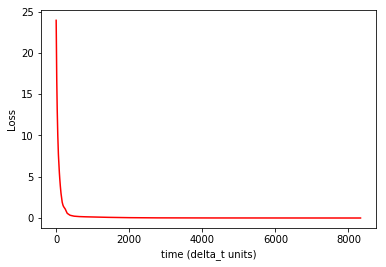

In [27]:
obs.plotLoss()

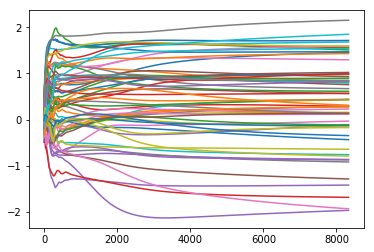

In [28]:
obs.plotParameters()

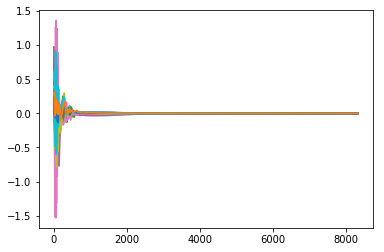

In [29]:
obs.plotVelocities()

### Compute reconstructed vector field & reconstruction error

given the linear system:
\begin{equation}
    \dot{x} = \Psi(x)
\end{equation}
Let the neural network model be
\begin{equation}
    y = f(x,\vartheta)
\end{equation}
After the training, the reconstruction error is computed (in a certain quantized region of the state-space) as
\begin{equation}
    E(x) = \|\Psi(x)-f(x,\vartheta^*)\|_2^2
\end{equation}
where $\vartheta^*$ is the trained vector of parameters

In [30]:
def calculateComponents(x0, x1):
    return x1[0] - x0[0], x1[1] - x0[1]

Text(0.5, 1.0, 'Learned vec field vs ground truth')

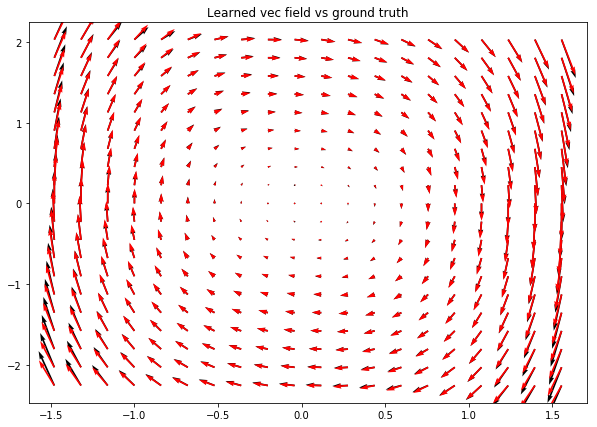

In [31]:
Up = np.zeros((Np,Np))
Vp = np.zeros((Np,Np))

for i in range(int(Np)):
    for j in range(Np):
        point = torch.Tensor([X1[i,j],X2[i,j]]).to(device)
        Up[i,j], Vp[i,j] = obs.predictor(point.view(1,2))[0][0], obs.predictor(point.view(1,2))[0][1]

fig, ax = plt.subplots(figsize=(10,7))
q = ax.quiver(X1, X2, U, V,scale = 80)
q = ax.quiver(X1, X2, Up, Vp, scale = 80,color = 'r')
plt.title("Learned vec field vs ground truth")

## Error contour plot

In [37]:
E = np.zeros((Np,Np))

for i in range(Np):
    for j in range(Np):
        E[i,j] = np.sqrt(pow(U[i,j]-Up[i,j],2)+pow(V[i,j]-Vp[i,j],2))#*100/np.sqrt(pow(U[i,j],2)+pow(V[i,j],2))

Text(0.5, 1.0, 'Vector Field reconstruction Error')

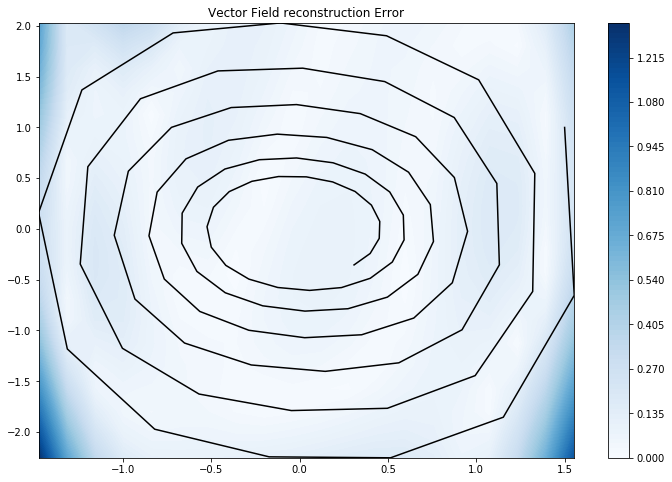

In [43]:

#### Plot contour map of the vector field's reconstruction error
plt.figure(figsize=(12,8))
plt.contourf(X1, X2, E,100,cmap='Blues')
plt.plot(orig_traj[:,0],orig_traj[:,1], color='black')
plt.colorbar()
plt.title("Vector Field reconstruction Error")

## Reconstructed trajectory

We want to compare the reference trajectory $x_{r}(t)$ obtained by integrating the ODE $\dot{x}=\Psi(x)$ with $x_r(0) = x_0$ with a trajectory $\hat{x}(t)$ obtained by integrating $\dot{x}= f(x,\theta^*)$ (the NN model) with the same initial condition.

We can then evaluate how the reconstructed trajectory remains close to $x_r(t)$

In [44]:
def LV_Learned(xi0, t):
    return obs.predictor(torch.Tensor(xi0).view(1,2).to(device)).flatten().detach().cpu()

In [45]:
func = LV_Learned
t = np.linspace(0,Tf,N)
x0 = [1.5, 1]
sol = odeint(func, x0, t)

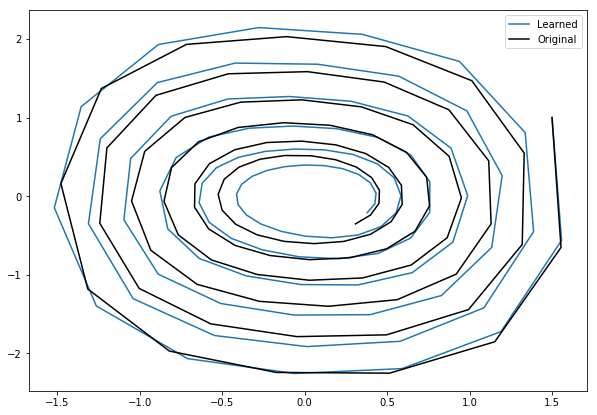

In [46]:
plt.figure(figsize=(10,7))
plt.plot([s[0] for s in sol], [s[1] for s in sol])
plt.plot(orig_traj[:,0],orig_traj[:,1], color='black')
plt.legend(['Learned','Original'])